In [1]:
# start with the libraries
# get environment information

import sys
print(sys.version)
print(sys.executable)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
//anaconda3/envs/timeseries36/bin/python


In [2]:
# import the base libraries
# standard libraries
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import os
import math
from itertools import cycle
import datetime
from datetime import datetime as dt
from datetime import timedelta

# plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to visualize all of the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import re
import csv
import json
import ast
from pandas.io.json import json_normalize

pd.options.display.max_colwidth = 2000
pd.set_option('display.max_rows', 100)


# for database connectivity
import psycopg2
import getpass

print(os.getcwd())

/Users/bryanbutler/Documents/Python/Forecasting/EWS


In [3]:
# user
# stream=sys.stderr
uid = getpass.getpass()

········


In [6]:
# pwd

pwd = getpass.getpass()

········


In [7]:
# connection

con=psycopg2.connect(dbname= 'dw_main', host='rs-prd-bi-cluster.cdw0722fdg2r.us-east-1.redshift.amazonaws.com', 
port= '5439', user= uid, password= pwd)
# del uid, pwd
cursor = con.cursor()

In [8]:
# set the cutoff date

cutoff_date = '2020-03-01'

In [9]:
# query
# this is for all key EWS data
# check the end date

sql_query = """
SELECT
       CAST(lcad.date_ride AS date) AS date_ride,
       CASE WHEN dt.holiday_flag LIKE 'Y' THEN 1 ELSE 0 END AS holiday,
       lcad.call_center_state,
       COUNT(DISTINCT lcad.ride_key) AS gross_rides,
       COUNT(distinct CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.ride_key ELSE NULL END) AS verified_paid_rides,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.cost_usd ELSE 0 END ) AS verified_paid_costs,
       SUM(CASE WHEN lcad.ride_status = 'Verified-Paid' THEN lcad.miles ELSE 0 END ) AS verified_paid_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.ride_key ELSE NULL END) AS verified_paid_ambulatory_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_ambulatory_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Ambulatory' THEN lcad.miles ELSE NULL END) AS verified_paid_ambulatory_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.ride_key ELSE NULL END) AS verified_paid_stretcher_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_stretcher_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Stretcher' THEN lcad.miles ELSE NULL END) AS verified_paid_stretcher_miles,
       
       count(distinct CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.ride_key ELSE NULL END) AS verified_paid_wheelchair_rides,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.cost_usd ELSE NULL END) AS verified_paid_wheelchair_costs,
       SUM(CASE WHEN lcad.los_group_desc = 'Wheelchair' THEN lcad.miles ELSE NULL END) AS verified_paid_wheelchair_miles,
       
       count(distinct lcad.rider_code) AS Riders

FROM dw.fact_lcad_ride lcad

LEFT JOIN dw.dim_date dt
    ON lcad.date_dim_id = dt.date_dim_id
WHERE
      provider_type_name NOT IN ('Public Transit', 'Gas Reimbursement', 'Unassigned')
  AND provider_type_name IS NOT NULL
  AND date(date_ride) < %s 
  AND lcad.provider_is_lcad = 'LCAD'
  AND lcad.broker_client_contract_type != 'FFS'
  AND lcad.los_group_desc in ('Ambulatory' , 'Wheelchair', 'Stretcher')
GROUP BY date_ride, holiday, call_center_state
ORDER BY date_ride

""" 

In [10]:
data = pd.read_sql_query(sql = sql_query, con = con, params = [cutoff_date])
data.head()

date_ride  holiday call_center_state  gross_rides  verified_paid_rides  \
0  2014-01-01        1                HI          765                    8   
1  2014-01-01        1                MO          881                  451   
2  2014-01-01        1                AZ          303                   64   
3  2014-01-01        1                AR            2                    2   
4  2014-01-01        1                CA          242                   30   

   verified_paid_costs  verified_paid_miles  verified_paid_ambulatory_rides  \
0               480.65                  162                             463   
1            14,106.09                 6738                             587   
2             1,778.93                  814                              98   
3               366.60                   92                               2   
4             1,040.62                  331                             153   

   verified_paid_ambulatory_costs  verified_paid_ambulatory_miles  \
0                          365.25                        4,154.00   
1                        7,411.61                        8,524.00   
2                          390.07                          819.00   
3                          366.60                           92.00   
4                          999.58                        1,139.00   

   verified_paid_stretcher_rides  verified_paid_stretcher_costs  \
0                              2                           0.00   
1                              5                         829.20   
2                             10                           0.00   
3                              0                            nan   
4                             27                           0.00   

   verified_paid_stretcher_miles  verified_paid_wheelchair_rides  \
0                           4.00                             300   
1                          49.00                             289   
2                          51.00                             195   
3                            nan                               0   
4                         165.00                              62   

   verified_paid_wheelchair_costs  verified_paid_wheelchair_miles  riders  
0                          115.40                        2,162.00     387  
1                        5,865.28                        3,693.00     439  
2                        1,388.86                        1,400.00     153  
3                             nan                             nan       1  
4                           41.04                          290.00     128

In [11]:
data.tail()

date_ride  holiday call_center_state  gross_rides  \
78347  2020-02-29        0                LA          559   
78348  2020-02-29        0                WA           13   
78349  2020-02-29        0                ID            2   
78350  2020-02-29        0                IN         1059   
78351  2020-02-29        0                MS           24   

       verified_paid_rides  verified_paid_costs  verified_paid_miles  \
78347                  105             2,169.27                  922   
78348                    7               158.23                   66   
78349                    2                99.57                   63   
78350                  166             5,710.89                 2902   
78351                    2                73.00                   16   

       verified_paid_ambulatory_rides  verified_paid_ambulatory_costs  \
78347                             494                        2,097.41   
78348                              13                          158.23   
78349                               2                           99.57   
78350                            1043                        5,636.39   
78351                              22                            0.00   

       verified_paid_ambulatory_miles  verified_paid_stretcher_rides  \
78347                        5,307.00                              0   
78348                           90.00                              0   
78349                           63.00                              0   
78350                       18,473.00                              0   
78351                          259.00                              0   

       verified_paid_stretcher_costs  verified_paid_stretcher_miles  \
78347                            nan                            nan   
78348                            nan                            nan   
78349                            nan                            nan   
78350                            nan                            nan   
78351                            nan                            nan   

       verified_paid_wheelchair_rides  verified_paid_wheelchair_costs  \
78347                              65                           71.86   
78348                               0                             nan   
78349                               0                             nan   
78350                              16                           74.50   
78351                               2                           73.00   

       verified_paid_wheelchair_miles  riders  
78347                          319.00     279  
78348                             nan       6  
78349                             nan       1  
78350                          200.00     517  
78351                           16.00      12

In [12]:
# replace all NaN with 0
df = data.copy()

df = df.fillna(0)
df.head()

date_ride  holiday call_center_state  gross_rides  verified_paid_rides  \
0  2014-01-01        1                HI          765                    8   
1  2014-01-01        1                MO          881                  451   
2  2014-01-01        1                AZ          303                   64   
3  2014-01-01        1                AR            2                    2   
4  2014-01-01        1                CA          242                   30   

   verified_paid_costs  verified_paid_miles  verified_paid_ambulatory_rides  \
0               480.65                  162                             463   
1            14,106.09                 6738                             587   
2             1,778.93                  814                              98   
3               366.60                   92                               2   
4             1,040.62                  331                             153   

   verified_paid_ambulatory_costs  verified_paid_ambulatory_miles  \
0                          365.25                        4,154.00   
1                        7,411.61                        8,524.00   
2                          390.07                          819.00   
3                          366.60                           92.00   
4                          999.58                        1,139.00   

   verified_paid_stretcher_rides  verified_paid_stretcher_costs  \
0                              2                           0.00   
1                              5                         829.20   
2                             10                           0.00   
3                              0                           0.00   
4                             27                           0.00   

   verified_paid_stretcher_miles  verified_paid_wheelchair_rides  \
0                           4.00                             300   
1                          49.00                             289   
2                          51.00                             195   
3                           0.00                               0   
4                         165.00                              62   

   verified_paid_wheelchair_costs  verified_paid_wheelchair_miles  riders  
0                          115.40                        2,162.00     387  
1                        5,865.28                        3,693.00     439  
2                        1,388.86                        1,400.00     153  
3                            0.00                            0.00       1  
4                           41.04                          290.00     128

In [13]:
# convert date_ride to date and set as index
# only do this for direct SQL pull

# make a date
df['date_ride'] = pd.to_datetime(df['date_ride'], format='%Y-%m-%d')

# set the index
df = df.set_index(df['date_ride'])

df.head()

date_ride  holiday call_center_state  gross_rides  \
date_ride                                                       
2014-01-01 2014-01-01        1                HI          765   
2014-01-01 2014-01-01        1                MO          881   
2014-01-01 2014-01-01        1                AZ          303   
2014-01-01 2014-01-01        1                AR            2   
2014-01-01 2014-01-01        1                CA          242   

            verified_paid_rides  verified_paid_costs  verified_paid_miles  \
date_ride                                                                   
2014-01-01                    8               480.65                  162   
2014-01-01                  451            14,106.09                 6738   
2014-01-01                   64             1,778.93                  814   
2014-01-01                    2               366.60                   92   
2014-01-01                   30             1,040.62                  331   

            verified_paid_ambulatory_rides  verified_paid_ambulatory_costs  \
date_ride                                                                    
2014-01-01                             463                          365.25   
2014-01-01                             587                        7,411.61   
2014-01-01                              98                          390.07   
2014-01-01                               2                          366.60   
2014-01-01                             153                          999.58   

            verified_paid_ambulatory_miles  verified_paid_stretcher_rides  \
date_ride                                                                   
2014-01-01                        4,154.00                              2   
2014-01-01                        8,524.00                              5   
2014-01-01                          819.00                             10   
2014-01-01                           92.00                              0   
2014-01-01                        1,139.00                             27   

            verified_paid_stretcher_costs  verified_paid_stretcher_miles  \
date_ride                                                                  
2014-01-01                           0.00                           4.00   
2014-01-01                         829.20                          49.00   
2014-01-01                           0.00                          51.00   
2014-01-01                           0.00                           0.00   
2014-01-01                           0.00                         165.00   

            verified_paid_wheelchair_rides  verified_paid_wheelchair_costs  \
date_ride                                                                    
2014-01-01                             300                          115.40   
2014-01-01                             289                        5,865.28   
2014-01-01                             195                        1,388.86   
2014-01-01                               0                            0.00   
2014-01-01                              62                           41.04   

            verified_paid_wheelchair_miles  riders  
date_ride                                           
2014-01-01                        2,162.00     387  
2014-01-01                        3,693.00     439  
2014-01-01                        1,400.00     153  
2014-01-01                            0.00       1  
2014-01-01                          290.00     128

In [14]:
# convert data to weekly format

# weekly sample drops call center state
wdf = df.resample('W').aggregate({'holiday': np.max,
                                  'gross_rides': np.sum,
                                  'verified_paid_rides': np.sum,
                                  'verified_paid_costs': np.sum,
                                  'verified_paid_miles': np.sum,
                                  'verified_paid_ambulatory_rides': np.sum,
                                  'verified_paid_ambulatory_costs': np.sum,
                                  'verified_paid_ambulatory_miles': np.sum,
                                  'verified_paid_stretcher_rides': np.sum,
                                  'verified_paid_stretcher_costs': np.sum,
                                  'verified_paid_stretcher_miles': np.sum,
                                  'verified_paid_wheelchair_rides': np.sum,
                                  'verified_paid_wheelchair_costs': np.sum,
                                  'verified_paid_wheelchair_miles': np.sum,
                                  'riders': np.sum})
wdf.head()

holiday  gross_rides  verified_paid_rides  verified_paid_costs  \
date_ride                                                                    
2014-01-05        1       339193               151170         3,657,245.83   
2014-01-12        0       716978               417251        10,218,253.61   
2014-01-19        0       756659               464330        11,398,957.14   
2014-01-26        0       736904               388920         9,745,250.59   
2014-02-02        0       759988               414369        10,209,757.24   

            verified_paid_miles  verified_paid_ambulatory_rides  \
date_ride                                                         
2014-01-05              1858376                          276999   
2014-01-12              5160147                          594478   
2014-01-19              5772414                          629920   
2014-01-26              4933421                          613532   
2014-02-02              4948844                          633274   

            verified_paid_ambulatory_costs  verified_paid_ambulatory_miles  \
date_ride                                                                    
2014-01-05                    2,521,979.56                    2,887,658.00   
2014-01-12                    7,425,178.64                    6,588,932.00   
2014-01-19                    8,320,541.03                    6,977,972.00   
2014-01-26                    7,050,347.37                    6,760,931.00   
2014-02-02                    7,460,196.84                    6,883,461.00   

            verified_paid_stretcher_rides  verified_paid_stretcher_costs  \
date_ride                                                                  
2014-01-05                           7172                     267,237.82   
2014-01-12                          13331                     611,998.27   
2014-01-19                          13909                     679,684.35   
2014-01-26                          13468                     607,413.60   
2014-02-02                          13810                     604,284.39   

            verified_paid_stretcher_miles  verified_paid_wheelchair_rides  \
date_ride                                                                   
2014-01-05                      62,639.00                           55022   
2014-01-12                     129,201.00                          109169   
2014-01-19                     130,822.00                          112830   
2014-01-26                     125,796.00                          109904   
2014-02-02                     134,792.00                          112904   

            verified_paid_wheelchair_costs  verified_paid_wheelchair_miles  \
date_ride                                                                    
2014-01-05                      868,028.45                      463,980.00   
2014-01-12                    2,181,076.70                      969,953.00   
2014-01-19                    2,398,731.76                    1,015,678.00   
2014-01-26                    2,087,489.62                      982,666.00   
2014-02-02                    2,145,276.01                    1,006,160.00   

            riders  
date_ride           
2014-01-05  167247  
2014-01-12  352948  
2014-01-19  371953  
2014-01-26  362595  
2014-02-02  373441

In [15]:
wdf.tail()

holiday  gross_rides  verified_paid_rides  verified_paid_costs  \
date_ride                                                                    
2020-02-02        0       941280               622527        18,894,204.29   
2020-02-09        0       928254               566661        17,138,900.71   
2020-02-16        0       954113               568565        16,923,807.59   
2020-02-23        0       929673               454635        13,240,861.11   
2020-03-01        0       943417               320270         8,883,570.13   

            verified_paid_miles  verified_paid_ambulatory_rides  \
date_ride                                                         
2020-02-02              7596232                          788167   
2020-02-09              6794006                          777102   
2020-02-16              6868239                          800762   
2020-02-23              5395728                          779306   
2020-03-01              3629705                          790590   

            verified_paid_ambulatory_costs  verified_paid_ambulatory_miles  \
date_ride                                                                    
2020-02-02                   13,471,886.37                    9,641,396.00   
2020-02-09                   12,202,586.41                    9,435,784.00   
2020-02-16                   12,303,221.17                    9,754,077.00   
2020-02-23                    9,654,844.98                    9,464,593.00   
2020-03-01                    6,633,025.89                    9,496,562.00   

            verified_paid_stretcher_rides  verified_paid_stretcher_costs  \
date_ride                                                                  
2020-02-02                          15908                   1,611,805.49   
2020-02-09                          15638                   1,501,268.12   
2020-02-16                          15632                   1,318,111.55   
2020-02-23                          15067                     979,535.64   
2020-03-01                          15349                     603,405.85   

            verified_paid_stretcher_miles  verified_paid_wheelchair_rides  \
date_ride                                                                   
2020-02-02                     153,019.00                          137205   
2020-02-09                     145,926.00                          135514   
2020-02-16                     145,058.00                          137719   
2020-02-23                     134,743.00                          135300   
2020-03-01                     141,063.00                          137478   

            verified_paid_wheelchair_costs  verified_paid_wheelchair_miles  \
date_ride                                                                    
2020-02-02                    3,810,512.43                    1,263,936.00   
2020-02-09                    3,435,046.18                    1,227,600.00   
2020-02-16                    3,302,474.87                    1,261,341.00   
2020-02-23                    2,606,480.49                    1,237,728.00   
2020-03-01                    1,647,138.39                    1,263,080.00   

            riders  
date_ride           
2020-02-02  457414  
2020-02-09  451245  
2020-02-16  463230  
2020-02-23  451583  
2020-03-01  458057

In [16]:
# import all of the stats functions to be used

import timeseries_module_v1 as ts

In [98]:
# get the oos data in weeks

oos = pd.read_csv('2019_2020_holidays.csv', index_col='date', parse_dates = True)
oos.head()

holiday
date               
2019-11-03        0
2019-11-10        0
2019-11-17        0
2019-11-24        0
2019-12-01        1

In [99]:
oos.tail()

holiday
date               
2020-12-06        0
2020-12-13        0
2020-12-20        0
2020-12-27        1
2021-01-03        0

In [100]:
# clean up the verified_paid portion to vp

wdf.columns = wdf.columns.str.replace('verified_paid','vp')
wdf.head()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2014-01-12        0       716978    417251 10,218,253.61   5160147   
2014-01-19        0       756659    464330 11,398,957.14   5772414   
2014-01-26        0       736904    388920  9,745,250.59   4933421   
2014-02-02        0       759988    414369 10,209,757.24   4948844   
2014-02-09        0       734042    407991  9,852,916.99   5086865   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2014-01-12               594478         7,425,178.64         6,588,932.00   
2014-01-19               629920         8,320,541.03         6,977,972.00   
2014-01-26               613532         7,050,347.37         6,760,931.00   
2014-02-02               633274         7,460,196.84         6,883,461.00   
2014-02-09               611062         7,129,966.30         6,747,168.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2014-01-12               13331          611,998.27          129,201.00   
2014-01-19               13909          679,684.35          130,822.00   
2014-01-26               13468          607,413.60          125,796.00   
2014-02-02               13810          604,284.39          134,792.00   
2014-02-09               13669          626,212.70          134,222.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2014-01-12               109169         2,181,076.70           969,953.00   
2014-01-19               112830         2,398,731.76         1,015,678.00   
2014-01-26               109904         2,087,489.62           982,666.00   
2014-02-02               112904         2,145,276.01         1,006,160.00   
2014-02-09               109311         2,096,737.99           966,229.00   

            riders  cpm  
date_ride                
2014-01-12  352948 1.98  
2014-01-19  371953 1.97  
2014-01-26  362595 1.98  
2014-02-02  373441 2.06  
2014-02-09  361216 1.94

In [20]:
wdf.tail()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2020-02-02        0       941280    622527 18,894,204.29   7596232   
2020-02-09        0       928254    566661 17,138,900.71   6794006   
2020-02-16        0       954113    568565 16,923,807.59   6868239   
2020-02-23        0       929673    454635 13,240,861.11   5395728   
2020-03-01        0       943417    320270  8,883,570.13   3629705   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2020-02-02               788167        13,471,886.37         9,641,396.00   
2020-02-09               777102        12,202,586.41         9,435,784.00   
2020-02-16               800762        12,303,221.17         9,754,077.00   
2020-02-23               779306         9,654,844.98         9,464,593.00   
2020-03-01               790590         6,633,025.89         9,496,562.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2020-02-02               15908        1,611,805.49          153,019.00   
2020-02-09               15638        1,501,268.12          145,926.00   
2020-02-16               15632        1,318,111.55          145,058.00   
2020-02-23               15067          979,535.64          134,743.00   
2020-03-01               15349          603,405.85          141,063.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2020-02-02               137205         3,810,512.43         1,263,936.00   
2020-02-09               135514         3,435,046.18         1,227,600.00   
2020-02-16               137719         3,302,474.87         1,261,341.00   
2020-02-23               135300         2,606,480.49         1,237,728.00   
2020-03-01               137478         1,647,138.39         1,263,080.00   

            riders  
date_ride           
2020-02-02  457414  
2020-02-09  451245  
2020-02-16  463230  
2020-02-23  451583  
2020-03-01  458057

In [21]:
# create cost per mile

wdf['cpm'] = wdf['vp_costs']/wdf['vp_miles']

In [22]:
print(cutoff_date)

2020-03-01


In [23]:
# reset the index for writing

wdf.reset_index(inplace=True)
wdf.head()

date_ride  holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
0 2014-01-05        1       339193    151170  3,657,245.83   1858376   
1 2014-01-12        0       716978    417251 10,218,253.61   5160147   
2 2014-01-19        0       756659    464330 11,398,957.14   5772414   
3 2014-01-26        0       736904    388920  9,745,250.59   4933421   
4 2014-02-02        0       759988    414369 10,209,757.24   4948844   

   vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
0               276999         2,521,979.56         2,887,658.00   
1               594478         7,425,178.64         6,588,932.00   
2               629920         8,320,541.03         6,977,972.00   
3               613532         7,050,347.37         6,760,931.00   
4               633274         7,460,196.84         6,883,461.00   

   vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
0                7172          267,237.82           62,639.00   
1               13331          611,998.27          129,201.00   
2               13909          679,684.35          130,822.00   
3               13468          607,413.60          125,796.00   
4               13810          604,284.39          134,792.00   

   vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  riders  cpm  
0                55022           868,028.45           463,980.00  167247 1.97  
1               109169         2,181,076.70           969,953.00  352948 1.98  
2               112830         2,398,731.76         1,015,678.00  371953 1.97  
3               109904         2,087,489.62           982,666.00  362595 1.98  
4               112904         2,145,276.01         1,006,160.00  373441 2.06

In [24]:
# write wide and long to .csv

wdf.to_csv('wdf_cutoff_' + cutoff_date + '.csv', index = False)

In [25]:
# if getting from csv

# wdf = pd.read_csv('wdf_cutoff_2020-02-01.csv',index_col='date_ride', parse_dates = True)

In [26]:
# set index for modeling

wdf.set_index('date_ride', inplace=True)

wdf.head()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2014-01-05        1       339193    151170  3,657,245.83   1858376   
2014-01-12        0       716978    417251 10,218,253.61   5160147   
2014-01-19        0       756659    464330 11,398,957.14   5772414   
2014-01-26        0       736904    388920  9,745,250.59   4933421   
2014-02-02        0       759988    414369 10,209,757.24   4948844   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2014-01-05               276999         2,521,979.56         2,887,658.00   
2014-01-12               594478         7,425,178.64         6,588,932.00   
2014-01-19               629920         8,320,541.03         6,977,972.00   
2014-01-26               613532         7,050,347.37         6,760,931.00   
2014-02-02               633274         7,460,196.84         6,883,461.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2014-01-05                7172          267,237.82           62,639.00   
2014-01-12               13331          611,998.27          129,201.00   
2014-01-19               13909          679,684.35          130,822.00   
2014-01-26               13468          607,413.60          125,796.00   
2014-02-02               13810          604,284.39          134,792.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2014-01-05                55022           868,028.45           463,980.00   
2014-01-12               109169         2,181,076.70           969,953.00   
2014-01-19               112830         2,398,731.76         1,015,678.00   
2014-01-26               109904         2,087,489.62           982,666.00   
2014-02-02               112904         2,145,276.01         1,006,160.00   

            riders  cpm  
date_ride                
2014-01-05  167247 1.97  
2014-01-12  352948 1.98  
2014-01-19  371953 1.97  
2014-01-26  362595 1.98  
2014-02-02  373441 2.06

In [27]:
# drop the frst one
wdf = wdf.iloc[1:]

wdf.tail(10)

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-12-29        1       758185    391379 12,151,085.08   4450380   
2020-01-05        1       749768    409959 12,960,899.16   4976970   
2020-01-12        0       904552    611228 18,964,433.98   7481910   
2020-01-19        0       944548    631012 19,402,582.09   7699812   
2020-01-26        0       918231    596814 18,183,310.97   7230613   
2020-02-02        0       941280    622527 18,894,204.29   7596232   
2020-02-09        0       928254    566661 17,138,900.71   6794006   
2020-02-16        0       954113    568565 16,923,807.59   6868239   
2020-02-23        0       929673    454635 13,240,861.11   5395728   
2020-03-01        0       943417    320270  8,883,570.13   3629705   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-12-29               609638         8,015,844.14         6,876,849.00   
2020-01-05               608871         8,846,542.02         7,214,634.00   
2020-01-12               755175        13,339,823.88         9,315,044.00   
2020-01-19               790636        13,724,676.78         9,715,077.00   
2020-01-26               767819        12,840,933.98         9,356,657.00   
2020-02-02               788167        13,471,886.37         9,641,396.00   
2020-02-09               777102        12,202,586.41         9,435,784.00   
2020-02-16               800762        12,303,221.17         9,754,077.00   
2020-02-23               779306         9,654,844.98         9,464,593.00   
2020-03-01               790590         6,633,025.89         9,496,562.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-12-29               16524        1,408,167.03          127,978.00   
2020-01-05               15903        1,381,800.37          135,331.00   
2020-01-12               15999        1,772,658.05          149,490.00   
2020-01-19               16491        1,806,395.43          157,050.00   
2020-01-26               15566        1,641,127.34          145,246.00   
2020-02-02               15908        1,611,805.49          153,019.00   
2020-02-09               15638        1,501,268.12          145,926.00   
2020-02-16               15632        1,318,111.55          145,058.00   
2020-02-23               15067          979,535.64          134,743.00   
2020-03-01               15349          603,405.85          141,063.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-12-29               132023         2,727,073.91         1,059,445.00   
2020-01-05               124994         2,732,556.77         1,050,885.00   
2020-01-12               133378         3,851,952.05         1,221,662.00   
2020-01-19               137421         3,871,509.88         1,262,349.00   
2020-01-26               134846         3,701,249.65         1,225,200.00   
2020-02-02               137205         3,810,512.43         1,263,936.00   
2020-02-09               135514         3,435,046.18         1,227,600.00   
2020-02-16               137719         3,302,474.87         1,261,341.00   
2020-02-23               135300         2,606,480.49         1,237,728.00   
2020-03-01               137478         1,647,138.39         1,263,080.00   

            riders  cpm  
date_ride                
2019-12-29  370238 2.73  
2020-01-05  365499 2.60  
2020-01-12  440217 2.53  
2020-01-19  458714 2.52  
2020-01-26  446250 2.51  
2020-02-02  457414 2.49  
2020-02-09  451245 2.52  
2020-02-16  463230 2.46  
2020-02-23  451583 2.45  
2020-03-01  458057 2.45

In [86]:
# cut the data for verifiedd paid lag of ~ 66 days

vp_lag_days = 66

vp_lag_wks = int(vp_lag_days/7)+ (vp_lag_days % 7 > 0)


vpdf = wdf.iloc[:-vp_lag_wks]
vpdf.tail()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-11-24        0       977888    676430 20,722,037.66   8260713   
2019-12-01        1       809371    455784 14,144,575.45   5389185   
2019-12-08        0       894946    605317 18,723,561.45   7399818   
2019-12-15        0       941193    642577 19,770,739.31   7871431   
2019-12-22        0       980192    661529 20,365,489.62   8042387   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-11-24               816597        14,475,421.82        10,048,889.00   
2019-12-01               662252         9,517,369.50         7,769,336.00   
2019-12-08               745146        13,059,427.08         9,186,129.00   
2019-12-15               786898        13,912,388.74         9,710,523.00   
2019-12-22               816024        14,208,297.41        10,018,564.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-11-24               16591        1,984,552.36          163,594.00   
2019-12-01               15335        1,572,183.80          137,991.00   
2019-12-08               15645        1,777,666.92          145,711.00   
2019-12-15               16268        1,871,633.36          157,227.00   
2019-12-22               17489        1,954,392.97          161,607.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-11-24               144700         4,262,063.48         1,330,803.00   
2019-12-01               131784         3,055,022.15         1,129,006.00   
2019-12-08               134155         3,886,467.45         1,237,056.00   
2019-12-15               138027         3,986,717.21         1,263,769.00   
2019-12-22               146679         4,202,799.24         1,330,414.00   

            riders  cpm  
date_ride                
2019-11-24  474834 2.51  
2019-12-01  392688 2.62  
2019-12-08  435617 2.53  
2019-12-15  457379 2.51  
2019-12-22  475897 2.53

# Get the Data in the Adjudication Gap
## Use as test data for rides and riders

In [87]:
# -10 might overlap

test = wdf.iloc[-10:]
test

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-12-29        1       758185    391379 12,151,085.08   4450380   
2020-01-05        1       749768    409959 12,960,899.16   4976970   
2020-01-12        0       904552    611228 18,964,433.98   7481910   
2020-01-19        0       944548    631012 19,402,582.09   7699812   
2020-01-26        0       918231    596814 18,183,310.97   7230613   
2020-02-02        0       941280    622527 18,894,204.29   7596232   
2020-02-09        0       928254    566661 17,138,900.71   6794006   
2020-02-16        0       954113    568565 16,923,807.59   6868239   
2020-02-23        0       929673    454635 13,240,861.11   5395728   
2020-03-01        0       943417    320270  8,883,570.13   3629705   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-12-29               609638         8,015,844.14         6,876,849.00   
2020-01-05               608871         8,846,542.02         7,214,634.00   
2020-01-12               755175        13,339,823.88         9,315,044.00   
2020-01-19               790636        13,724,676.78         9,715,077.00   
2020-01-26               767819        12,840,933.98         9,356,657.00   
2020-02-02               788167        13,471,886.37         9,641,396.00   
2020-02-09               777102        12,202,586.41         9,435,784.00   
2020-02-16               800762        12,303,221.17         9,754,077.00   
2020-02-23               779306         9,654,844.98         9,464,593.00   
2020-03-01               790590         6,633,025.89         9,496,562.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-12-29               16524        1,408,167.03          127,978.00   
2020-01-05               15903        1,381,800.37          135,331.00   
2020-01-12               15999        1,772,658.05          149,490.00   
2020-01-19               16491        1,806,395.43          157,050.00   
2020-01-26               15566        1,641,127.34          145,246.00   
2020-02-02               15908        1,611,805.49          153,019.00   
2020-02-09               15638        1,501,268.12          145,926.00   
2020-02-16               15632        1,318,111.55          145,058.00   
2020-02-23               15067          979,535.64          134,743.00   
2020-03-01               15349          603,405.85          141,063.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-12-29               132023         2,727,073.91         1,059,445.00   
2020-01-05               124994         2,732,556.77         1,050,885.00   
2020-01-12               133378         3,851,952.05         1,221,662.00   
2020-01-19               137421         3,871,509.88         1,262,349.00   
2020-01-26               134846         3,701,249.65         1,225,200.00   
2020-02-02               137205         3,810,512.43         1,263,936.00   
2020-02-09               135514         3,435,046.18         1,227,600.00   
2020-02-16               137719         3,302,474.87         1,261,341.00   
2020-02-23               135300         2,606,480.49         1,237,728.00   
2020-03-01               137478         1,647,138.39         1,263,080.00   

            riders  cpm  
date_ride                
2019-12-29  370238 2.73  
2020-01-05  365499 2.60  
2020-01-12  440217 2.53  
2020-01-19  458714 2.52  
2020-01-26  446250 2.51  
2020-02-02  457414 2.49  
2020-02-09  451245 2.52  
2020-02-16  463230 2.46  
2020-02-23  451583 2.45  
2020-03-01  458057 2.45

# Set the Forecast Horizon
## Full horizon to include verified paid gap

In [101]:
horizon = 19

month_step = 8

oos_exog = oos.iloc[month_step:month_step + horizon]

oos_exog

holiday
date               
2019-12-29        1
2020-01-05        1
2020-01-12        0
2020-01-19        0
2020-01-26        0
2020-02-02        0
2020-02-09        0
2020-02-16        0
2020-02-23        0
2020-03-01        0
2020-03-08        0
2020-03-15        0
2020-03-22        0
2020-03-29        0
2020-04-05        0
2020-04-12        0
2020-04-19        0
2020-04-26        0
2020-05-03        0

In [102]:
# set up for forecasting and backtesting
# set the ranges
train = vpdf.copy()

end = len(train)


# Gross Rides
## Uses VP Training Data

In [103]:
series = 'gross_rides'

In [104]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)


model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        gross_rides   No. Observations:                  311
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood               -3513.545
Date:                            Tue, 03 Mar 2020   AIC                           7041.090
Time:                                    15:56:27   BIC                           7066.970
Sample:                                01-12-2014   HQIC                          7051.449
                                     - 12-22-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.111e+05   5.73e-08  -1.94e+12      0.000   -1.11e+05   -1.11e+05
ar.L1          0.2567      0.004     69.623      0.000       0.249       0.264
ar.L2         -0.9997      0.002   -507.720      0.000      -1.004      -0.996
ma.L1         -0.2613      0.013    -19.908      0.000      -0.287      -0.236
ma.L2          0.9993      0.059     17.004      0.000       0.884       1.115
ar.S.L12      -0.2330      0.012    -19.718      0.000      -0.256      -0.210
sigma2      9.917e+08   5.58e-11   1.78e+19      0.000    9.92e+08    9.92e+08
===================================================================================
Ljung-Box (Q):                      164.23   Jarque-Bera (JB):                50.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.15
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.78e+34. Standard errors may be unstable.
"""

In [105]:
ts.get_dw(model)

1.665741540054036

In [106]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

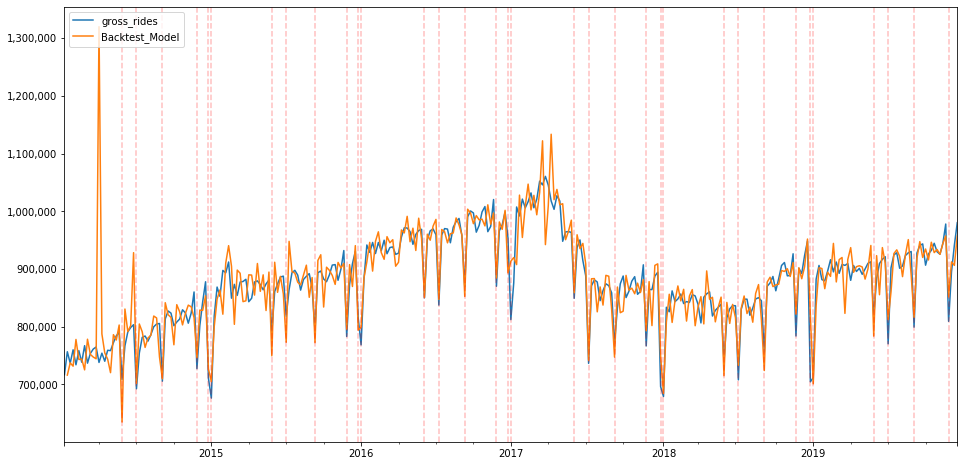

In [107]:
# make the backtest plot

plt.clf()

ts.plot_fit(train[series], backtest, train);

In [108]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

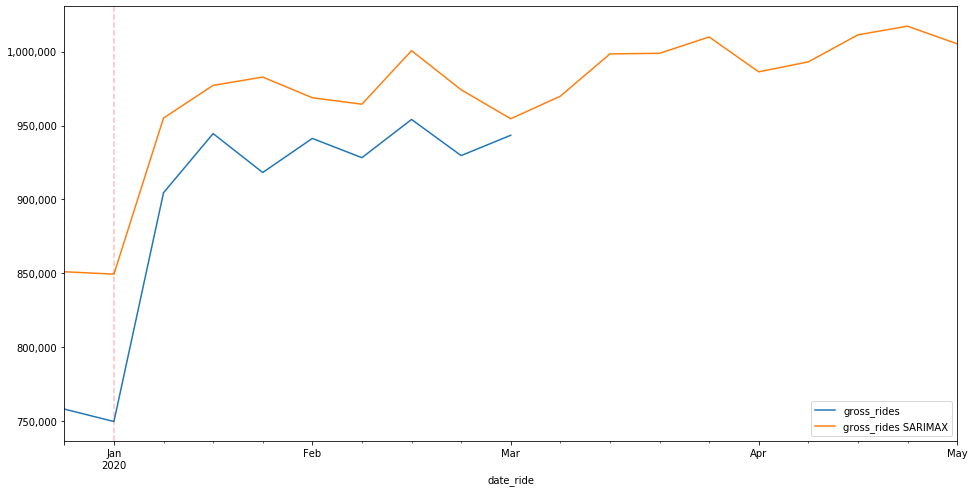

In [109]:
# plot predictions

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=test,
                   vp=False)

In [110]:
# get the comparison of predictions to actual

compare = ts.compare_results(test[series], predictions, test, vp =False)

compare.style.format("{:,.0f}")

In [111]:
# error calculations from predictions and actual

ts.error_calcs(compare, predictions, test[series])

In [112]:
# make the confidence intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [113]:
intervals

Predictions  lower gross_rides  upper gross_rides
2019-12-29   851,086.37         789,215.39         912,957.35
2020-01-05   849,475.02         762,151.51         936,798.53
2020-01-12   955,065.84         848,405.73       1,061,725.95
2020-01-19   977,177.73         854,109.48       1,100,245.97
2020-01-26   982,784.04         845,064.98       1,120,503.11
2020-02-02   968,811.79         817,875.06       1,119,748.52
2020-02-09   964,434.79         801,509.64       1,127,359.94
2020-02-16 1,000,654.17         826,587.43       1,174,720.91
2020-02-23   974,211.55         789,538.10       1,158,884.99
2020-03-01   954,598.93         759,841.22       1,149,356.65
2020-03-08   969,833.71         765,599.50       1,174,067.92
2020-03-15   998,459.84         785,245.98       1,211,673.70
2020-03-22   998,854.97         759,405.02       1,238,304.92
2020-03-29 1,009,922.65         746,777.08       1,273,068.23
2020-04-05   986,337.97         701,652.31       1,271,023.62
2020-04-12   993,062.15         688,454.93       1,297,669.37
2020-04-19 1,011,367.31         687,920.21       1,334,814.40
2020-04-26 1,017,214.71         675,841.64       1,358,587.79
2020-05-03 1,005,270.67         646,966.92       1,363,574.42

In [114]:
# make the df for plotting OOS

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

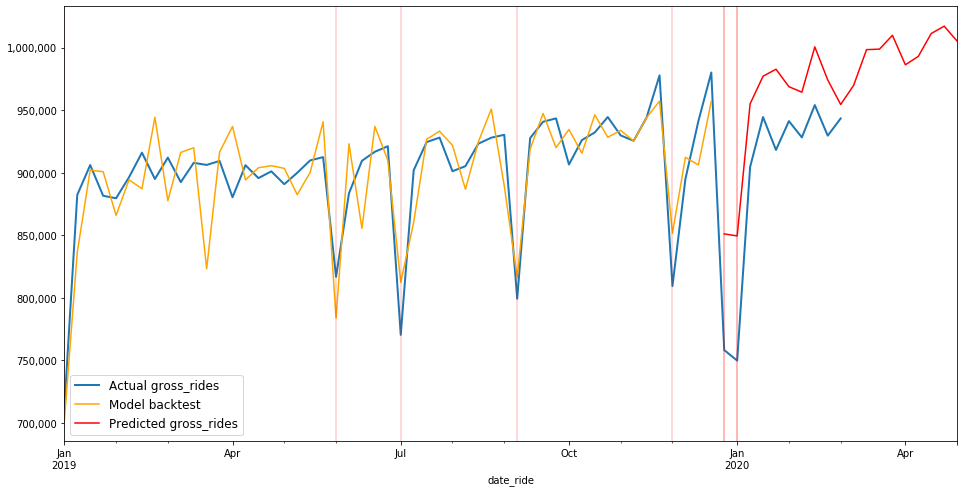

In [115]:
# oos plot

ts.plot_oos(conf_df, wdf, series, backtest, oos_exog, start_date='2019-01-01')

In [116]:
conf_df.reset_index(inplace=True)
conf_df

index  Predictions  lower gross_rides  upper gross_rides
0  2019-12-29   851,086.37         789,215.39         912,957.35
1  2020-01-05   849,475.02         762,151.51         936,798.53
2  2020-01-12   955,065.84         848,405.73       1,061,725.95
3  2020-01-19   977,177.73         854,109.48       1,100,245.97
4  2020-01-26   982,784.04         845,064.98       1,120,503.11
5  2020-02-02   968,811.79         817,875.06       1,119,748.52
6  2020-02-09   964,434.79         801,509.64       1,127,359.94
7  2020-02-16 1,000,654.17         826,587.43       1,174,720.91
8  2020-02-23   974,211.55         789,538.10       1,158,884.99
9  2020-03-01   954,598.93         759,841.22       1,149,356.65
10 2020-03-08   969,833.71         765,599.50       1,174,067.92
11 2020-03-15   998,459.84         785,245.98       1,211,673.70
12 2020-03-22   998,854.97         759,405.02       1,238,304.92
13 2020-03-29 1,009,922.65         746,777.08       1,273,068.23
14 2020-04-05   986,337.97         701,652.31       1,271,023.62
15 2020-04-12   993,062.15         688,454.93       1,297,669.37
16 2020-04-19 1,011,367.31         687,920.21       1,334,814.40
17 2020-04-26 1,017,214.71         675,841.64       1,358,587.79
18 2020-05-03 1,005,270.67         646,966.92       1,363,574.42

# Riders

In [117]:
series = 'riders'

In [118]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  311
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3277.342
Date:                            Tue, 03 Mar 2020   AIC                           6574.684
Time:                                    15:57:18   BIC                           6611.655
Sample:                                01-12-2014   HQIC                          6589.483
                                     - 12-22-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.394e+04   1762.935    -30.596      0.000   -5.74e+04   -5.05e+04
ar.L1          0.3739      0.346      1.081      0.280      -0.304       1.052
ar.L2         -0.5978      0.197     -3.038      0.002      -0.983      -0.212
ma.L1         -0.4696      0.357     -1.316      0.188      -1.169       0.230
ma.L2          0.5382      0.228      2.363      0.018       0.092       0.985
ar.S.L12       0.7586      0.180      4.214      0.000       0.406       1.111
ar.S.L24      -0.2981      0.066     -4.522      0.000      -0.427      -0.169
ma.S.L12      -1.2810      0.185     -6.934      0.000      -1.643      -0.919
ma.S.L24       0.4468      0.166      2.695      0.007       0.122       0.772
sigma2      2.237e+08      0.020   1.12e+10      0.000    2.24e+08    2.24e+08
===================================================================================
Ljung-Box (Q):                      168.43   Jarque-Bera (JB):                64.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+25. Standard errors may be unstable.
"""

In [119]:
ts.get_dw(model)

1.3876966331065437

In [120]:
# make backtest

backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

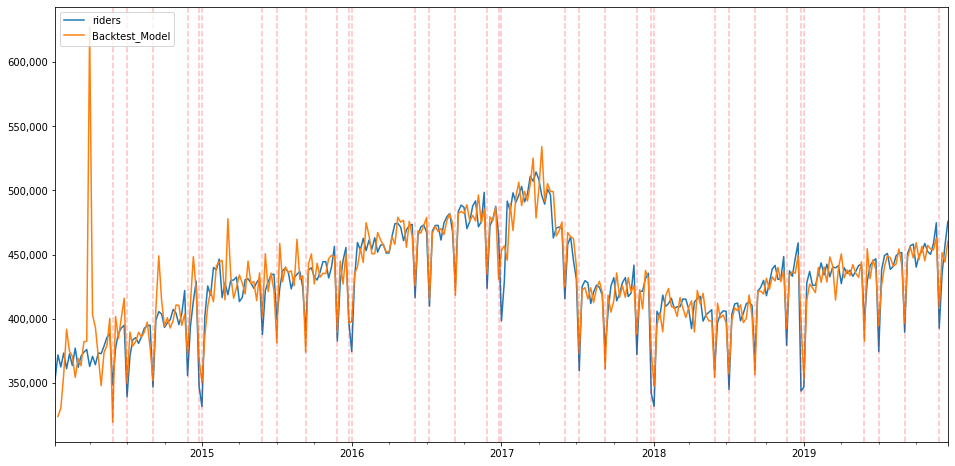

In [121]:
ts.plot_fit(train[series], backtest, train)

In [122]:
predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

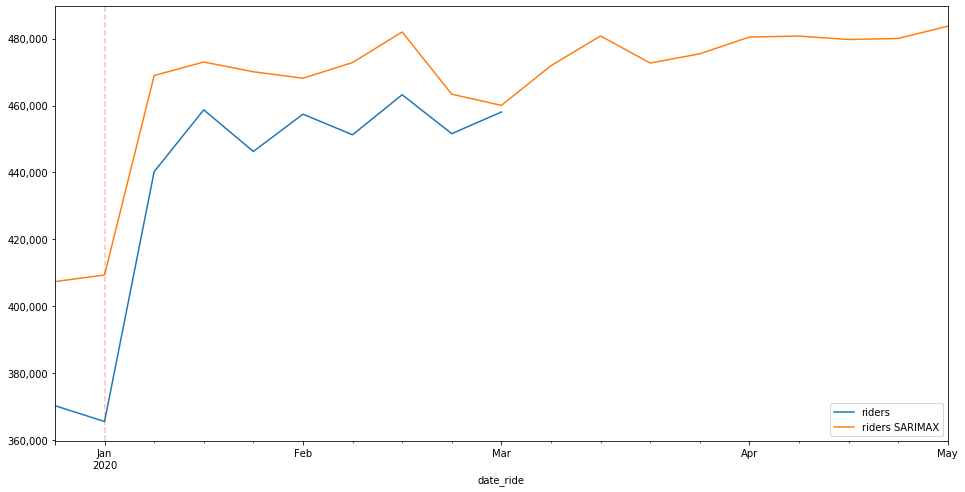

In [123]:
ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=test,
                   vp=False)

In [124]:
compare = ts.compare_results(test[series], predictions, test, vp =False)

compare.style.format("{:,.0f}")

In [125]:
ts.error_calcs(compare, predictions, test[series])

In [126]:
intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [127]:
intervals

Predictions  lower riders  upper riders
2019-12-29   407,347.88    378,032.49    436,663.26
2020-01-05   409,316.14    369,791.89    448,840.38
2020-01-12   468,968.71    422,875.97    515,061.45
2020-01-19   473,014.59    420,887.07    525,142.10
2020-01-26   470,093.11    411,727.68    528,458.53
2020-02-02   468,159.42    404,022.86    532,295.98
2020-02-09   472,846.84    403,799.43    541,894.26
2020-02-16   482,006.48    408,574.45    555,438.52
2020-02-23   463,393.51    385,697.87    541,089.16
2020-03-01   460,042.44    378,151.03    541,933.85
2020-03-08   471,908.88    386,041.13    557,776.62
2020-03-15   480,802.33    391,223.95    570,380.72
2020-03-22   472,703.86    374,831.52    570,576.19
2020-03-29   475,455.41    370,376.47    580,534.34
2020-04-05   480,486.00    369,077.02    591,894.97
2020-04-12   480,766.92    363,289.39    598,244.44
2020-04-19   479,740.76    356,240.79    603,240.73
2020-04-26   480,052.45    350,763.41    609,341.49
2020-05-03   483,727.35    349,020.18    618,434.52

In [128]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

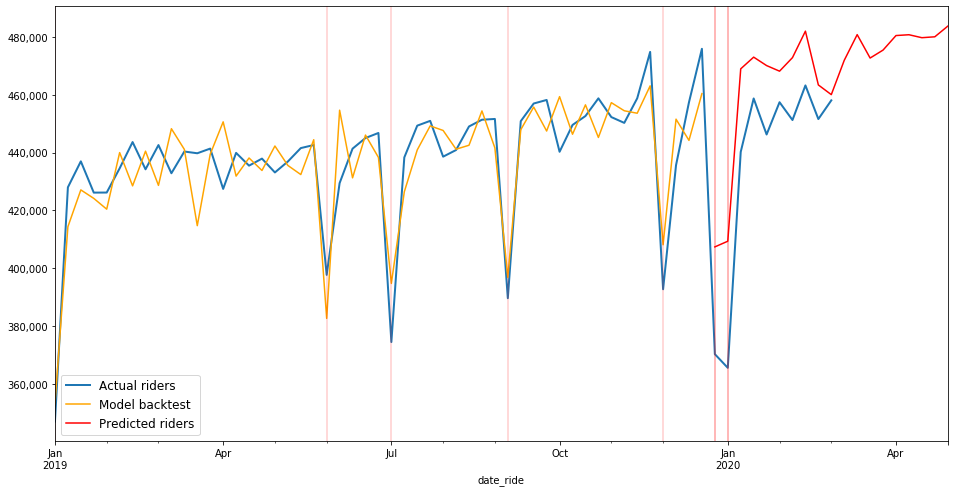

In [129]:
ts.plot_oos(conf_df, wdf, series, backtest, oos_exog, start_date='2019-01-01')

# Reset Training and Exog for OOS Modeling

In [130]:
# set up for forecasting and backtesting
# set the ranges
train = wdf.copy()

end = len(train)

train.tail()

holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2020-02-02        0       941280    622527 18,894,204.29   7596232   
2020-02-09        0       928254    566661 17,138,900.71   6794006   
2020-02-16        0       954113    568565 16,923,807.59   6868239   
2020-02-23        0       929673    454635 13,240,861.11   5395728   
2020-03-01        0       943417    320270  8,883,570.13   3629705   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2020-02-02               788167        13,471,886.37         9,641,396.00   
2020-02-09               777102        12,202,586.41         9,435,784.00   
2020-02-16               800762        12,303,221.17         9,754,077.00   
2020-02-23               779306         9,654,844.98         9,464,593.00   
2020-03-01               790590         6,633,025.89         9,496,562.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2020-02-02               15908        1,611,805.49          153,019.00   
2020-02-09               15638        1,501,268.12          145,926.00   
2020-02-16               15632        1,318,111.55          145,058.00   
2020-02-23               15067          979,535.64          134,743.00   
2020-03-01               15349          603,405.85          141,063.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2020-02-02               137205         3,810,512.43         1,263,936.00   
2020-02-09               135514         3,435,046.18         1,227,600.00   
2020-02-16               137719         3,302,474.87         1,261,341.00   
2020-02-23               135300         2,606,480.49         1,237,728.00   
2020-03-01               137478         1,647,138.39         1,263,080.00   

            riders  cpm  
date_ride                
2020-02-02  457414 2.49  
2020-02-09  451245 2.52  
2020-02-16  463230 2.46  
2020-02-23  451583 2.45  
2020-03-01  458057 2.45

In [131]:
# reset the exogenous series
# roll forward what has occurred

roll_fwd = 18

short_horizon = 13

short_exog = oos.iloc[roll_fwd:roll_fwd + short_horizon]

short_exog

holiday
date               
2020-03-08        0
2020-03-15        0
2020-03-22        0
2020-03-29        0
2020-04-05        0
2020-04-12        0
2020-04-19        0
2020-04-26        0
2020-05-03        0
2020-05-10        0
2020-05-17        0
2020-05-24        0
2020-05-31        1

# Gross Rides - OOS

In [132]:
series = 'gross_rides'

In [133]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)                              

model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        gross_rides   No. Observations:                  321
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood               -3634.189
Date:                            Tue, 03 Mar 2020   AIC                           7282.377
Time:                                    16:02:24   BIC                           7308.488
Sample:                                01-12-2014   HQIC                          7292.818
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     -1.12e+05   3176.500    -35.255      0.000   -1.18e+05   -1.06e+05
ar.L1          0.2562      0.004     70.376      0.000       0.249       0.263
ar.L2         -0.9996      0.002   -467.140      0.000      -1.004      -0.995
ma.L1         -0.2610      0.012    -21.032      0.000      -0.285      -0.237
ma.L2          0.9993      0.058     17.326      0.000       0.886       1.112
ar.S.L12      -0.2311      0.012    -19.305      0.000      -0.255      -0.208
sigma2      9.899e+08      0.008   1.25e+11      0.000     9.9e+08     9.9e+08
===================================================================================
Ljung-Box (Q):                      166.97   Jarque-Bera (JB):                47.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.18
Prob(H) (two-sided):                  0.22   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.16e+27. Standard errors may be unstable.
"""

In [134]:
ts.get_dw(model)

1.676139621144716

In [135]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

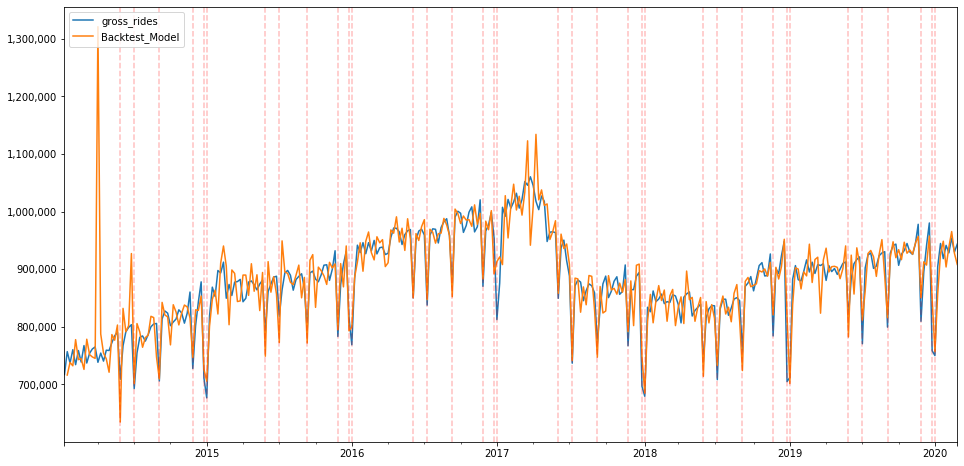

In [136]:
# plot model backtest

plt.clf()

ts.plot_fit(train[series], backtest, train);

In [137]:
predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(short_exog)-1,
                               exog_data=short_exog)

In [138]:
# make the OOS intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=short_horizon,
                                     exog_data = short_exog)

In [139]:
intervals

Predictions  lower gross_rides  upper gross_rides
2020-03-08   959,514.95         897,708.42       1,021,321.49
2020-03-15   989,258.34         902,033.12       1,076,483.55
2020-03-22   918,410.79         811,869.52       1,024,952.07
2020-03-29   923,012.08         800,073.08       1,045,951.09
2020-04-05   936,767.16         799,189.82       1,074,344.50
2020-04-12   958,520.27         807,742.76       1,109,297.77
2020-04-19   952,423.20         789,672.55       1,115,173.84
2020-04-26   985,479.74         811,596.17       1,159,363.32
2020-05-03   966,411.13         781,928.18       1,150,894.08
2020-05-10   974,354.99         779,799.85       1,168,910.14
2020-05-17   950,785.28         746,766.75       1,154,803.81
2020-05-24   977,106.80         764,117.35       1,190,096.25
2020-05-31   885,501.65         646,242.81       1,124,760.50

In [140]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=short_horizon,
                           exog_data = short_exog)

In [141]:
# make the final df for merging

gross_rides_fcast = ts.oos_weekly_df(model=model,
                               steps_ahead=short_horizon,
                               exog_data = short_exog,
                               series = series,
                               add_date = True)

gross_rides_fcast

gross_rides  lower_gross_rides  upper_gross_rides  fcast_date
2020-03-08   959,514.95         897,708.42       1,021,321.49  2020-03-03
2020-03-15   989,258.34         902,033.12       1,076,483.55  2020-03-03
2020-03-22   918,410.79         811,869.52       1,024,952.07  2020-03-03
2020-03-29   923,012.08         800,073.08       1,045,951.09  2020-03-03
2020-04-05   936,767.16         799,189.82       1,074,344.50  2020-03-03
2020-04-12   958,520.27         807,742.76       1,109,297.77  2020-03-03
2020-04-19   952,423.20         789,672.55       1,115,173.84  2020-03-03
2020-04-26   985,479.74         811,596.17       1,159,363.32  2020-03-03
2020-05-03   966,411.13         781,928.18       1,150,894.08  2020-03-03
2020-05-10   974,354.99         779,799.85       1,168,910.14  2020-03-03
2020-05-17   950,785.28         746,766.75       1,154,803.81  2020-03-03
2020-05-24   977,106.80         764,117.35       1,190,096.25  2020-03-03
2020-05-31   885,501.65         646,242.81       1,124,760.50  2020-03-03

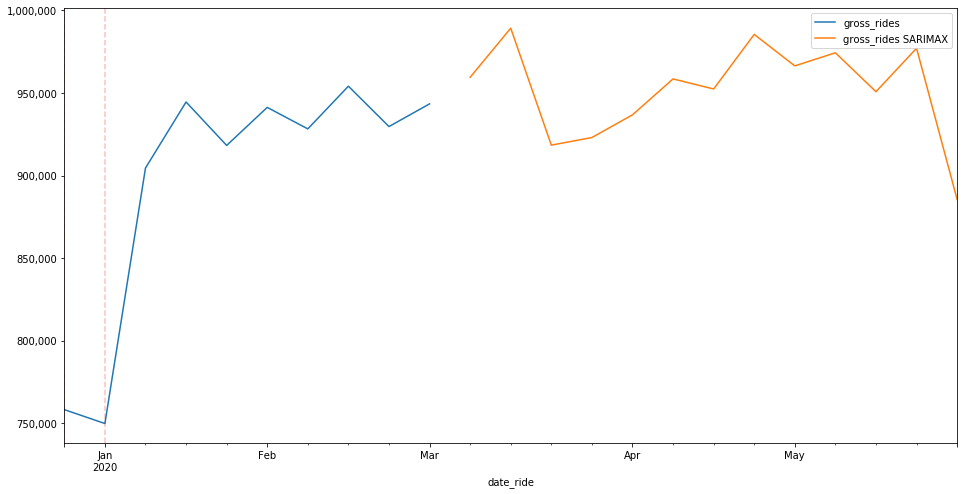

In [142]:
# oos prediction plot

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=oos_exog,
                   vp=False)

# Riders - OOS

In [143]:
series = 'riders'

In [144]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             riders   No. Observations:                  321
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3387.859
Date:                            Tue, 03 Mar 2020   AIC                           6795.718
Time:                                    16:03:12   BIC                           6833.019
Sample:                                01-12-2014   HQIC                          6810.633
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.437e+04   1702.047    -31.942      0.000   -5.77e+04    -5.1e+04
ar.L1          0.3763      0.347      1.086      0.277      -0.303       1.056
ar.L2         -0.5806      0.196     -2.967      0.003      -0.964      -0.197
ma.L1         -0.4791      0.357     -1.343      0.179      -1.178       0.220
ma.L2          0.5185      0.228      2.272      0.023       0.071       0.966
ar.S.L12       0.7163      0.178      4.026      0.000       0.368       1.065
ar.S.L24      -0.2803      0.066     -4.252      0.000      -0.409      -0.151
ma.S.L12      -1.2360      0.183     -6.772      0.000      -1.594      -0.878
ma.S.L24       0.4018      0.164      2.448      0.014       0.080       0.723
sigma2      2.228e+08      0.022   1.02e+10      0.000    2.23e+08    2.23e+08
===================================================================================
Ljung-Box (Q):                      162.69   Jarque-Bera (JB):                60.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.66
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.71e+26. Standard errors may be unstable.
"""

In [145]:
ts.get_dw(model)

1.383626651220288

In [146]:
# make backtest

backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

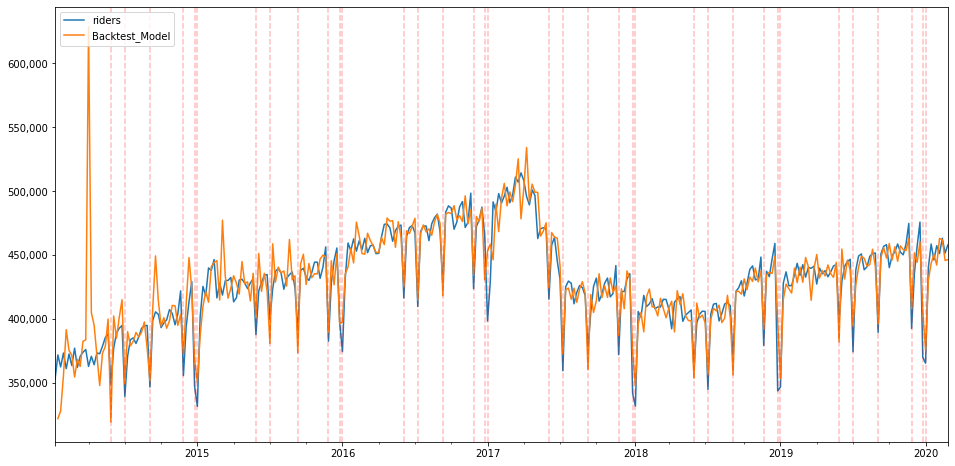

In [147]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [148]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train),
                               end= len(train) + len(short_exog)-1,
                               exog_data=short_exog)

In [149]:
# make the OOS intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=short_horizon,
                                     exog_data = short_exog)

In [150]:
intervals

Predictions  lower riders  upper riders
2020-03-08   467,456.31    438,203.72    496,708.90
2020-03-15   475,516.59    436,214.50    514,818.67
2020-03-22   450,871.62    405,182.73    496,560.51
2020-03-29   451,022.58    399,444.67    502,600.48
2020-04-05   462,849.17    405,140.49    520,557.85
2020-04-12   469,425.67    406,027.18    532,824.17
2020-04-19   463,667.45    395,423.88    531,911.02
2020-04-26   470,524.62    397,959.47    543,089.77
2020-05-03   469,131.30    392,372.21    545,890.39
2020-05-10   474,483.66    393,599.67    555,367.65
2020-05-17   464,304.98    379,505.04    549,104.92
2020-05-24   469,672.17    381,211.32    558,133.03
2020-05-31   421,708.19    324,974.22    518,442.16

In [151]:
conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=short_horizon,
                           exog_data = short_exog)

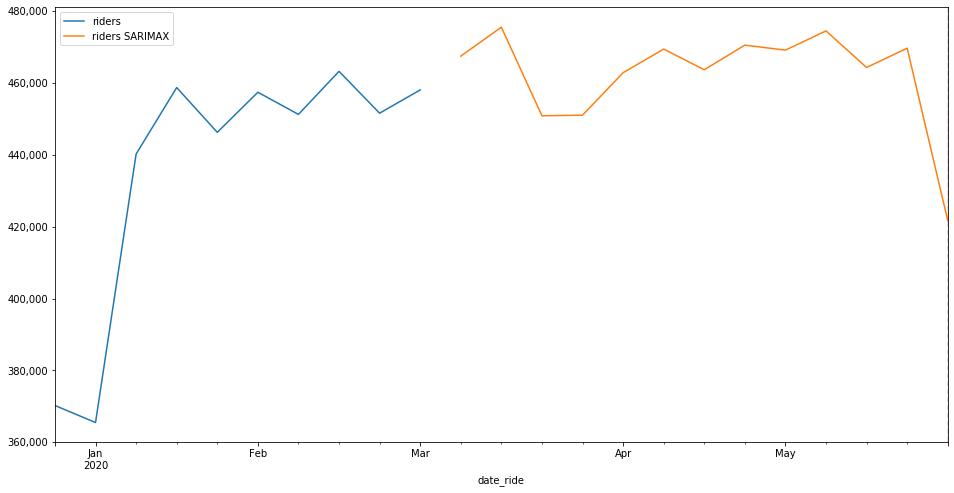

In [152]:
# oos prediction plot

ts.prediction_plot(series=test[series],
                   predictions=predictions,
                   wdf=vpdf,
                   holiday_df=short_exog,
                   vp=False)

In [153]:
# make the final df for merging

riders_fcast = ts.oos_weekly_df(model=model,
                               steps_ahead=short_horizon,
                               exog_data = short_exog,
                               series = series,
                               add_date = False)

riders_fcast

riders  lower_riders  upper_riders
2020-03-08 467,456.31    438,203.72    496,708.90
2020-03-15 475,516.59    436,214.50    514,818.67
2020-03-22 450,871.62    405,182.73    496,560.51
2020-03-29 451,022.58    399,444.67    502,600.48
2020-04-05 462,849.17    405,140.49    520,557.85
2020-04-12 469,425.67    406,027.18    532,824.17
2020-04-19 463,667.45    395,423.88    531,911.02
2020-04-26 470,524.62    397,959.47    543,089.77
2020-05-03 469,131.30    392,372.21    545,890.39
2020-05-10 474,483.66    393,599.67    555,367.65
2020-05-17 464,304.98    379,505.04    549,104.92
2020-05-24 469,672.17    381,211.32    558,133.03
2020-05-31 421,708.19    324,974.22    518,442.16

# Begin VP Series

## Reset Values for VP Train

In [154]:
# set the ranges

# make the training set
train = vpdf.copy()

# set the end point
end = len(train)

# set the truncation point to excude vp lag
print(vp_lag_wks)

train.tail()

10


holiday  gross_rides  vp_rides      vp_costs  vp_miles  \
date_ride                                                            
2019-11-24        0       977888    676430 20,722,037.66   8260713   
2019-12-01        1       809371    455784 14,144,575.45   5389185   
2019-12-08        0       894946    605317 18,723,561.45   7399818   
2019-12-15        0       941193    642577 19,770,739.31   7871431   
2019-12-22        0       980192    661529 20,365,489.62   8042387   

            vp_ambulatory_rides  vp_ambulatory_costs  vp_ambulatory_miles  \
date_ride                                                                   
2019-11-24               816597        14,475,421.82        10,048,889.00   
2019-12-01               662252         9,517,369.50         7,769,336.00   
2019-12-08               745146        13,059,427.08         9,186,129.00   
2019-12-15               786898        13,912,388.74         9,710,523.00   
2019-12-22               816024        14,208,297.41        10,018,564.00   

            vp_stretcher_rides  vp_stretcher_costs  vp_stretcher_miles  \
date_ride                                                                
2019-11-24               16591        1,984,552.36          163,594.00   
2019-12-01               15335        1,572,183.80          137,991.00   
2019-12-08               15645        1,777,666.92          145,711.00   
2019-12-15               16268        1,871,633.36          157,227.00   
2019-12-22               17489        1,954,392.97          161,607.00   

            vp_wheelchair_rides  vp_wheelchair_costs  vp_wheelchair_miles  \
date_ride                                                                   
2019-11-24               144700         4,262,063.48         1,330,803.00   
2019-12-01               131784         3,055,022.15         1,129,006.00   
2019-12-08               134155         3,886,467.45         1,237,056.00   
2019-12-15               138027         3,986,717.21         1,263,769.00   
2019-12-22               146679         4,202,799.24         1,330,414.00   

            riders  cpm  
date_ride                
2019-11-24  474834 2.51  
2019-12-01  392688 2.62  
2019-12-08  435617 2.53  
2019-12-15  457379 2.51  
2019-12-22  475897 2.53

In [176]:
# reset exog
# roll forward what has occurred
# roll_fwd = 14



oos_exog = oos.iloc[month_step:short_horizon + roll_fwd]

horizon = len(oos_exog)

oos_exog

holiday
date               
2019-12-29        1
2020-01-05        1
2020-01-12        0
2020-01-19        0
2020-01-26        0
2020-02-02        0
2020-02-09        0
2020-02-16        0
2020-02-23        0
2020-03-01        0
2020-03-08        0
2020-03-15        0
2020-03-22        0
2020-03-29        0
2020-04-05        0
2020-04-12        0
2020-04-19        0
2020-04-26        0
2020-05-03        0
2020-05-10        0
2020-05-17        0
2020-05-24        0
2020-05-31        1

# Ver Pd Rides

In [156]:
series = 'vp_rides'

In [161]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_rides   No. Observations:                  311
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 5)   Log Likelihood               -3597.029
Date:                           Tue, 03 Mar 2020   AIC                           7206.058
Time:                                   16:04:48   BIC                           7228.380
Sample:                               01-12-2014   HQIC                          7214.986
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.267e+05   3586.736    -35.325      0.000   -1.34e+05    -1.2e+05
ar.L1          0.1141      0.076      1.498      0.134      -0.035       0.263
ma.L1         -0.5577      0.070     -8.016      0.000      -0.694      -0.421
ar.S.L5       -0.4617      0.033    -14.020      0.000      -0.526      -0.397
ar.S.L10      -0.2183      0.027     -8.190      0.000      -0.271      -0.166
sigma2      1.122e+09      0.051   2.22e+10      0.000    1.12e+09    1.12e+09
===================================================================================
Ljung-Box (Q):                       71.45   Jarque-Bera (JB):                42.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.73
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+26. Standard errors may be unstable.
"""

In [162]:
ts.get_dw(model)

1.3896111242789237

In [163]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

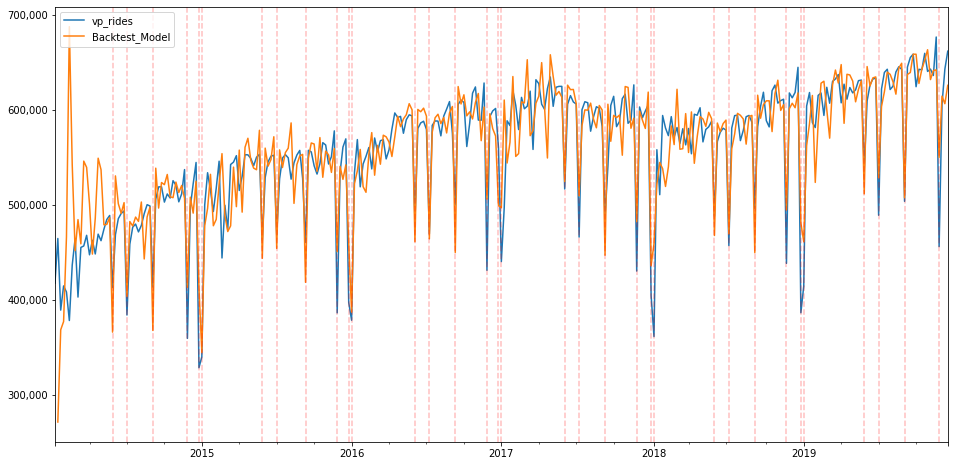

In [164]:
# plot backtest

ts.plot_fit(train[series], backtest, train);

In [165]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [177]:
# make prediction intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [178]:
intervals

Predictions  lower vp_rides  upper vp_rides
2019-12-29   542,010.63      476,359.71      607,661.54
2020-01-05   495,845.28      420,717.38      570,973.19
2020-01-12   630,729.99      548,591.54      712,868.44
2020-01-19   643,883.66      555,428.99      732,338.34
2020-01-26   656,442.52      562,108.55      750,776.49
2020-02-02   670,065.80      553,709.20      786,422.40
2020-02-09   626,125.53      498,498.41      753,752.65
2020-02-16   631,923.35      494,612.91      769,233.79
2020-02-23   648,610.36      502,326.35      794,894.37
2020-03-01   658,517.13      503,786.66      813,247.60
2020-03-08   676,440.65      499,695.40      853,185.89
2020-03-15   621,043.85      430,980.03      811,107.67
2020-03-22   631,140.05      429,236.19      833,043.91
2020-03-29   651,457.75      438,435.22      864,480.27
2020-04-05   663,984.50      440,402.54      887,566.47
2020-04-12   678,517.03      429,485.20      927,548.86
2020-04-19   627,923.99      362,738.87      893,109.10
2020-04-26   636,556.13      356,826.62      916,285.63
2020-05-03   654,426.27      360,945.13      947,907.41
2020-05-10   666,322.29      359,713.62      972,930.97
2020-05-17   681,481.76      349,429.15    1,013,534.37
2020-05-24   631,171.61      281,279.71      981,063.51
2020-05-31   512,839.00      146,558.56      879,119.44

In [179]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

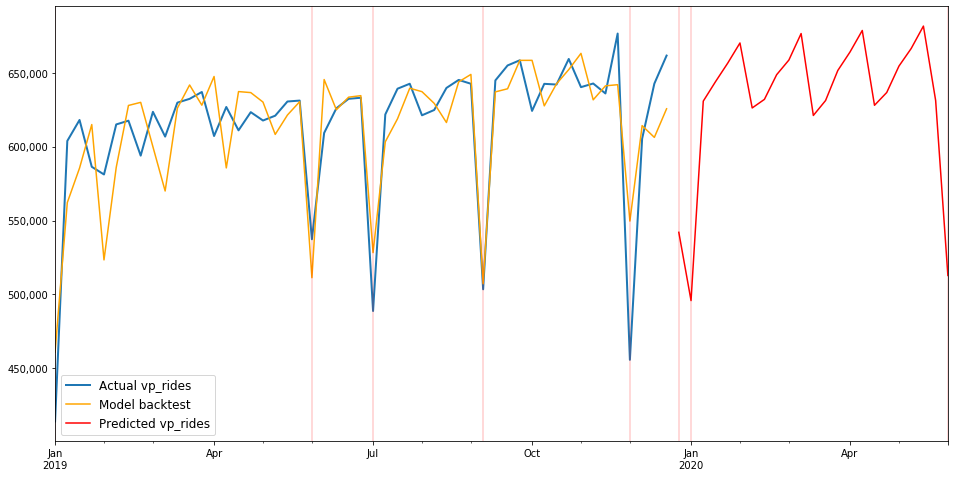

In [180]:
# oos plot

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01');

In [181]:
# make final series

vp_rides = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_rides

vp_rides  lower_vp_rides  upper_vp_rides
2019-12-29 542,010.63      476,359.71      607,661.54
2020-01-05 495,845.28      420,717.38      570,973.19
2020-01-12 630,729.99      548,591.54      712,868.44
2020-01-19 643,883.66      555,428.99      732,338.34
2020-01-26 656,442.52      562,108.55      750,776.49
2020-02-02 670,065.80      553,709.20      786,422.40
2020-02-09 626,125.53      498,498.41      753,752.65
2020-02-16 631,923.35      494,612.91      769,233.79
2020-02-23 648,610.36      502,326.35      794,894.37
2020-03-01 658,517.13      503,786.66      813,247.60
2020-03-08 676,440.65      499,695.40      853,185.89
2020-03-15 621,043.85      430,980.03      811,107.67
2020-03-22 631,140.05      429,236.19      833,043.91
2020-03-29 651,457.75      438,435.22      864,480.27
2020-04-05 663,984.50      440,402.54      887,566.47
2020-04-12 678,517.03      429,485.20      927,548.86
2020-04-19 627,923.99      362,738.87      893,109.10
2020-04-26 636,556.13      356,826.62      916,285.63
2020-05-03 654,426.27      360,945.13      947,907.41
2020-05-10 666,322.29      359,713.62      972,930.97
2020-05-17 681,481.76      349,429.15    1,013,534.37
2020-05-24 631,171.61      281,279.71      981,063.51
2020-05-31 512,839.00      146,558.56      879,119.44

# Ver Pd Costs

In [182]:
series = 'vp_costs'

In [218]:
model = ts.build_model(train[series],
                       p=0,
                       d=1,
                       q=2,
                       S=5,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_costs   No. Observations:                  311
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 5)   Log Likelihood               -4601.779
Date:                           Tue, 03 Mar 2020   AIC                           9215.558
Time:                                   16:14:08   BIC                           9237.880
Sample:                               01-12-2014   HQIC                          9224.486
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -3.492e+06   1.27e+05    -27.579      0.000   -3.74e+06   -3.24e+06
ma.L1         -0.4199      0.051     -8.180      0.000      -0.521      -0.319
ma.L2         -0.0600      0.063     -0.948      0.343      -0.184       0.064
ar.S.L5        0.2395      0.072      3.317      0.001       0.098       0.381
ma.S.L5       -0.9112      0.060    -15.223      0.000      -1.029      -0.794
sigma2      1.022e+12      0.057   1.78e+13      0.000    1.02e+12    1.02e+12
===================================================================================
Ljung-Box (Q):                       57.01   Jarque-Bera (JB):                51.05
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.72
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.5e+28. Standard errors may be unstable.
"""

In [219]:
ts.get_dw(model)

1.4494577573358447

In [220]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

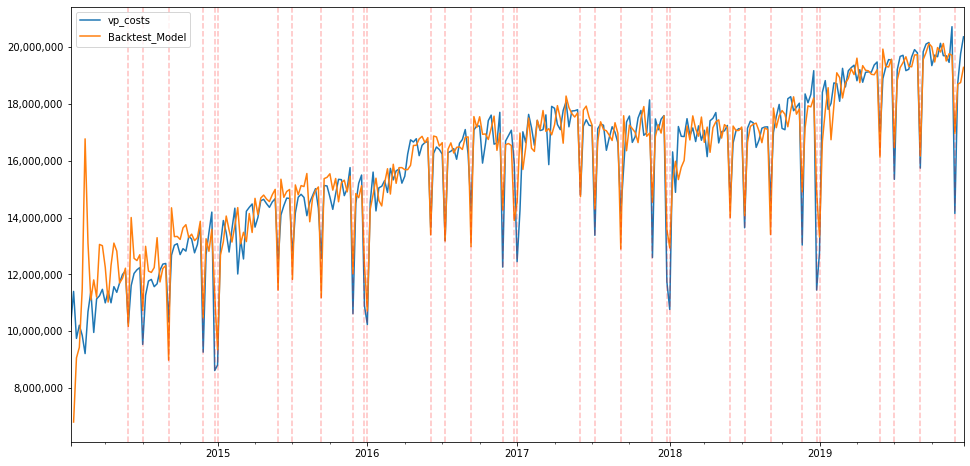

In [221]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [222]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [223]:
# make prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [224]:
intervals

Predictions  lower vp_costs  upper vp_costs
2019-12-29 16,908,782.51   14,927,729.93   18,889,835.09
2020-01-05 15,838,036.88   13,547,778.94   18,128,294.82
2020-01-12 19,735,010.91   17,223,671.41   22,246,350.40
2020-01-19 19,965,380.06   17,250,905.74   22,679,854.38
2020-01-26 20,167,995.26   17,264,563.64   23,071,426.88
2020-02-02 20,377,704.57   17,022,922.54   23,732,486.61
2020-02-09 19,848,370.97   16,210,257.63   23,486,484.30
2020-02-16 20,090,184.79   16,203,180.31   23,977,189.27
2020-02-23 20,124,932.63   16,004,041.99   24,245,823.28
2020-03-01 20,233,633.58   15,891,436.68   24,575,830.47
2020-03-08 20,485,157.32   15,821,961.15   25,148,353.50
2020-03-15 20,085,488.99   15,167,972.73   25,003,005.25
2020-03-22 20,288,184.19   15,134,857.00   25,441,511.38
2020-03-29 20,276,081.78   14,897,271.73   25,654,891.82
2020-04-05 20,362,290.76   14,767,077.57   25,957,503.95
2020-04-12 20,623,828.84   14,747,317.41   26,500,340.26
2020-04-19 20,255,214.64   14,140,751.10   26,369,678.19
2020-04-26 20,448,541.14   14,109,108.92   26,787,973.36
2020-05-03 20,425,218.34   13,868,531.73   26,981,904.95
2020-05-10 20,506,040.62   13,739,071.36   27,273,009.88
2020-05-17 20,769,977.08   13,738,377.73   27,801,576.43
2020-05-24 20,408,800.19   13,147,643.28   27,669,957.09
2020-05-31 17,108,060.94    9,627,815.93   24,588,305.95

In [225]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

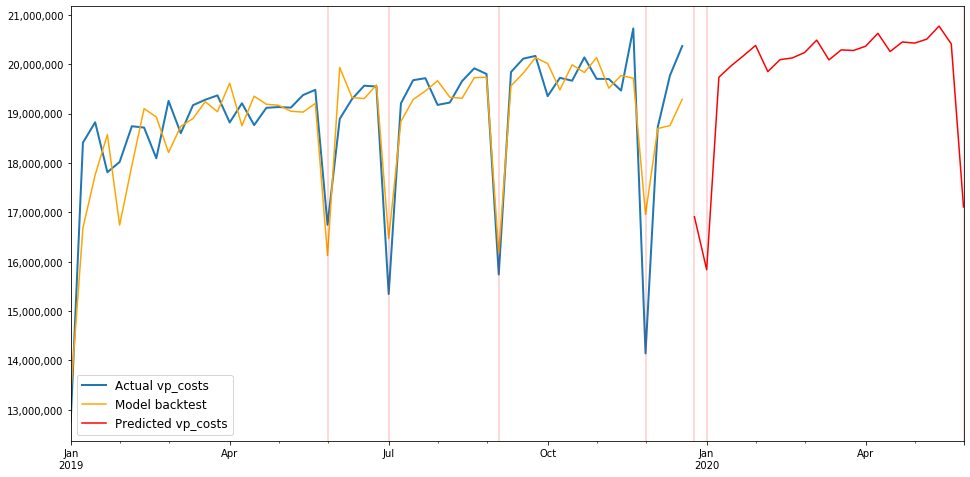

In [226]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [227]:
# make final series

vp_costs = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_costs

vp_costs  lower_vp_costs  upper_vp_costs
2019-12-29 16,908,782.51   14,927,729.93   18,889,835.09
2020-01-05 15,838,036.88   13,547,778.94   18,128,294.82
2020-01-12 19,735,010.91   17,223,671.41   22,246,350.40
2020-01-19 19,965,380.06   17,250,905.74   22,679,854.38
2020-01-26 20,167,995.26   17,264,563.64   23,071,426.88
2020-02-02 20,377,704.57   17,022,922.54   23,732,486.61
2020-02-09 19,848,370.97   16,210,257.63   23,486,484.30
2020-02-16 20,090,184.79   16,203,180.31   23,977,189.27
2020-02-23 20,124,932.63   16,004,041.99   24,245,823.28
2020-03-01 20,233,633.58   15,891,436.68   24,575,830.47
2020-03-08 20,485,157.32   15,821,961.15   25,148,353.50
2020-03-15 20,085,488.99   15,167,972.73   25,003,005.25
2020-03-22 20,288,184.19   15,134,857.00   25,441,511.38
2020-03-29 20,276,081.78   14,897,271.73   25,654,891.82
2020-04-05 20,362,290.76   14,767,077.57   25,957,503.95
2020-04-12 20,623,828.84   14,747,317.41   26,500,340.26
2020-04-19 20,255,214.64   14,140,751.10   26,369,678.19
2020-04-26 20,448,541.14   14,109,108.92   26,787,973.36
2020-05-03 20,425,218.34   13,868,531.73   26,981,904.95
2020-05-10 20,506,040.62   13,739,071.36   27,273,009.88
2020-05-17 20,769,977.08   13,738,377.73   27,801,576.43
2020-05-24 20,408,800.19   13,147,643.28   27,669,957.09
2020-05-31 17,108,060.94    9,627,815.93   24,588,305.95

# Ver Pd Miles

In [228]:
series = 'vp_miles'

In [229]:
model = ts.build_model(train[series],
                       p=1,
                       d=1,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          vp_miles   No. Observations:                  311
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 5)   Log Likelihood               -4480.726
Date:                           Tue, 03 Mar 2020   AIC                           8973.452
Time:                                   16:14:50   BIC                           8995.774
Sample:                               01-12-2014   HQIC                          8982.380
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.505e+06   6.87e+04    -21.900      0.000   -1.64e+06   -1.37e+06
ar.L1          0.1344      0.076      1.772      0.076      -0.014       0.283
ma.L1         -0.6719      0.069     -9.702      0.000      -0.808      -0.536
ar.S.L5       -0.5110      0.033    -15.403      0.000      -0.576      -0.446
ar.S.L10      -0.2773      0.034     -8.057      0.000      -0.345      -0.210
sigma2      4.189e+11      0.163   2.57e+12      0.000    4.19e+11    4.19e+11
===================================================================================
Ljung-Box (Q):                       68.92   Jarque-Bera (JB):              2588.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.17e+26. Standard errors may be unstable.
"""

In [230]:
ts.get_dw(model)

1.5783720096024663

In [231]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

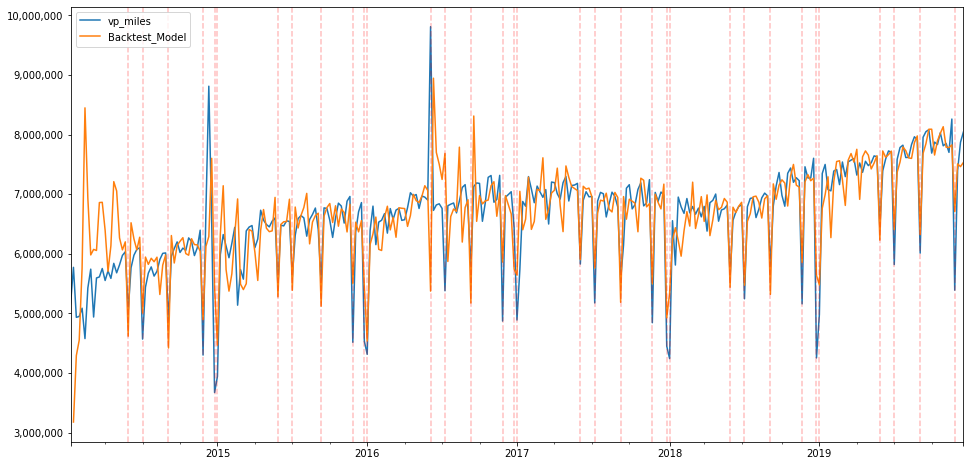

In [232]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [233]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [234]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [235]:
intervals

Predictions  lower vp_miles  upper vp_miles
2019-12-29 6,621,549.28    5,352,993.42    7,890,105.15
2020-01-05 5,985,466.94    4,587,813.09    7,383,120.79
2020-01-12 7,690,138.18    6,207,407.92    9,172,868.44
2020-01-19 7,820,520.25    6,261,195.12    9,379,845.37
2020-01-26 7,919,930.76    6,288,089.95    9,551,771.57
2020-02-02 8,080,361.12    6,111,751.78   10,048,970.46
2020-02-09 7,504,920.24    5,391,921.80    9,617,918.68
2020-02-16 7,659,926.52    5,426,702.74    9,893,150.31
2020-02-23 7,845,199.62    5,499,748.79   10,190,650.44
2020-03-01 7,891,969.84    5,439,658.66   10,344,281.02
2020-03-08 8,145,088.43    5,362,102.31   10,928,074.55
2020-03-15 7,336,094.78    4,381,153.05   10,291,036.50
2020-03-22 7,598,813.90    4,494,925.60   10,702,702.20
2020-03-29 7,850,653.01    4,606,345.86   11,094,960.17
2020-04-05 7,944,160.69    4,565,483.89   11,322,837.50
2020-04-12 8,128,739.16    4,331,402.20   11,926,076.11
2020-04-19 7,422,277.85    3,405,779.45   11,438,776.25
2020-04-26 7,642,368.12    3,435,397.61   11,849,338.64
2020-05-03 7,844,971.56    3,457,968.78   12,231,974.33
2020-05-10 7,929,192.09    3,369,540.71   12,488,843.46
2020-05-17 8,123,094.60    3,167,418.06   13,078,771.14
2020-05-24 7,428,997.59    2,231,860.30   12,626,134.87
2020-05-31 6,136,107.77      722,584.72   11,549,630.82

In [236]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

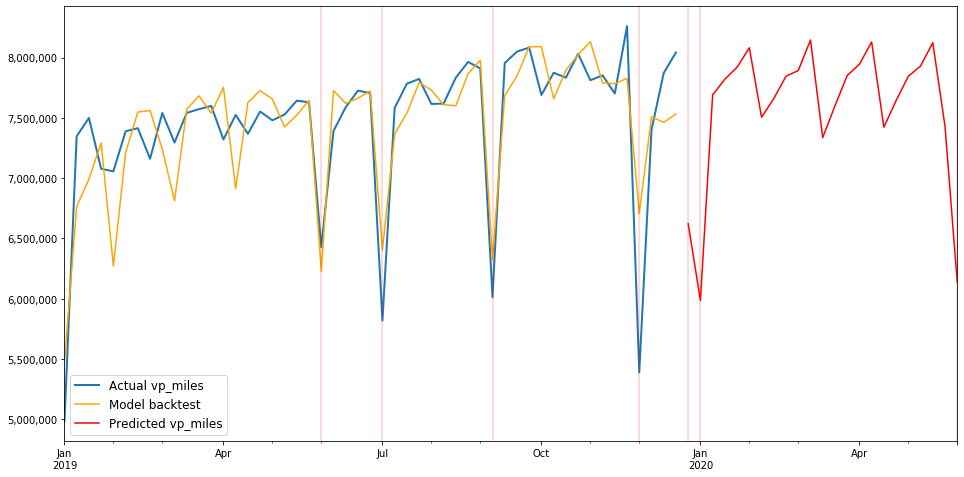

In [237]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01');

In [238]:
# make final series

vp_miles = ts.oos_weekly_df(model=model,
                            steps_ahead=horizon,
                            exog_data = oos_exog,
                            series = series,
                            add_date = False)

vp_miles

vp_miles  lower_vp_miles  upper_vp_miles
2019-12-29 6,621,549.28    5,352,993.42    7,890,105.15
2020-01-05 5,985,466.94    4,587,813.09    7,383,120.79
2020-01-12 7,690,138.18    6,207,407.92    9,172,868.44
2020-01-19 7,820,520.25    6,261,195.12    9,379,845.37
2020-01-26 7,919,930.76    6,288,089.95    9,551,771.57
2020-02-02 8,080,361.12    6,111,751.78   10,048,970.46
2020-02-09 7,504,920.24    5,391,921.80    9,617,918.68
2020-02-16 7,659,926.52    5,426,702.74    9,893,150.31
2020-02-23 7,845,199.62    5,499,748.79   10,190,650.44
2020-03-01 7,891,969.84    5,439,658.66   10,344,281.02
2020-03-08 8,145,088.43    5,362,102.31   10,928,074.55
2020-03-15 7,336,094.78    4,381,153.05   10,291,036.50
2020-03-22 7,598,813.90    4,494,925.60   10,702,702.20
2020-03-29 7,850,653.01    4,606,345.86   11,094,960.17
2020-04-05 7,944,160.69    4,565,483.89   11,322,837.50
2020-04-12 8,128,739.16    4,331,402.20   11,926,076.11
2020-04-19 7,422,277.85    3,405,779.45   11,438,776.25
2020-04-26 7,642,368.12    3,435,397.61   11,849,338.64
2020-05-03 7,844,971.56    3,457,968.78   12,231,974.33
2020-05-10 7,929,192.09    3,369,540.71   12,488,843.46
2020-05-17 8,123,094.60    3,167,418.06   13,078,771.14
2020-05-24 7,428,997.59    2,231,860.30   12,626,134.87
2020-05-31 6,136,107.77      722,584.72   11,549,630.82

# Ver Pd Amb Rides

In [239]:
series = 'vp_ambulatory_rides'

In [240]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=4,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_rides   No. Observations:                  311
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 4)   Log Likelihood               -3531.883
Date:                           Tue, 03 Mar 2020   AIC                           7079.766
Time:                                   16:24:30   BIC                           7109.554
Sample:                               01-12-2014   HQIC                          7091.679
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -9.468e+04   2665.063    -35.525      0.000   -9.99e+04   -8.95e+04
ar.L1         -0.9976      0.085    -11.685      0.000      -1.165      -0.830
ar.L2         -0.1711      0.028     -6.139      0.000      -0.226      -0.116
ma.L1          0.9148      0.098      9.295      0.000       0.722       1.108
ar.S.L4        0.5330      0.056      9.601      0.000       0.424       0.642
ar.S.L8       -0.0189      0.028     -0.666      0.505      -0.075       0.037
ma.S.L4       -0.9503      0.049    -19.362      0.000      -1.046      -0.854
sigma2      7.445e+08      0.070   1.06e+10      0.000    7.44e+08    7.44e+08
===================================================================================
Ljung-Box (Q):                      110.42   Jarque-Bera (JB):               231.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.55
Prob(H) (two-sided):                  0.41   Kurtosis:                         7.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+25. Standard errors may be unstable.
"""

In [241]:
ts.get_dw(model)

1.3147551268931963

In [242]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

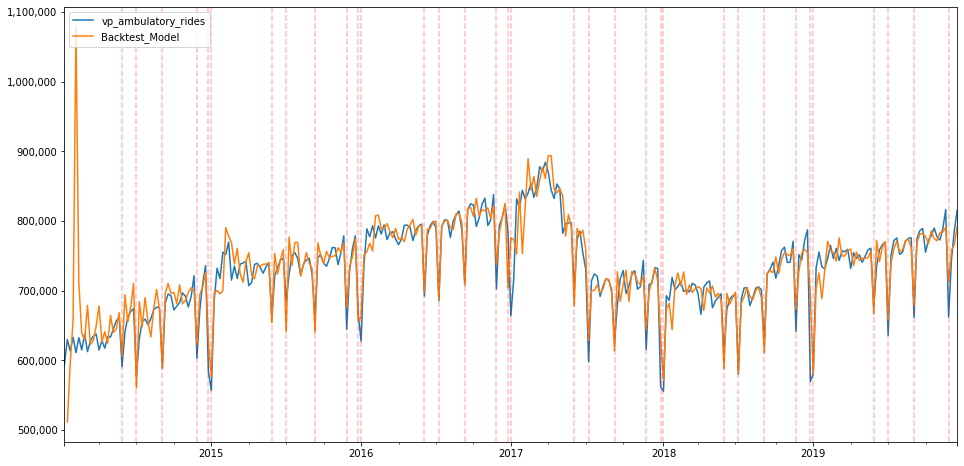

In [243]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [244]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [245]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [246]:
intervals

Predictions  lower vp_ambulatory_rides  upper vp_ambulatory_rides
2019-12-29   685,154.47                 631,676.05                 738,632.89
2020-01-05   677,285.34                 604,719.03                 749,851.66
2020-01-12   802,686.38                 717,658.48                 887,714.27
2020-01-19   815,380.24                 716,843.61                 913,916.87
2020-01-26   793,791.80                 669,164.78                 918,418.82
2020-02-02   789,875.08                 643,151.76                 936,598.40
2020-02-09   812,320.74                 648,984.37                 975,657.11
2020-02-16   817,846.32                 637,173.51                 998,519.13
2020-02-23   802,306.24                 600,004.39               1,004,608.09
2020-03-01   801,432.63                 578,765.61               1,024,099.64
2020-03-08   818,886.87                 579,218.70               1,058,555.03
2020-03-15   821,515.31                 564,553.55               1,078,477.07
2020-03-22   808,446.22                 532,267.21               1,084,625.23
2020-03-29   809,489.93                 514,797.20               1,104,182.66
2020-04-05   824,152.73                 513,032.19               1,135,273.26
2020-04-12   825,596.59                 498,018.01               1,153,175.16
2020-04-19   813,555.95                 468,351.54               1,158,760.35
2020-04-26   815,699.25                 453,410.17               1,177,988.33
2020-05-03   828,863.56                 450,874.33               1,206,852.79
2020-05-10   829,812.70                 436,210.53               1,223,414.88
2020-05-17   818,209.83                 408,094.46               1,228,325.20
2020-05-24   820,952.34                 394,784.47               1,247,120.22
2020-05-31   738,656.88                 297,434.46               1,179,879.31

In [247]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

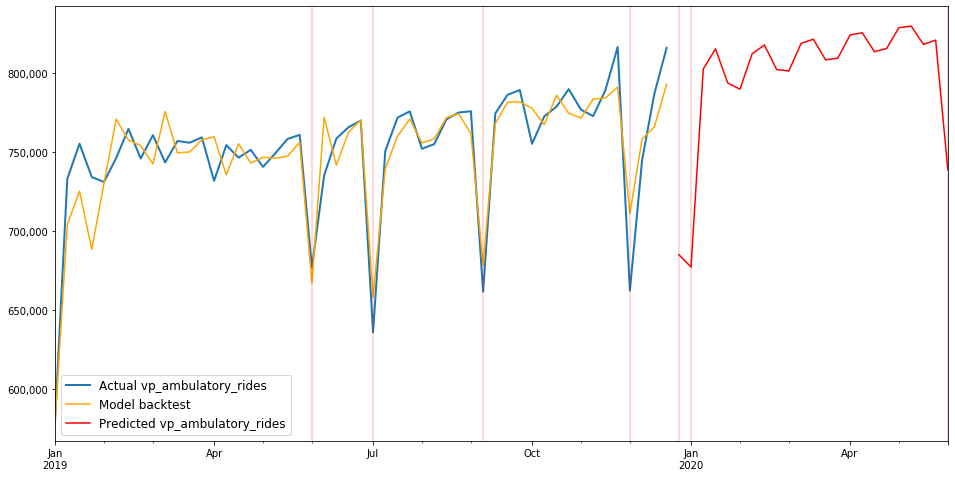

In [248]:
# oos plot

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [249]:
# make final series

vp_ambulatory_rides = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_rides

vp_ambulatory_rides  lower_vp_ambulatory_rides  \
2019-12-29           685,154.47                 631,676.05   
2020-01-05           677,285.34                 604,719.03   
2020-01-12           802,686.38                 717,658.48   
2020-01-19           815,380.24                 716,843.61   
2020-01-26           793,791.80                 669,164.78   
2020-02-02           789,875.08                 643,151.76   
2020-02-09           812,320.74                 648,984.37   
2020-02-16           817,846.32                 637,173.51   
2020-02-23           802,306.24                 600,004.39   
2020-03-01           801,432.63                 578,765.61   
2020-03-08           818,886.87                 579,218.70   
2020-03-15           821,515.31                 564,553.55   
2020-03-22           808,446.22                 532,267.21   
2020-03-29           809,489.93                 514,797.20   
2020-04-05           824,152.73                 513,032.19   
2020-04-12           825,596.59                 498,018.01   
2020-04-19           813,555.95                 468,351.54   
2020-04-26           815,699.25                 453,410.17   
2020-05-03           828,863.56                 450,874.33   
2020-05-10           829,812.70                 436,210.53   
2020-05-17           818,209.83                 408,094.46   
2020-05-24           820,952.34                 394,784.47   
2020-05-31           738,656.88                 297,434.46   

            upper_vp_ambulatory_rides  
2019-12-29                 738,632.89  
2020-01-05                 749,851.66  
2020-01-12                 887,714.27  
2020-01-19                 913,916.87  
2020-01-26                 918,418.82  
2020-02-02                 936,598.40  
2020-02-09                 975,657.11  
2020-02-16                 998,519.13  
2020-02-23               1,004,608.09  
2020-03-01               1,024,099.64  
2020-03-08               1,058,555.03  
2020-03-15               1,078,477.07  
2020-03-22               1,084,625.23  
2020-03-29               1,104,182.66  
2020-04-05               1,135,273.26  
2020-04-12               1,153,175.16  
2020-04-19               1,158,760.35  
2020-04-26               1,177,988.33  
2020-05-03               1,206,852.79  
2020-05-10               1,223,414.88  
2020-05-17               1,228,325.20  
2020-05-24               1,247,120.22  
2020-05-31               1,179,879.31

# Ver Pd Amb Costs

In [250]:
series = 'vp_ambulatory_costs'

In [251]:
model = ts.build_model(train[series],
                       p=1,
                       d=0,
                       q=1,
                       S=5,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_costs   No. Observations:                  311
Model:             SARIMAX(1, 0, 1)x(2, 1, 0, 5)   Log Likelihood               -4505.562
Date:                           Tue, 03 Mar 2020   AIC                           9023.123
Time:                                   16:27:49   BIC                           9045.465
Sample:                               01-12-2014   HQIC                          9032.058
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -2.769e+06   7.18e+04    -38.583      0.000   -2.91e+06   -2.63e+06
ar.L1          0.9200      0.018     50.505      0.000       0.884       0.956
ma.L1         -0.7988      0.041    -19.347      0.000      -0.880      -0.718
ar.S.L5       -0.4141      0.048     -8.563      0.000      -0.509      -0.319
ar.S.L10      -0.1875      0.045     -4.141      0.000      -0.276      -0.099
sigma2      4.236e+11      0.021   2.06e+13      0.000    4.24e+11    4.24e+11
===================================================================================
Ljung-Box (Q):                       61.43   Jarque-Bera (JB):                29.57
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.41
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.83e+29. Standard errors may be unstable.
"""

In [252]:
ts.get_dw(model)

0.7923868983351311

In [253]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

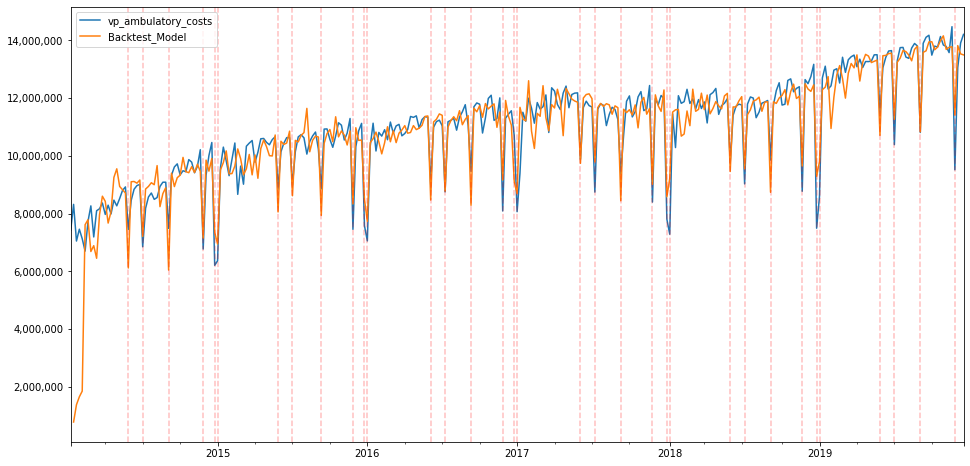

In [254]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [255]:
# oos predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [256]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [257]:
intervals

Predictions  lower vp_ambulatory_costs  upper vp_ambulatory_costs
2019-12-29 11,405,181.75              10,129,490.79              12,680,872.71
2020-01-05 10,246,835.87               8,961,817.45              11,531,854.29
2020-01-12 13,418,102.80              12,125,242.78              14,710,962.82
2020-01-19 13,778,794.38              12,479,334.70              15,078,254.06
2020-01-26 13,965,089.82              12,660,070.67              15,270,108.97
2020-02-02 14,144,409.11              12,582,522.46              15,706,295.76
2020-02-09 13,039,645.44              11,465,954.04              14,613,336.83
2020-02-16 13,397,454.01              11,813,840.57              14,981,067.44
2020-02-23 13,793,548.67              12,201,586.16              15,385,511.18
2020-03-01 13,931,617.57              12,332,622.99              15,530,612.15
2020-03-08 14,198,505.22              12,380,634.82              16,016,375.63
2020-03-15 12,879,430.02              11,048,907.15              14,709,952.88
2020-03-22 13,326,332.90              11,485,169.73              15,167,496.07
2020-03-29 13,801,064.48              11,950,943.83              15,651,185.13
2020-04-05 13,980,570.61              12,122,902.66              15,838,238.56
2020-04-12 14,171,982.61              12,067,732.44              16,276,232.77
2020-04-19 12,932,377.59              10,814,180.02              15,050,575.16
2020-04-26 13,351,471.84              11,221,541.42              15,481,402.26
2020-05-03 13,787,657.70              11,647,847.60              15,927,467.80
2020-05-10 13,959,650.49              11,811,514.35              16,107,786.63
2020-05-17 14,166,450.66              11,810,430.87              16,522,470.45
2020-05-24 12,934,632.53              10,564,736.27              15,304,528.80
2020-05-31 10,580,197.30               8,198,620.03              12,961,774.56

In [258]:
# make df for plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

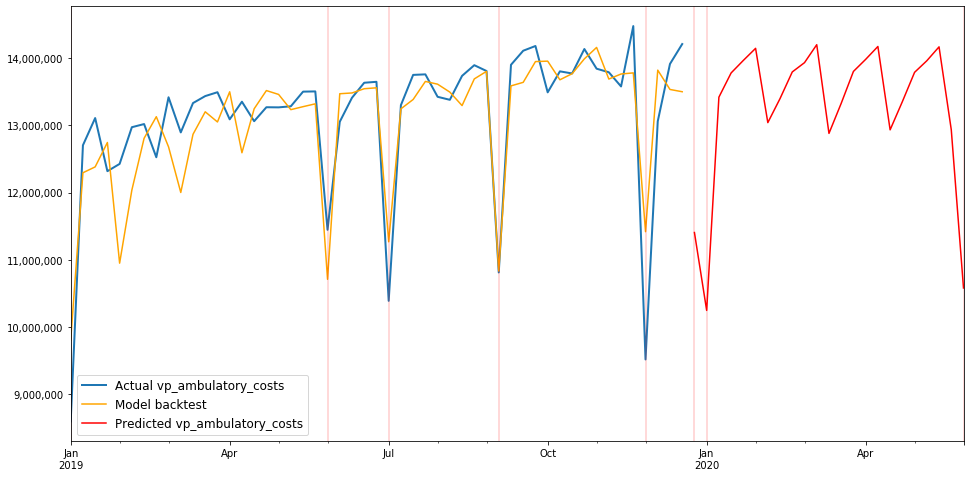

In [259]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [260]:
# make final series

vp_ambulatory_costs = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_costs

vp_ambulatory_costs  lower_vp_ambulatory_costs  \
2019-12-29        11,405,181.75              10,129,490.79   
2020-01-05        10,246,835.87               8,961,817.45   
2020-01-12        13,418,102.80              12,125,242.78   
2020-01-19        13,778,794.38              12,479,334.70   
2020-01-26        13,965,089.82              12,660,070.67   
2020-02-02        14,144,409.11              12,582,522.46   
2020-02-09        13,039,645.44              11,465,954.04   
2020-02-16        13,397,454.01              11,813,840.57   
2020-02-23        13,793,548.67              12,201,586.16   
2020-03-01        13,931,617.57              12,332,622.99   
2020-03-08        14,198,505.22              12,380,634.82   
2020-03-15        12,879,430.02              11,048,907.15   
2020-03-22        13,326,332.90              11,485,169.73   
2020-03-29        13,801,064.48              11,950,943.83   
2020-04-05        13,980,570.61              12,122,902.66   
2020-04-12        14,171,982.61              12,067,732.44   
2020-04-19        12,932,377.59              10,814,180.02   
2020-04-26        13,351,471.84              11,221,541.42   
2020-05-03        13,787,657.70              11,647,847.60   
2020-05-10        13,959,650.49              11,811,514.35   
2020-05-17        14,166,450.66              11,810,430.87   
2020-05-24        12,934,632.53              10,564,736.27   
2020-05-31        10,580,197.30               8,198,620.03   

            upper_vp_ambulatory_costs  
2019-12-29              12,680,872.71  
2020-01-05              11,531,854.29  
2020-01-12              14,710,962.82  
2020-01-19              15,078,254.06  
2020-01-26              15,270,108.97  
2020-02-02              15,706,295.76  
2020-02-09              14,613,336.83  
2020-02-16              14,981,067.44  
2020-02-23              15,385,511.18  
2020-03-01              15,530,612.15  
2020-03-08              16,016,375.63  
2020-03-15              14,709,952.88  
2020-03-22              15,167,496.07  
2020-03-29              15,651,185.13  
2020-04-05              15,838,238.56  
2020-04-12              16,276,232.77  
2020-04-19              15,050,575.16  
2020-04-26              15,481,402.26  
2020-05-03              15,927,467.80  
2020-05-10              16,107,786.63  
2020-05-17              16,522,470.45  
2020-05-24              15,304,528.80  
2020-05-31              12,961,774.56

# Ver Pd Amb Miles

In [261]:
series = 'vp_ambulatory_miles'

In [262]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=4,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_ambulatory_miles   No. Observations:                  311
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -4373.847
Date:                           Tue, 03 Mar 2020   AIC                           8761.694
Time:                                   16:28:28   BIC                           8787.759
Sample:                               01-12-2014   HQIC                          8772.118
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.296e+06    5.2e+04    -24.920      0.000    -1.4e+06   -1.19e+06
ar.L1         -0.4727      0.534     -0.884      0.376      -1.520       0.575
ar.L2         -0.1799      0.085     -2.123      0.034      -0.346      -0.014
ma.L1          0.2951      0.551      0.536      0.592      -0.784       1.374
ar.S.L4        0.2977      0.070      4.253      0.000       0.160       0.435
ma.S.L4       -0.9414      0.045    -20.969      0.000      -1.029      -0.853
sigma2      2.048e+11      0.067   3.04e+12      0.000    2.05e+11    2.05e+11
===================================================================================
Ljung-Box (Q):                       62.82   Jarque-Bera (JB):               567.38
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.51e+27. Standard errors may be unstable.
"""

In [263]:
ts.get_dw(model)

1.3655908301956947

In [264]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

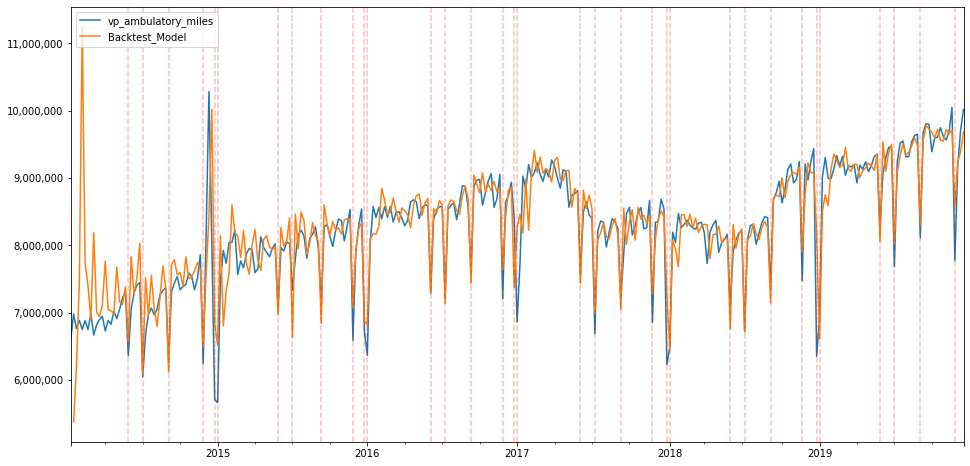

In [265]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [266]:
# oos predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [267]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [268]:
intervals

Predictions  lower vp_ambulatory_miles  upper vp_ambulatory_miles
2019-12-29  8,242,874.54               7,355,887.71               9,129,861.37
2020-01-05  8,348,487.32               7,200,106.90               9,496,867.74
2020-01-12  9,900,144.67               8,583,337.35              11,216,951.99
2020-01-19  9,984,836.90               8,487,432.72              11,482,241.08
2020-01-26  9,729,921.51               7,922,723.42              11,537,119.61
2020-02-02  9,832,908.49               7,790,565.57              11,875,251.41
2020-02-09  9,994,276.48               7,751,729.05              12,236,823.91
2020-02-16 10,018,925.43               7,583,850.20              12,454,000.67
2020-02-23  9,830,477.08               7,163,076.96              12,497,877.21
2020-03-01  9,931,742.26               7,060,821.05              12,802,663.48
2020-03-08 10,065,551.60               7,008,868.20              13,122,235.00
2020-03-15 10,072,245.61               6,836,968.49              13,307,522.73
2020-03-22  9,903,527.15               6,469,058.37              13,337,995.94
2020-03-29 10,004,321.14               6,387,138.24              13,621,504.04
2020-04-05 10,129,917.12               6,341,311.42              13,918,522.83
2020-04-12 10,131,263.02               6,176,630.18              14,085,895.86
2020-04-19  9,968,421.14               5,832,131.40              14,104,710.88
2020-04-26 10,069,073.93               5,762,882.76              14,375,265.11
2020-05-03 10,192,224.73               5,724,504.76              14,659,944.69
2020-05-10 10,191,978.75               5,566,812.10              14,817,145.40
2020-05-17 10,030,886.21               5,234,307.22              14,827,465.20
2020-05-24 10,131,496.97               5,172,947.87              15,090,046.06
2020-05-31  8,957,977.57               3,844,258.34              14,071,696.80

In [269]:
# make df for plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

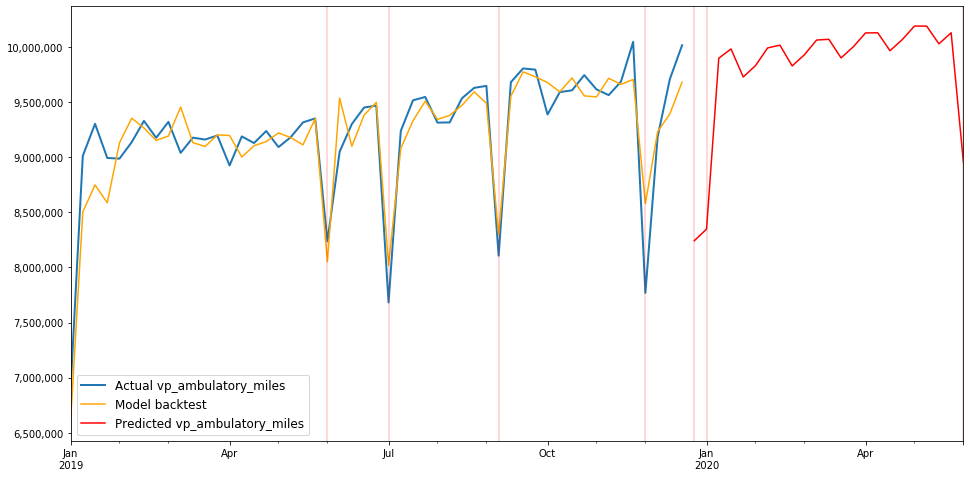

In [270]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [271]:
# make final series

vp_ambulatory_miles = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_ambulatory_miles

vp_ambulatory_miles  lower_vp_ambulatory_miles  \
2019-12-29         8,242,874.54               7,355,887.71   
2020-01-05         8,348,487.32               7,200,106.90   
2020-01-12         9,900,144.67               8,583,337.35   
2020-01-19         9,984,836.90               8,487,432.72   
2020-01-26         9,729,921.51               7,922,723.42   
2020-02-02         9,832,908.49               7,790,565.57   
2020-02-09         9,994,276.48               7,751,729.05   
2020-02-16        10,018,925.43               7,583,850.20   
2020-02-23         9,830,477.08               7,163,076.96   
2020-03-01         9,931,742.26               7,060,821.05   
2020-03-08        10,065,551.60               7,008,868.20   
2020-03-15        10,072,245.61               6,836,968.49   
2020-03-22         9,903,527.15               6,469,058.37   
2020-03-29        10,004,321.14               6,387,138.24   
2020-04-05        10,129,917.12               6,341,311.42   
2020-04-12        10,131,263.02               6,176,630.18   
2020-04-19         9,968,421.14               5,832,131.40   
2020-04-26        10,069,073.93               5,762,882.76   
2020-05-03        10,192,224.73               5,724,504.76   
2020-05-10        10,191,978.75               5,566,812.10   
2020-05-17        10,030,886.21               5,234,307.22   
2020-05-24        10,131,496.97               5,172,947.87   
2020-05-31         8,957,977.57               3,844,258.34   

            upper_vp_ambulatory_miles  
2019-12-29               9,129,861.37  
2020-01-05               9,496,867.74  
2020-01-12              11,216,951.99  
2020-01-19              11,482,241.08  
2020-01-26              11,537,119.61  
2020-02-02              11,875,251.41  
2020-02-09              12,236,823.91  
2020-02-16              12,454,000.67  
2020-02-23              12,497,877.21  
2020-03-01              12,802,663.48  
2020-03-08              13,122,235.00  
2020-03-15              13,307,522.73  
2020-03-22              13,337,995.94  
2020-03-29              13,621,504.04  
2020-04-05              13,918,522.83  
2020-04-12              14,085,895.86  
2020-04-19              14,104,710.88  
2020-04-26              14,375,265.11  
2020-05-03              14,659,944.69  
2020-05-10              14,817,145.40  
2020-05-17              14,827,465.20  
2020-05-24              15,090,046.06  
2020-05-31              14,071,696.80

# Ver Pd Stretcher Rides

In [272]:
series = 'vp_stretcher_rides'

In [273]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=1,
                       S=8,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                vp_stretcher_rides   No. Observations:                  311
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 8)   Log Likelihood               -2274.091
Date:                           Tue, 03 Mar 2020   AIC                           4564.182
Time:                                   16:29:06   BIC                           4593.865
Sample:                               01-12-2014   HQIC                          4576.058
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1375.7293     56.323    -24.426      0.000   -1486.121   -1265.338
ar.L1          0.0406      0.159      0.255      0.798      -0.271       0.352
ar.L2         -0.2534      0.052     -4.886      0.000      -0.355      -0.152
ma.L1         -0.3169      0.159     -1.998      0.046      -0.628      -0.006
ar.S.L8        0.1696      0.062      2.745      0.006       0.049       0.291
ar.S.L16       0.0259      0.066      0.390      0.696      -0.104       0.156
ma.S.L8       -0.9902      0.241     -4.103      0.000      -1.463      -0.517
sigma2       1.79e+05   3.75e+04      4.779      0.000    1.06e+05    2.52e+05
===================================================================================
Ljung-Box (Q):                       42.19   Jarque-Bera (JB):               101.63
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.14
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [274]:
ts.get_dw(model)

1.3034972716453108

In [275]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

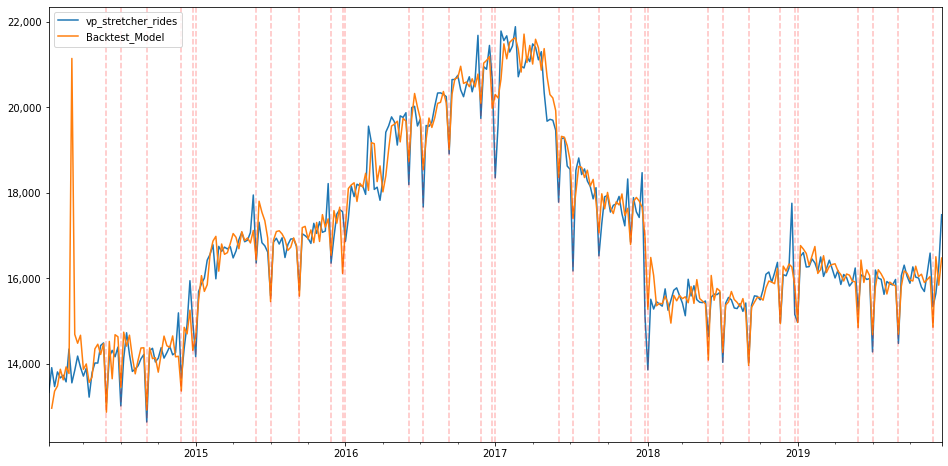

In [276]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [277]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [278]:
# prediction conf intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [279]:
intervals

Predictions  lower vp_stretcher_rides  upper vp_stretcher_rides
2019-12-29    15,653.30                 14,817.06                 16,489.55
2020-01-05    15,293.69                 14,261.52                 16,325.87
2020-01-12    16,970.41                 15,869.20                 18,071.61
2020-01-19    17,126.42                 15,943.01                 18,309.83
2020-01-26    17,009.18                 15,727.80                 18,290.56
2020-02-02    16,794.97                 15,426.22                 18,163.72
2020-02-09    16,989.93                 15,544.00                 18,435.85
2020-02-16    17,264.79                 15,745.00                 18,784.58
2020-02-23    17,170.70                 15,523.21                 18,818.20
2020-03-01    17,068.01                 15,317.97                 18,818.06
2020-03-08    17,260.32                 15,427.22                 19,093.41
2020-03-15    17,300.29                 15,384.94                 19,215.64
2020-03-22    17,170.03                 15,172.55                 19,167.50
2020-03-29    17,084.35                 15,008.54                 19,160.16
2020-04-05    17,224.85                 15,074.35                 19,375.34
2020-04-12    17,365.77                 15,142.99                 19,588.54
2020-04-19    17,328.18                 15,016.55                 19,639.81
2020-04-26    17,263.84                 14,871.83                 19,655.85
2020-05-03    17,434.20                 14,969.32                 19,899.08
2020-05-10    17,446.05                 14,909.38                 19,982.71
2020-05-17    17,307.47                 14,699.85                 19,915.08
2020-05-24    17,265.70                 14,589.21                 19,942.19
2020-05-31    16,010.17                 13,266.83                 18,753.51

In [280]:
# make df for oos

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

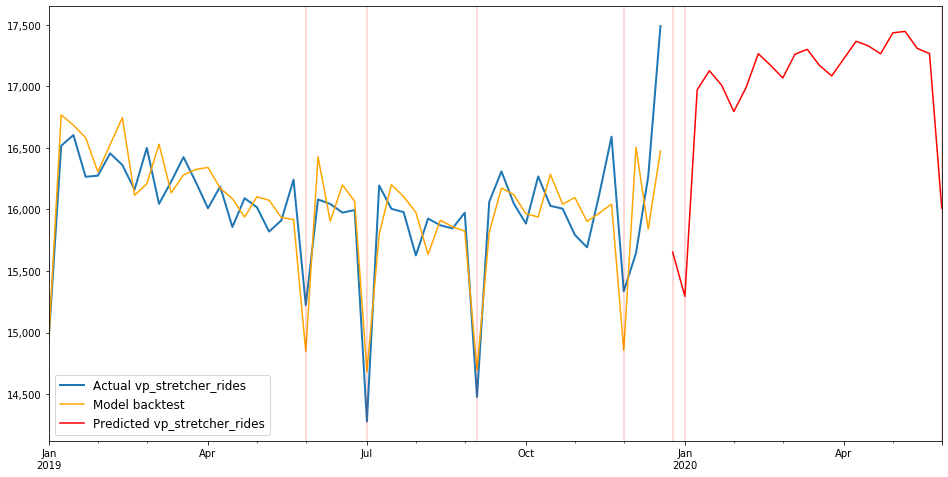

In [281]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [282]:
# make final series

vp_stretcher_rides = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_rides

vp_stretcher_rides  lower_vp_stretcher_rides  \
2019-12-29           15,653.30                 14,817.06   
2020-01-05           15,293.69                 14,261.52   
2020-01-12           16,970.41                 15,869.20   
2020-01-19           17,126.42                 15,943.01   
2020-01-26           17,009.18                 15,727.80   
2020-02-02           16,794.97                 15,426.22   
2020-02-09           16,989.93                 15,544.00   
2020-02-16           17,264.79                 15,745.00   
2020-02-23           17,170.70                 15,523.21   
2020-03-01           17,068.01                 15,317.97   
2020-03-08           17,260.32                 15,427.22   
2020-03-15           17,300.29                 15,384.94   
2020-03-22           17,170.03                 15,172.55   
2020-03-29           17,084.35                 15,008.54   
2020-04-05           17,224.85                 15,074.35   
2020-04-12           17,365.77                 15,142.99   
2020-04-19           17,328.18                 15,016.55   
2020-04-26           17,263.84                 14,871.83   
2020-05-03           17,434.20                 14,969.32   
2020-05-10           17,446.05                 14,909.38   
2020-05-17           17,307.47                 14,699.85   
2020-05-24           17,265.70                 14,589.21   
2020-05-31           16,010.17                 13,266.83   

            upper_vp_stretcher_rides  
2019-12-29                 16,489.55  
2020-01-05                 16,325.87  
2020-01-12                 18,071.61  
2020-01-19                 18,309.83  
2020-01-26                 18,290.56  
2020-02-02                 18,163.72  
2020-02-09                 18,435.85  
2020-02-16                 18,784.58  
2020-02-23                 18,818.20  
2020-03-01                 18,818.06  
2020-03-08                 19,093.41  
2020-03-15                 19,215.64  
2020-03-22                 19,167.50  
2020-03-29                 19,160.16  
2020-04-05                 19,375.34  
2020-04-12                 19,588.54  
2020-04-19                 19,639.81  
2020-04-26                 19,655.85  
2020-05-03                 19,899.08  
2020-05-10                 19,982.71  
2020-05-17                 19,915.08  
2020-05-24                 19,942.19  
2020-05-31                 18,753.51

# Ver Pd Stretcher Costs

In [283]:
series = 'vp_stretcher_costs'

In [287]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=5,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                vp_stretcher_costs   No. Observations:                  311
Model:             SARIMAX(2, 1, 0)x(1, 1, 2, 5)   Log Likelihood               -3834.268
Date:                           Tue, 03 Mar 2020   AIC                           7682.536
Time:                                   16:47:46   BIC                           7708.578
Sample:                               01-12-2014   HQIC                          7692.953
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -2.373e+05   1.16e+04    -20.536      0.000    -2.6e+05   -2.15e+05
ar.L1         -0.4165      0.061     -6.812      0.000      -0.536      -0.297
ar.L2         -0.3009      0.072     -4.170      0.000      -0.442      -0.159
ar.S.L5       -0.3364      0.327     -1.030      0.303      -0.977       0.304
ma.S.L5       -0.3882      0.300     -1.296      0.195      -0.975       0.199
ma.S.L10      -0.4439      0.243     -1.828      0.068      -0.920       0.032
sigma2       6.74e+09      0.056    1.2e+11      0.000    6.74e+09    6.74e+09
===================================================================================
Ljung-Box (Q):                       39.09   Jarque-Bera (JB):                20.50
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.19
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.78e+26. Standard errors may be unstable.
"""

In [288]:
ts.get_dw(model)

1.5850423885591205

In [289]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

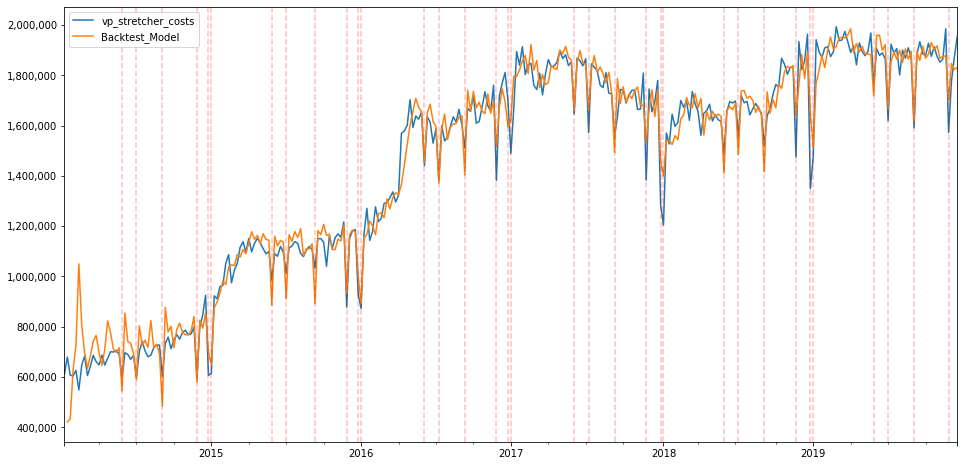

In [290]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [291]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train)+1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [292]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [293]:
intervals

Predictions  lower vp_stretcher_costs  upper vp_stretcher_costs
2019-12-29 1,704,480.08              1,543,573.63              1,865,386.53
2020-01-05 1,658,951.84              1,472,654.78              1,845,248.90
2020-01-12 1,906,399.48              1,706,170.95              2,106,628.02
2020-01-19 1,913,219.07              1,688,466.21              2,137,971.94
2020-01-26 1,935,530.77              1,691,013.65              2,180,047.88
2020-02-02 1,950,060.47              1,671,042.30              2,229,078.64
2020-02-09 1,935,052.06              1,631,215.26              2,238,888.86
2020-02-16 1,936,315.63              1,611,552.22              2,261,079.03
2020-02-23 1,926,240.62              1,579,575.09              2,272,906.15
2020-03-01 1,931,982.97              1,565,067.39              2,298,898.55
2020-03-08 1,966,647.41              1,577,123.00              2,356,171.83
2020-03-15 1,940,285.11              1,530,675.04              2,349,895.18
2020-03-22 1,936,190.40              1,507,869.48              2,364,511.33
2020-03-29 1,935,606.12              1,488,837.06              2,382,375.18
2020-04-05 1,947,851.07              1,483,454.27              2,412,247.88
2020-04-12 1,974,209.80              1,486,416.99              2,462,002.61
2020-04-19 1,952,025.58              1,444,547.01              2,459,504.16
2020-04-26 1,950,045.11              1,424,382.98              2,475,707.25
2020-05-03 1,946,030.46              1,401,768.59              2,490,292.33
2020-05-10 1,956,093.25              1,394,044.88              2,518,141.63
2020-05-17 1,985,315.30              1,401,292.10              2,569,338.49
2020-05-24 1,961,695.16              1,358,401.10              2,564,989.21
2020-05-31 1,721,724.68              1,100,347.23              2,343,102.14

In [294]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

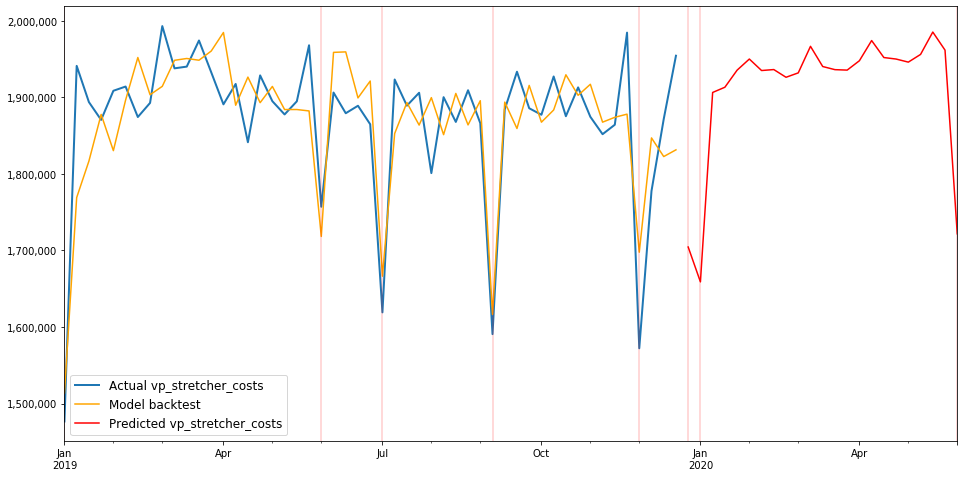

In [295]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [296]:
# make final series

vp_stretcher_costs = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_costs

vp_stretcher_costs  lower_vp_stretcher_costs  \
2019-12-29        1,704,480.08              1,543,573.63   
2020-01-05        1,658,951.84              1,472,654.78   
2020-01-12        1,906,399.48              1,706,170.95   
2020-01-19        1,913,219.07              1,688,466.21   
2020-01-26        1,935,530.77              1,691,013.65   
2020-02-02        1,950,060.47              1,671,042.30   
2020-02-09        1,935,052.06              1,631,215.26   
2020-02-16        1,936,315.63              1,611,552.22   
2020-02-23        1,926,240.62              1,579,575.09   
2020-03-01        1,931,982.97              1,565,067.39   
2020-03-08        1,966,647.41              1,577,123.00   
2020-03-15        1,940,285.11              1,530,675.04   
2020-03-22        1,936,190.40              1,507,869.48   
2020-03-29        1,935,606.12              1,488,837.06   
2020-04-05        1,947,851.07              1,483,454.27   
2020-04-12        1,974,209.80              1,486,416.99   
2020-04-19        1,952,025.58              1,444,547.01   
2020-04-26        1,950,045.11              1,424,382.98   
2020-05-03        1,946,030.46              1,401,768.59   
2020-05-10        1,956,093.25              1,394,044.88   
2020-05-17        1,985,315.30              1,401,292.10   
2020-05-24        1,961,695.16              1,358,401.10   
2020-05-31        1,721,724.68              1,100,347.23   

            upper_vp_stretcher_costs  
2019-12-29              1,865,386.53  
2020-01-05              1,845,248.90  
2020-01-12              2,106,628.02  
2020-01-19              2,137,971.94  
2020-01-26              2,180,047.88  
2020-02-02              2,229,078.64  
2020-02-09              2,238,888.86  
2020-02-16              2,261,079.03  
2020-02-23              2,272,906.15  
2020-03-01              2,298,898.55  
2020-03-08              2,356,171.83  
2020-03-15              2,349,895.18  
2020-03-22              2,364,511.33  
2020-03-29              2,382,375.18  
2020-04-05              2,412,247.88  
2020-04-12              2,462,002.61  
2020-04-19              2,459,504.16  
2020-04-26              2,475,707.25  
2020-05-03              2,490,292.33  
2020-05-10              2,518,141.63  
2020-05-17              2,569,338.49  
2020-05-24              2,564,989.21  
2020-05-31              2,343,102.14

# Ver Pd Stretcher Miles

In [297]:
series = 'vp_stretcher_miles'

In [298]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=5,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                vp_stretcher_miles   No. Observations:                  311
Model:             SARIMAX(2, 1, 0)x(1, 1, 1, 5)   Log Likelihood               -3127.018
Date:                           Tue, 03 Mar 2020   AIC                           6266.036
Time:                                   16:49:05   BIC                           6288.358
Sample:                               01-12-2014   HQIC                          6274.964
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -2.267e+04   1185.801    -19.118      0.000    -2.5e+04   -2.03e+04
ar.L1         -0.2155      0.034     -6.398      0.000      -0.282      -0.149
ar.L2         -0.1409      0.059     -2.387      0.017      -0.257      -0.025
ar.S.L5        0.3249      0.054      6.017      0.000       0.219       0.431
ma.S.L5       -0.9077      0.044    -20.411      0.000      -0.995      -0.821
sigma2      5.922e+07      0.031   1.89e+09      0.000    5.92e+07    5.92e+07
===================================================================================
Ljung-Box (Q):                       44.14   Jarque-Bera (JB):                10.55
Prob(Q):                              0.30   Prob(JB):                         0.01
Heteroskedasticity (H):               0.64   Skew:                            -0.17
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+26. Standard errors may be unstable.
"""

In [299]:
ts.get_dw(model)

1.3600021022077027

In [300]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

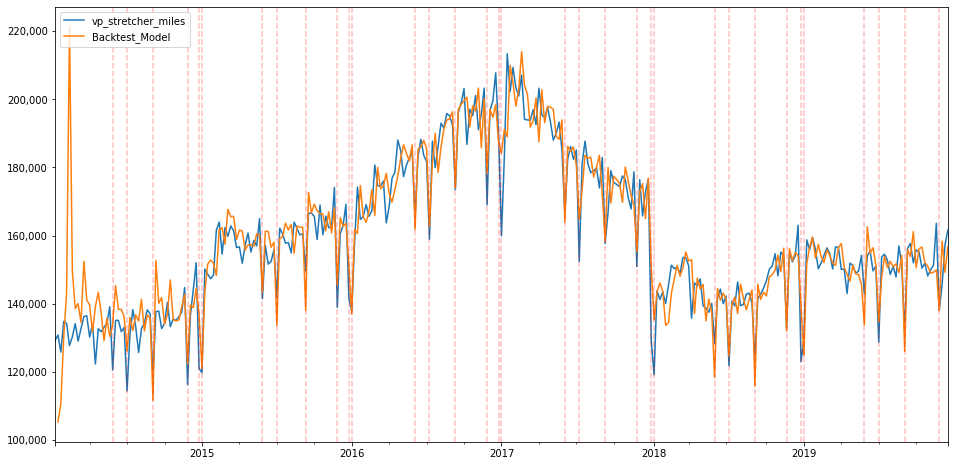

In [301]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [302]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [303]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [304]:
intervals

Predictions  lower vp_stretcher_miles  upper vp_stretcher_miles
2019-12-29   142,455.14                127,372.19                157,538.09
2020-01-05   140,839.23                121,668.73                160,009.74
2020-01-12   157,844.35                136,031.11                179,657.59
2020-01-19   162,053.92                137,545.92                186,561.92
2020-01-26   163,441.71                136,492.27                190,391.15
2020-02-02   166,427.69                134,357.49                198,497.88
2020-02-09   165,299.13                129,437.51                201,160.75
2020-02-16   162,308.89                123,254.40                201,363.38
2020-02-23   164,209.91                122,087.98                206,331.85
2020-03-01   164,659.67                119,673.91                209,645.43
2020-03-08   167,456.11                118,551.20                216,361.01
2020-03-15   166,484.64                114,215.09                218,754.20
2020-03-22   164,366.07                109,041.35                219,690.79
2020-03-29   165,516.68                107,243.07                223,790.30
2020-04-05   165,661.40                104,578.70                226,744.09
2020-04-12   168,396.37                103,871.82                232,920.92
2020-04-19   167,475.96                 99,846.52                235,105.39
2020-04-26   165,640.56                 95,109.53                236,171.59
2020-05-03   166,547.37                 93,194.97                239,899.78
2020-05-10   166,592.98                 90,522.23                242,663.74
2020-05-17   169,307.99                 90,024.40                248,591.57
2020-05-24   168,404.16                 86,159.77                250,648.55
2020-05-31   143,990.47                 58,941.05                229,039.88

In [305]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

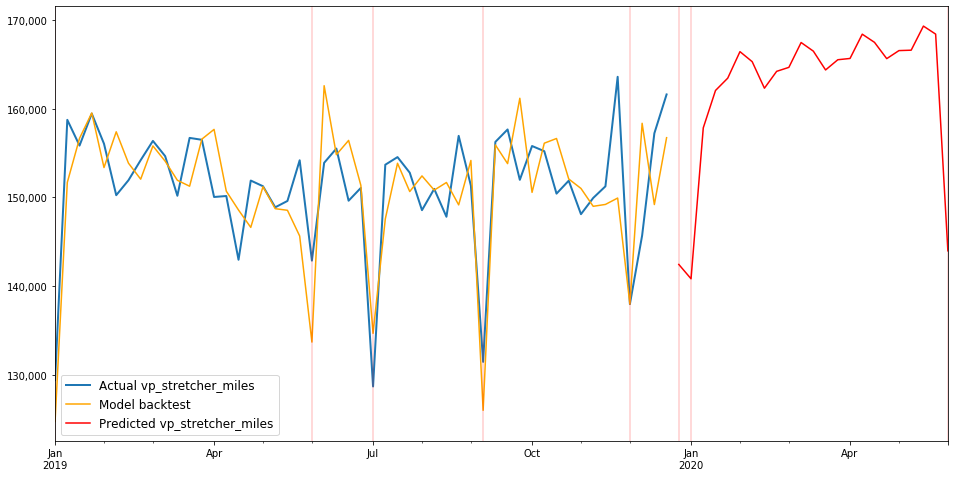

In [306]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [307]:
# make final series

vp_stretcher_miles = ts.oos_weekly_df(model=model,
                                      steps_ahead=horizon,
                                      exog_data = oos_exog,
                                      series = series,
                                      add_date = False)

vp_stretcher_miles

vp_stretcher_miles  lower_vp_stretcher_miles  \
2019-12-29          142,455.14                127,372.19   
2020-01-05          140,839.23                121,668.73   
2020-01-12          157,844.35                136,031.11   
2020-01-19          162,053.92                137,545.92   
2020-01-26          163,441.71                136,492.27   
2020-02-02          166,427.69                134,357.49   
2020-02-09          165,299.13                129,437.51   
2020-02-16          162,308.89                123,254.40   
2020-02-23          164,209.91                122,087.98   
2020-03-01          164,659.67                119,673.91   
2020-03-08          167,456.11                118,551.20   
2020-03-15          166,484.64                114,215.09   
2020-03-22          164,366.07                109,041.35   
2020-03-29          165,516.68                107,243.07   
2020-04-05          165,661.40                104,578.70   
2020-04-12          168,396.37                103,871.82   
2020-04-19          167,475.96                 99,846.52   
2020-04-26          165,640.56                 95,109.53   
2020-05-03          166,547.37                 93,194.97   
2020-05-10          166,592.98                 90,522.23   
2020-05-17          169,307.99                 90,024.40   
2020-05-24          168,404.16                 86,159.77   
2020-05-31          143,990.47                 58,941.05   

            upper_vp_stretcher_miles  
2019-12-29                157,538.09  
2020-01-05                160,009.74  
2020-01-12                179,657.59  
2020-01-19                186,561.92  
2020-01-26                190,391.15  
2020-02-02                198,497.88  
2020-02-09                201,160.75  
2020-02-16                201,363.38  
2020-02-23                206,331.85  
2020-03-01                209,645.43  
2020-03-08                216,361.01  
2020-03-15                218,754.20  
2020-03-22                219,690.79  
2020-03-29                223,790.30  
2020-04-05                226,744.09  
2020-04-12                232,920.92  
2020-04-19                235,105.39  
2020-04-26                236,171.59  
2020-05-03                239,899.78  
2020-05-10                242,663.74  
2020-05-17                248,591.57  
2020-05-24                250,648.55  
2020-05-31                229,039.88

# Ver Pd Wheelchair Rides

In [308]:
series = 'vp_wheelchair_rides'

In [309]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=12,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                vp_wheelchair_rides   No. Observations:                  311
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2920.338
Date:                            Tue, 03 Mar 2020   AIC                           5852.677
Time:                                    16:49:29   BIC                           5874.859
Sample:                                01-12-2014   HQIC                          5861.556
                                     - 12-22-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.078e+04    496.887    -21.694      0.000   -1.18e+04   -9805.461
ar.L1         -0.0464      0.038     -1.205      0.228      -0.122       0.029
ar.L2         -0.1600      0.019     -8.267      0.000      -0.198      -0.122
ar.S.L12      -0.3075      0.018    -16.861      0.000      -0.343      -0.272
ar.S.L24      -0.1690      0.012    -14.024      0.000      -0.193      -0.145
sigma2      2.065e+07      0.009   2.27e+09      0.000    2.07e+07    2.07e+07
===================================================================================
Ljung-Box (Q):                      146.92   Jarque-Bera (JB):                62.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.29
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+25. Standard errors may be unstable.
"""

In [310]:
ts.get_dw(model)

1.4430117843483803

In [311]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

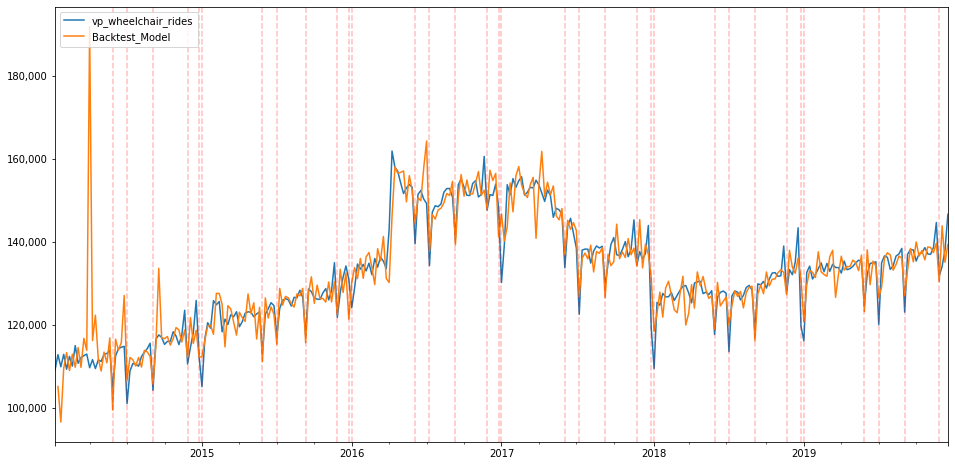

In [312]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [313]:
# predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [314]:
# make prediction intervals

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [315]:
intervals

Predictions  lower vp_wheelchair_rides  upper vp_wheelchair_rides
2019-12-29   133,335.03                 124,427.88                 142,242.17
2020-01-05   133,438.16                 121,130.31                 145,746.01
2020-01-12   144,657.69                 130,454.91                 158,860.47
2020-01-19   145,454.27                 129,522.09                 161,386.45
2020-01-26   144,599.10                 127,016.20                 162,182.00
2020-02-02   144,752.61                 125,673.31                 163,831.90
2020-02-09   146,019.89                 125,565.44                 166,474.34
2020-02-16   149,831.81                 128,086.79                 171,576.83
2020-02-23   148,150.59                 125,185.79                 171,115.40
2020-03-01   142,795.25                 118,672.66                 166,917.85
2020-03-08   145,671.37                 120,444.28                 170,898.45
2020-03-15   150,917.46                 124,632.19                 177,202.74
2020-03-22   149,474.02                 119,901.21                 179,046.84
2020-03-29   150,061.18                 117,649.59                 182,472.77
2020-04-05   150,341.94                 115,678.04                 185,005.84
2020-04-12   150,572.87                 113,763.82                 187,381.91
2020-04-19   149,916.08                 111,031.61                 188,800.56
2020-04-26   150,403.67                 109,555.67                 191,251.66
2020-05-03   151,598.16                 108,883.61                 194,312.72
2020-05-10   155,298.78                 110,794.61                 199,802.94
2020-05-17   153,060.81                 106,835.31                 199,286.30
2020-05-24   148,723.99                 100,839.23                 196,608.74
2020-05-31   140,665.18                  91,176.90                 190,153.46

In [316]:
# make df for oos plot

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

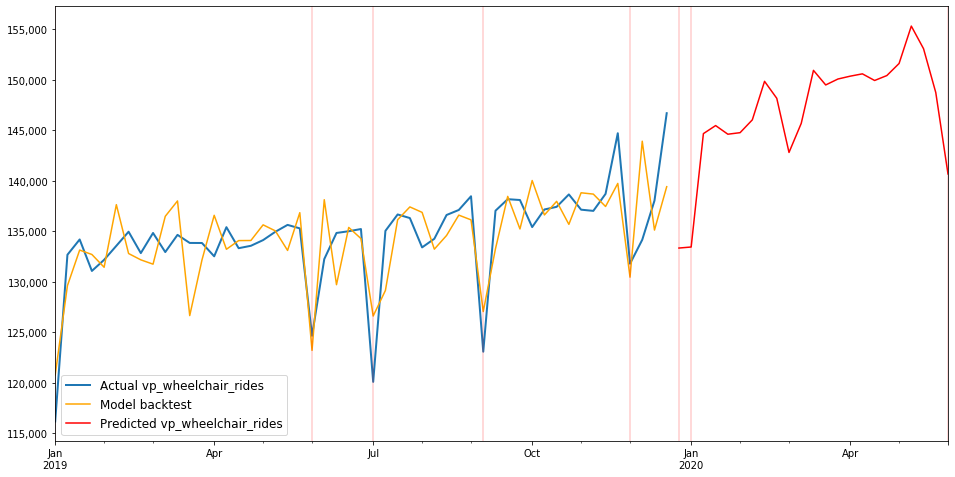

In [317]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [318]:
# make final series

vp_wheelchair_rides = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_rides

vp_wheelchair_rides  lower_vp_wheelchair_rides  \
2019-12-29           133,335.03                 124,427.88   
2020-01-05           133,438.16                 121,130.31   
2020-01-12           144,657.69                 130,454.91   
2020-01-19           145,454.27                 129,522.09   
2020-01-26           144,599.10                 127,016.20   
2020-02-02           144,752.61                 125,673.31   
2020-02-09           146,019.89                 125,565.44   
2020-02-16           149,831.81                 128,086.79   
2020-02-23           148,150.59                 125,185.79   
2020-03-01           142,795.25                 118,672.66   
2020-03-08           145,671.37                 120,444.28   
2020-03-15           150,917.46                 124,632.19   
2020-03-22           149,474.02                 119,901.21   
2020-03-29           150,061.18                 117,649.59   
2020-04-05           150,341.94                 115,678.04   
2020-04-12           150,572.87                 113,763.82   
2020-04-19           149,916.08                 111,031.61   
2020-04-26           150,403.67                 109,555.67   
2020-05-03           151,598.16                 108,883.61   
2020-05-10           155,298.78                 110,794.61   
2020-05-17           153,060.81                 106,835.31   
2020-05-24           148,723.99                 100,839.23   
2020-05-31           140,665.18                  91,176.90   

            upper_vp_wheelchair_rides  
2019-12-29                 142,242.17  
2020-01-05                 145,746.01  
2020-01-12                 158,860.47  
2020-01-19                 161,386.45  
2020-01-26                 162,182.00  
2020-02-02                 163,831.90  
2020-02-09                 166,474.34  
2020-02-16                 171,576.83  
2020-02-23                 171,115.40  
2020-03-01                 166,917.85  
2020-03-08                 170,898.45  
2020-03-15                 177,202.74  
2020-03-22                 179,046.84  
2020-03-29                 182,472.77  
2020-04-05                 185,005.84  
2020-04-12                 187,381.91  
2020-04-19                 188,800.56  
2020-04-26                 191,251.66  
2020-05-03                 194,312.72  
2020-05-10                 199,802.94  
2020-05-17                 199,286.30  
2020-05-24                 196,608.74  
2020-05-31                 190,153.46

# Ver Pd Wheelchair Costs

In [319]:
series = 'vp_wheelchair_costs'

In [320]:
model = ts.build_model(train[series],
                       p=2,
                       d=1,
                       q=0,
                       S=6,
                       exog_data = train['holiday'],
                       P=2,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               vp_wheelchair_costs   No. Observations:                  311
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -4120.809
Date:                           Tue, 03 Mar 2020   AIC                           8253.617
Time:                                   16:49:43   BIC                           8275.920
Sample:                               01-12-2014   HQIC                          8262.539
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -5.906e+05   2.23e+04    -26.527      0.000   -6.34e+05   -5.47e+05
ar.L1         -0.4088      0.049     -8.414      0.000      -0.504      -0.314
ar.L2         -0.2365      0.065     -3.636      0.000      -0.364      -0.109
ar.S.L6       -0.5299      0.032    -16.311      0.000      -0.594      -0.466
ar.S.L12      -0.2903      0.026    -11.340      0.000      -0.341      -0.240
sigma2      4.225e+10      0.060   7.07e+11      0.000    4.22e+10    4.22e+10
===================================================================================
Ljung-Box (Q):                       60.22   Jarque-Bera (JB):                84.23
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.67
Prob(H) (two-sided):                  0.33   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+27. Standard errors may be unstable.
"""

In [321]:
ts.get_dw(model)

1.4314923449610917

In [322]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

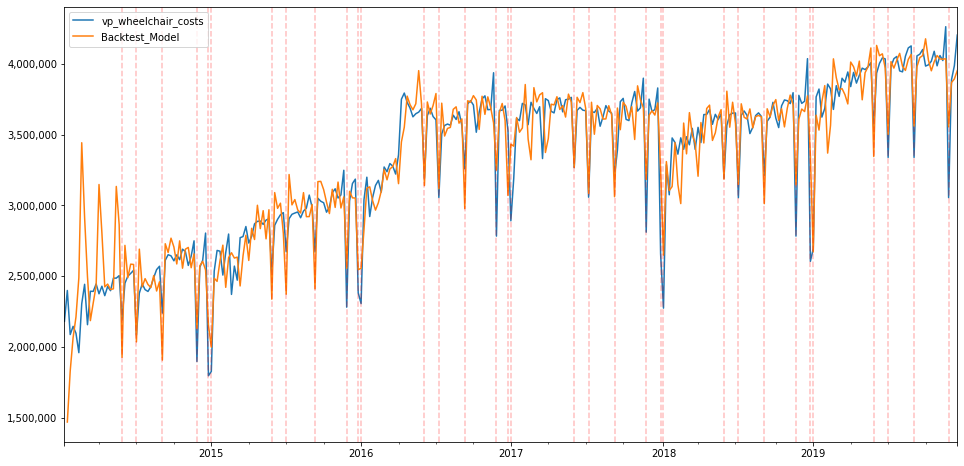

In [323]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [324]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [325]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [326]:
intervals

Predictions  lower vp_wheelchair_costs  upper vp_wheelchair_costs
2019-12-29 3,491,691.84               3,088,833.20               3,894,550.47
2020-01-05 3,614,789.53               3,146,796.93               4,082,782.13
2020-01-12 3,884,567.90               3,371,525.76               4,397,610.05
2020-01-19 4,042,125.41               3,466,693.70               4,617,557.13
2020-01-26 4,067,135.67               3,441,086.13               4,693,185.21
2020-02-02 4,198,352.93               3,527,727.95               4,868,977.91
2020-02-09 4,098,396.63               3,298,694.86               4,898,098.40
2020-02-16 4,215,868.19               3,339,978.15               5,091,758.23
2020-02-23 3,925,021.70               2,984,308.55               4,865,734.86
2020-03-01 4,077,188.63               3,067,251.89               5,087,125.36
2020-03-08 4,083,035.08               3,010,561.01               5,155,509.14
2020-03-15 4,217,606.84               3,087,016.15               5,348,197.53
2020-03-22 4,131,508.97               2,875,906.93               5,387,111.01
2020-03-29 4,285,640.29               2,944,993.46               5,626,287.13
2020-04-05 3,893,086.65               2,476,839.01               5,309,334.29
2020-04-12 4,072,294.71               2,576,905.50               5,567,683.91
2020-04-19 4,110,139.02               2,541,550.04               5,678,728.00
2020-04-26 4,267,572.14               2,629,892.10               5,905,252.18
2020-05-03 4,168,160.61               2,378,010.44               5,958,310.78
2020-05-10 4,304,499.62               2,409,861.64               6,199,137.60
2020-05-17 3,957,140.71               1,968,944.72               5,945,336.70
2020-05-24 4,123,585.01               2,036,685.78               6,210,484.24
2020-05-31 3,559,450.74               1,380,815.80               5,738,085.67

In [327]:
# make df for oos plt

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

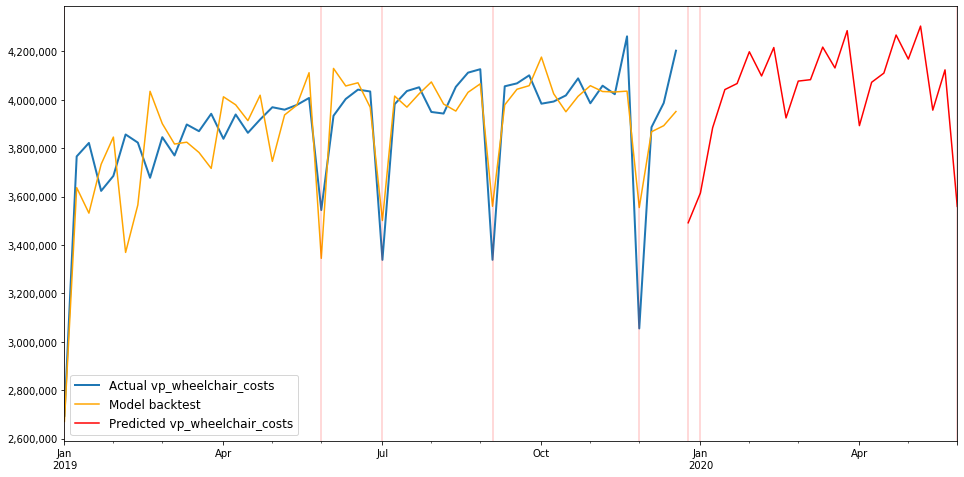

In [328]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [329]:
# make final series

vp_wheelchair_costs = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_costs

vp_wheelchair_costs  lower_vp_wheelchair_costs  \
2019-12-29         3,491,691.84               3,088,833.20   
2020-01-05         3,614,789.53               3,146,796.93   
2020-01-12         3,884,567.90               3,371,525.76   
2020-01-19         4,042,125.41               3,466,693.70   
2020-01-26         4,067,135.67               3,441,086.13   
2020-02-02         4,198,352.93               3,527,727.95   
2020-02-09         4,098,396.63               3,298,694.86   
2020-02-16         4,215,868.19               3,339,978.15   
2020-02-23         3,925,021.70               2,984,308.55   
2020-03-01         4,077,188.63               3,067,251.89   
2020-03-08         4,083,035.08               3,010,561.01   
2020-03-15         4,217,606.84               3,087,016.15   
2020-03-22         4,131,508.97               2,875,906.93   
2020-03-29         4,285,640.29               2,944,993.46   
2020-04-05         3,893,086.65               2,476,839.01   
2020-04-12         4,072,294.71               2,576,905.50   
2020-04-19         4,110,139.02               2,541,550.04   
2020-04-26         4,267,572.14               2,629,892.10   
2020-05-03         4,168,160.61               2,378,010.44   
2020-05-10         4,304,499.62               2,409,861.64   
2020-05-17         3,957,140.71               1,968,944.72   
2020-05-24         4,123,585.01               2,036,685.78   
2020-05-31         3,559,450.74               1,380,815.80   

            upper_vp_wheelchair_costs  
2019-12-29               3,894,550.47  
2020-01-05               4,082,782.13  
2020-01-12               4,397,610.05  
2020-01-19               4,617,557.13  
2020-01-26               4,693,185.21  
2020-02-02               4,868,977.91  
2020-02-09               4,898,098.40  
2020-02-16               5,091,758.23  
2020-02-23               4,865,734.86  
2020-03-01               5,087,125.36  
2020-03-08               5,155,509.14  
2020-03-15               5,348,197.53  
2020-03-22               5,387,111.01  
2020-03-29               5,626,287.13  
2020-04-05               5,309,334.29  
2020-04-12               5,567,683.91  
2020-04-19               5,678,728.00  
2020-04-26               5,905,252.18  
2020-05-03               5,958,310.78  
2020-05-10               6,199,137.60  
2020-05-17               5,945,336.70  
2020-05-24               6,210,484.24  
2020-05-31               5,738,085.67

# Ver Pd Wheelchair Miles

In [330]:
series = 'vp_wheelchair_miles'

In [331]:
# get the outlier
outlier = train[series].quantile(0.95)

# get the median
median = train[series].quantile(0.50)

# replace the outliers
train[series] = np.where(train[series] > outlier, median,train[series])

In [344]:
model = ts.build_model(train[series],
                       p=0,
                       d=1,
                       q=2,
                       S=12,
                       exog_data = train['holiday'],
                       P=1,
                       D=1,
                       Q=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                vp_wheelchair_miles   No. Observations:                  311
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -3628.322
Date:                            Tue, 03 Mar 2020   AIC                           7270.644
Time:                                    16:56:12   BIC                           7296.523
Sample:                                01-12-2014   HQIC                          7281.003
                                     - 12-22-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1.329e+05   6157.955    -21.579      0.000   -1.45e+05   -1.21e+05
ma.L1         -0.1728      0.028     -6.238      0.000      -0.227      -0.118
ma.L2         -0.1054      0.036     -2.939      0.003      -0.176      -0.035
ar.S.L12       0.2430      0.108      2.246      0.025       0.031       0.455
ma.S.L12      -0.8143      0.110     -7.411      0.000      -1.030      -0.599
ma.S.L24      -0.0616      0.069     -0.896      0.370      -0.196       0.073
sigma2      2.444e+09      0.016   1.56e+11      0.000    2.44e+09    2.44e+09
===================================================================================
Ljung-Box (Q):                       82.14   Jarque-Bera (JB):                78.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.49
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.65e+27. Standard errors may be unstable.
"""

In [345]:
ts.get_dw(model)

1.3277695764401096

In [346]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

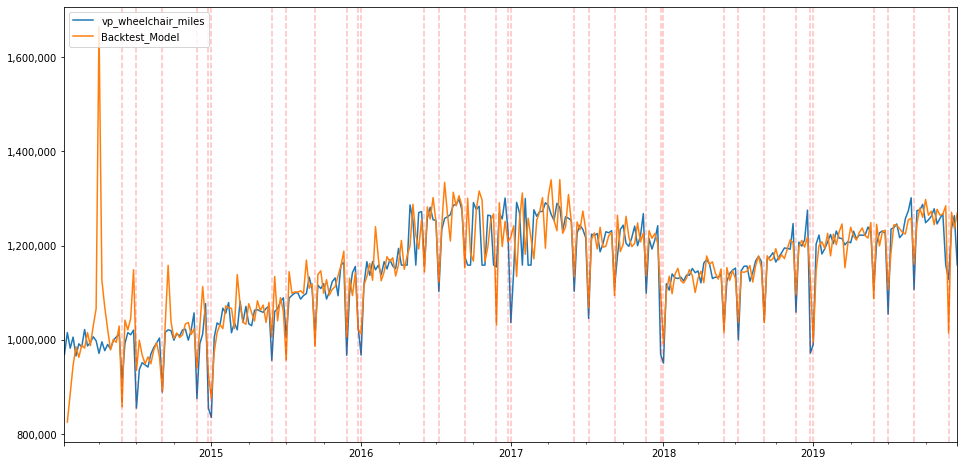

In [347]:
# plot backtest

ts.plot_fit(train[series], backtest, train)

In [348]:
# make predictions

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [349]:
# conf intervals for predictions

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [350]:
intervals

Predictions  lower vp_wheelchair_miles  upper vp_wheelchair_miles
2019-12-29 1,022,351.79                 925,445.82               1,119,257.77
2020-01-05 1,044,593.47                 918,830.22               1,170,356.73
2020-01-12 1,188,497.71               1,044,591.27               1,332,404.15
2020-01-19 1,186,448.02               1,026,442.61               1,346,453.43
2020-01-26 1,173,809.65                 999,183.20               1,348,436.11
2020-02-02 1,182,405.97                 994,291.47               1,370,520.47
2020-02-09 1,185,412.76                 984,714.64               1,386,110.87
2020-02-16 1,142,849.11                 930,311.10               1,355,387.11
2020-02-23 1,179,141.21                 955,388.96               1,402,893.46
2020-03-01 1,170,836.74                 936,406.08               1,405,267.41
2020-03-08 1,187,185.60                 942,542.17               1,431,829.02
2020-03-15 1,143,273.66                 888,826.88               1,397,720.43
2020-03-22 1,138,190.77                 860,378.06               1,416,003.47
2020-03-29 1,155,132.85                 858,376.40               1,451,889.31
2020-04-05 1,167,200.54                 854,064.71               1,480,336.36
2020-04-12 1,158,545.92                 829,845.92               1,487,245.93
2020-04-19 1,152,879.88                 809,320.07               1,496,439.69
2020-04-26 1,160,962.91                 803,159.90               1,518,765.92
2020-05-03 1,161,992.74                 790,492.21               1,533,493.27
2020-05-10 1,143,285.18                 758,574.52               1,527,995.84
2020-05-17 1,155,011.89                 757,529.89               1,552,493.90
2020-05-24 1,153,221.31                 743,365.74               1,563,076.89
2020-05-31 1,032,894.78                 611,028.41               1,454,761.16

In [351]:
# make df for oos plt

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

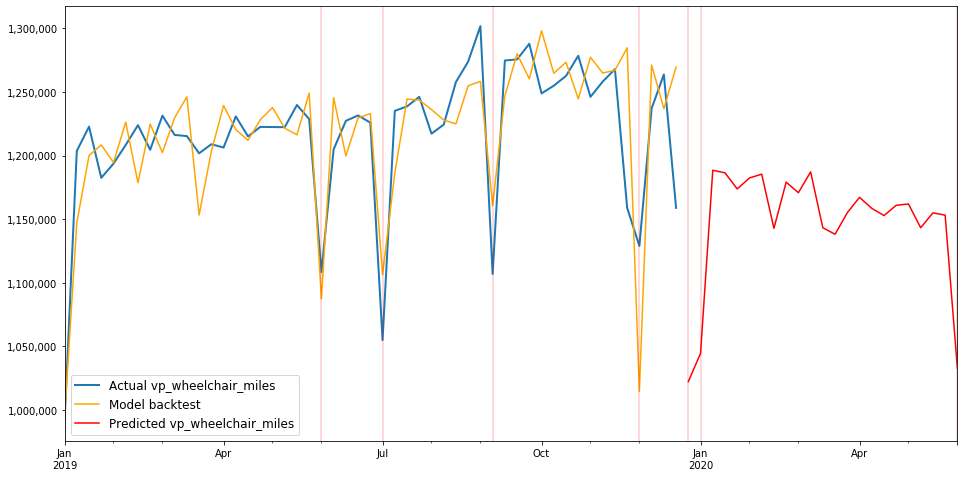

In [352]:
# plot oos

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01')

In [353]:
# make final series

vp_wheelchair_miles = ts.oos_weekly_df(model=model,
                                       steps_ahead=horizon,
                                       exog_data = oos_exog,
                                       series = series,
                                       add_date = False)

vp_wheelchair_miles

vp_wheelchair_miles  lower_vp_wheelchair_miles  \
2019-12-29         1,022,351.79                 925,445.82   
2020-01-05         1,044,593.47                 918,830.22   
2020-01-12         1,188,497.71               1,044,591.27   
2020-01-19         1,186,448.02               1,026,442.61   
2020-01-26         1,173,809.65                 999,183.20   
2020-02-02         1,182,405.97                 994,291.47   
2020-02-09         1,185,412.76                 984,714.64   
2020-02-16         1,142,849.11                 930,311.10   
2020-02-23         1,179,141.21                 955,388.96   
2020-03-01         1,170,836.74                 936,406.08   
2020-03-08         1,187,185.60                 942,542.17   
2020-03-15         1,143,273.66                 888,826.88   
2020-03-22         1,138,190.77                 860,378.06   
2020-03-29         1,155,132.85                 858,376.40   
2020-04-05         1,167,200.54                 854,064.71   
2020-04-12         1,158,545.92                 829,845.92   
2020-04-19         1,152,879.88                 809,320.07   
2020-04-26         1,160,962.91                 803,159.90   
2020-05-03         1,161,992.74                 790,492.21   
2020-05-10         1,143,285.18                 758,574.52   
2020-05-17         1,155,011.89                 757,529.89   
2020-05-24         1,153,221.31                 743,365.74   
2020-05-31         1,032,894.78                 611,028.41   

            upper_vp_wheelchair_miles  
2019-12-29               1,119,257.77  
2020-01-05               1,170,356.73  
2020-01-12               1,332,404.15  
2020-01-19               1,346,453.43  
2020-01-26               1,348,436.11  
2020-02-02               1,370,520.47  
2020-02-09               1,386,110.87  
2020-02-16               1,355,387.11  
2020-02-23               1,402,893.46  
2020-03-01               1,405,267.41  
2020-03-08               1,431,829.02  
2020-03-15               1,397,720.43  
2020-03-22               1,416,003.47  
2020-03-29               1,451,889.31  
2020-04-05               1,480,336.36  
2020-04-12               1,487,245.93  
2020-04-19               1,496,439.69  
2020-04-26               1,518,765.92  
2020-05-03               1,533,493.27  
2020-05-10               1,527,995.84  
2020-05-17               1,552,493.90  
2020-05-24               1,563,076.89  
2020-05-31               1,454,761.16

# CPM

In [354]:
series = 'cpm'

In [355]:
train[series].describe()

count   311.00
mean      2.36
std       0.19
min       1.39
25%       2.24
50%       2.44
75%       2.51
max       2.69
Name: cpm, dtype: float64

In [356]:
# get the outlier
outlier = train[series].quantile(.01)

# get the median
median = train[series].quantile(0.50)

# replace the outliers
train[series] = np.where(train[series] < outlier, median,train[series])

print(outlier)
print(median)
train[series].describe()

1.9400796878628073
2.440816891851869


count   311.00
mean      2.37
std       0.17
min       1.97
25%       2.24
50%       2.44
75%       2.51
max       2.69
Name: cpm, dtype: float64

In [357]:
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)

model = ts.build_model(train[series],
                       p=3,
                       d=1,
                       q=0,
                       S=6,
                       exog_data = train['holiday'],
                       P=3,
                       D=1,
                       Q=0)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                               cpm   No. Observations:                  311
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 6)   Log Likelihood                 487.771
Date:                           Tue, 03 Mar 2020   AIC                           -959.541
Time:                                   16:57:25   BIC                           -929.805
Sample:                               01-12-2014   HQIC                          -947.646
                                    - 12-22-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday        0.0663      0.008      8.650      0.000       0.051       0.081
ar.L1         -0.4825      0.028    -17.341      0.000      -0.537      -0.428
ar.L2         -0.3997      0.031    -12.909      0.000      -0.460      -0.339
ar.L3         -0.2060      0.061     -3.387      0.001      -0.325      -0.087
ar.S.L6       -0.7197      0.033    -21.877      0.000      -0.784      -0.655
ar.S.L12      -0.4006      0.043     -9.370      0.000      -0.484      -0.317
ar.S.L18      -0.2099      0.038     -5.480      0.000      -0.285      -0.135
sigma2         0.0023   7.72e-05     30.194      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       61.28   Jarque-Bera (JB):              1979.69
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [358]:
ts.get_dw(model)

1.2798922385127631

In [359]:
backtest = ts.backtest_model(model,
                             train = train,
                             exog_data=train['holiday'][1:],
                             end = len(train)-1)

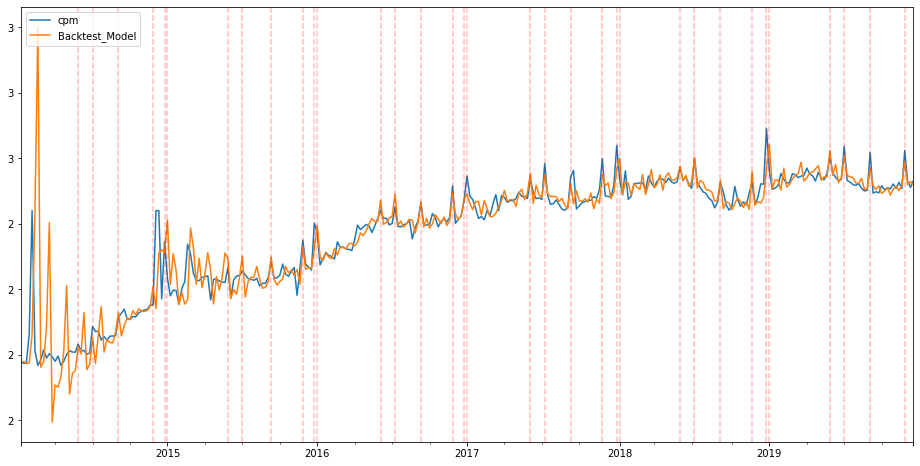

In [360]:
# plt the backtest

ts.plot_fit(train[series], backtest, train)

In [361]:
# predict oos

predictions = ts.make_predictions(model,
                               series + ' SARIMAX',
                               start=len(train) + 1,
                               end= len(train) + len(oos_exog)-1,
                               exog_data=oos_exog)

In [362]:
# conf intervals for oos

intervals = ts.get_oos_conf_interval(model=model,
                                     steps_ahead=horizon,
                                     exog_data = oos_exog)

In [363]:
intervals

Predictions  lower cpm  upper cpm
2019-12-29         2.60       2.51       2.70
2020-01-05         2.59       2.48       2.70
2020-01-12         2.54       2.43       2.65
2020-01-19         2.53       2.41       2.64
2020-01-26         2.53       2.40       2.66
2020-02-02         2.52       2.39       2.66
2020-02-09         2.53       2.38       2.69
2020-02-16         2.52       2.36       2.69
2020-02-23         2.56       2.38       2.73
2020-03-01         2.53       2.35       2.71
2020-03-08         2.53       2.33       2.72
2020-03-15         2.53       2.33       2.73
2020-03-22         2.54       2.32       2.76
2020-03-29         2.53       2.29       2.76
2020-04-05         2.55       2.31       2.80
2020-04-12         2.54       2.28       2.79
2020-04-19         2.54       2.27       2.80
2020-04-26         2.54       2.26       2.82
2020-05-03         2.55       2.25       2.85
2020-05-10         2.53       2.22       2.85
2020-05-17         2.57       2.24       2.89
2020-05-24         2.54       2.20       2.88
2020-05-31         2.60       2.25       2.96

In [364]:
# make df for plotting

conf_df = ts.make_oos_plot_df(model=model,
                           steps_ahead=horizon,
                           exog_data = oos_exog)

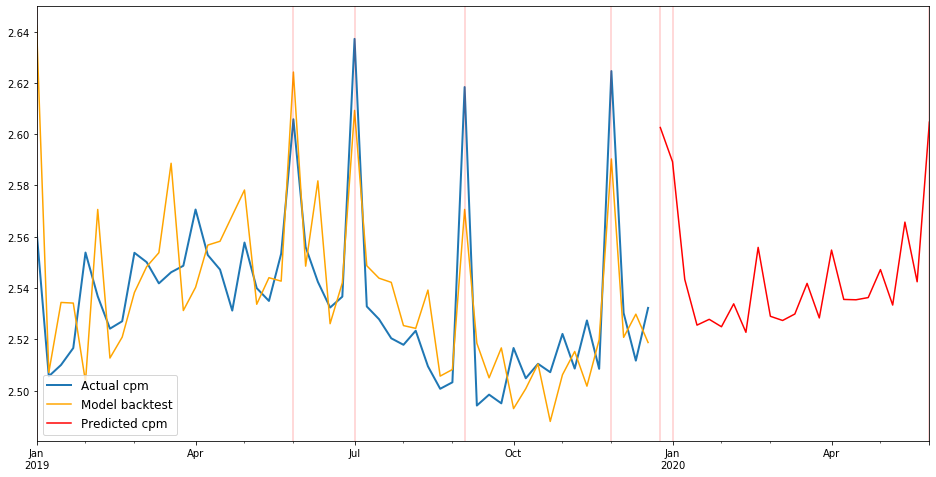

In [365]:
# plot oos 

ts.plot_oos(conf_df, train, series, backtest, oos_exog, start_date='2019-01-01', decimal = True)

In [366]:
# Make final series

cpm_fcast = ts.oos_weekly_df(model=model,
                       steps_ahead=horizon,
                       exog_data = oos_exog,
                       series = series,
                       add_date = False)

cpm_fcast

cpm  lower_cpm  upper_cpm
2019-12-29 2.60       2.51       2.70
2020-01-05 2.59       2.48       2.70
2020-01-12 2.54       2.43       2.65
2020-01-19 2.53       2.41       2.64
2020-01-26 2.53       2.40       2.66
2020-02-02 2.52       2.39       2.66
2020-02-09 2.53       2.38       2.69
2020-02-16 2.52       2.36       2.69
2020-02-23 2.56       2.38       2.73
2020-03-01 2.53       2.35       2.71
2020-03-08 2.53       2.33       2.72
2020-03-15 2.53       2.33       2.73
2020-03-22 2.54       2.32       2.76
2020-03-29 2.53       2.29       2.76
2020-04-05 2.55       2.31       2.80
2020-04-12 2.54       2.28       2.79
2020-04-19 2.54       2.27       2.80
2020-04-26 2.54       2.26       2.82
2020-05-03 2.55       2.25       2.85
2020-05-10 2.53       2.22       2.85
2020-05-17 2.57       2.24       2.89
2020-05-24 2.54       2.20       2.88
2020-05-31 2.60       2.25       2.96

# Begin to Combine Data Frames

In [367]:
list_cols = list(wdf.columns)

# change holiday to holidays

list_cols[1] = 'holidays'


list_cols

['holiday',
 'holidays',
 'vp_rides',
 'vp_costs',
 'vp_miles',
 'vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'vp_stretcher_rides',
 'vp_stretcher_costs',
 'vp_stretcher_miles',
 'vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'vp_wheelchair_miles',
 'riders',
 'cpm']

In [368]:
# remove riders and gross rides
exclude = ['date_ride', 'gross_rides', 'riders', 'holiday', 'holidays', 'cpm']
vp_cols = [e for e in list_cols if e not in exclude]

vp_cols


['vp_rides',
 'vp_costs',
 'vp_miles',
 'vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'vp_stretcher_rides',
 'vp_stretcher_costs',
 'vp_stretcher_miles',
 'vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'vp_wheelchair_miles']

In [369]:
# make a list of dataframes using the columns
holidays = oos_exog

# create empty list
vp_df = []

for df in vp_cols:
    # use eval to handle the string name as actual df
    df = pd.DataFrame(eval(df))
    vp_df.append(df)
    

vp_df

[             vp_rides  lower_vp_rides  upper_vp_rides
 2019-12-29 542,010.63      476,359.71      607,661.54
 2020-01-05 495,845.28      420,717.38      570,973.19
 2020-01-12 630,729.99      548,591.54      712,868.44
 2020-01-19 643,883.66      555,428.99      732,338.34
 2020-01-26 656,442.52      562,108.55      750,776.49
 2020-02-02 670,065.80      553,709.20      786,422.40
 2020-02-09 626,125.53      498,498.41      753,752.65
 2020-02-16 631,923.35      494,612.91      769,233.79
 2020-02-23 648,610.36      502,326.35      794,894.37
 2020-03-01 658,517.13      503,786.66      813,247.60
 2020-03-08 676,440.65      499,695.40      853,185.89
 2020-03-15 621,043.85      430,980.03      811,107.67
 2020-03-22 631,140.05      429,236.19      833,043.91
 2020-03-29 651,457.75      438,435.22      864,480.27
 2020-04-05 663,984.50      440,402.54      887,566.47
 2020-04-12 678,517.03      429,485.20      927,548.86
 2020-04-19 627,923.99      362,738.87      893,109.10
 2020-04-2

In [370]:
# concat them all into a single df
combined_wide = pd.concat(vp_df, axis = 1)
combined_wide

vp_rides  lower_vp_rides  upper_vp_rides      vp_costs  \
2019-12-29 542,010.63      476,359.71      607,661.54 16,908,782.51   
2020-01-05 495,845.28      420,717.38      570,973.19 15,838,036.88   
2020-01-12 630,729.99      548,591.54      712,868.44 19,735,010.91   
2020-01-19 643,883.66      555,428.99      732,338.34 19,965,380.06   
2020-01-26 656,442.52      562,108.55      750,776.49 20,167,995.26   
2020-02-02 670,065.80      553,709.20      786,422.40 20,377,704.57   
2020-02-09 626,125.53      498,498.41      753,752.65 19,848,370.97   
2020-02-16 631,923.35      494,612.91      769,233.79 20,090,184.79   
2020-02-23 648,610.36      502,326.35      794,894.37 20,124,932.63   
2020-03-01 658,517.13      503,786.66      813,247.60 20,233,633.58   
2020-03-08 676,440.65      499,695.40      853,185.89 20,485,157.32   
2020-03-15 621,043.85      430,980.03      811,107.67 20,085,488.99   
2020-03-22 631,140.05      429,236.19      833,043.91 20,288,184.19   
2020-03-29 651,457.75      438,435.22      864,480.27 20,276,081.78   
2020-04-05 663,984.50      440,402.54      887,566.47 20,362,290.76   
2020-04-12 678,517.03      429,485.20      927,548.86 20,623,828.84   
2020-04-19 627,923.99      362,738.87      893,109.10 20,255,214.64   
2020-04-26 636,556.13      356,826.62      916,285.63 20,448,541.14   
2020-05-03 654,426.27      360,945.13      947,907.41 20,425,218.34   
2020-05-10 666,322.29      359,713.62      972,930.97 20,506,040.62   
2020-05-17 681,481.76      349,429.15    1,013,534.37 20,769,977.08   
2020-05-24 631,171.61      281,279.71      981,063.51 20,408,800.19   
2020-05-31 512,839.00      146,558.56      879,119.44 17,108,060.94   

            lower_vp_costs  upper_vp_costs     vp_miles  lower_vp_miles  \
2019-12-29   14,927,729.93   18,889,835.09 6,621,549.28    5,352,993.42   
2020-01-05   13,547,778.94   18,128,294.82 5,985,466.94    4,587,813.09   
2020-01-12   17,223,671.41   22,246,350.40 7,690,138.18    6,207,407.92   
2020-01-19   17,250,905.74   22,679,854.38 7,820,520.25    6,261,195.12   
2020-01-26   17,264,563.64   23,071,426.88 7,919,930.76    6,288,089.95   
2020-02-02   17,022,922.54   23,732,486.61 8,080,361.12    6,111,751.78   
2020-02-09   16,210,257.63   23,486,484.30 7,504,920.24    5,391,921.80   
2020-02-16   16,203,180.31   23,977,189.27 7,659,926.52    5,426,702.74   
2020-02-23   16,004,041.99   24,245,823.28 7,845,199.62    5,499,748.79   
2020-03-01   15,891,436.68   24,575,830.47 7,891,969.84    5,439,658.66   
2020-03-08   15,821,961.15   25,148,353.50 8,145,088.43    5,362,102.31   
2020-03-15   15,167,972.73   25,003,005.25 7,336,094.78    4,381,153.05   
2020-03-22   15,134,857.00   25,441,511.38 7,598,813.90    4,494,925.60   
2020-03-29   14,897,271.73   25,654,891.82 7,850,653.01    4,606,345.86   
2020-04-05   14,767,077.57   25,957,503.95 7,944,160.69    4,565,483.89   
2020-04-12   14,747,317.41   26,500,340.26 8,128,739.16    4,331,402.20   
2020-04-19   14,140,751.10   26,369,678.19 7,422,277.85    3,405,779.45   
2020-04-26   14,109,108.92   26,787,973.36 7,642,368.12    3,435,397.61   
2020-05-03   13,868,531.73   26,981,904.95 7,844,971.56    3,457,968.78   
2020-05-10   13,739,071.36   27,273,009.88 7,929,192.09    3,369,540.71   
2020-05-17   13,738,377.73   27,801,576.43 8,123,094.60    3,167,418.06   
2020-05-24   13,147,643.28   27,669,957.09 7,428,997.59    2,231,860.30   
2020-05-31    9,627,815.93   24,588,305.95 6,136,107.77      722,584.72   

            upper_vp_miles  vp_ambulatory_rides  lower_vp_ambulatory_rides  \
2019-12-29    7,890,105.15           685,154.47                 631,676.05   
2020-01-05    7,383,120.79           677,285.34                 604,719.03   
2020-01-12    9,172,868.44           802,686.38                 717,658.48   
2020-01-19    9,379,845.37           815,380.24                 716,843.61   
2020-01-26    9,551,771.57           793,791.80                 669,164.78   
2020-02-02   10,048,970.46           78

In [371]:
# SKIP THIS STEP
# truncate the series to remove past

# week_incr = 1

# begin = short_horizon + week_incr

# combined_wide_red = combined_wide.iloc[begin:]
# combined_wide_red.head()

In [372]:
len(holidays)

23

In [373]:
holidays

holiday
date               
2019-12-29        1
2020-01-05        1
2020-01-12        0
2020-01-19        0
2020-01-26        0
2020-02-02        0
2020-02-09        0
2020-02-16        0
2020-02-23        0
2020-03-01        0
2020-03-08        0
2020-03-15        0
2020-03-22        0
2020-03-29        0
2020-04-05        0
2020-04-12        0
2020-04-19        0
2020-04-26        0
2020-05-03        0
2020-05-10        0
2020-05-17        0
2020-05-24        0
2020-05-31        1

In [374]:
gross_rides_fcast

gross_rides  lower_gross_rides  upper_gross_rides  fcast_date
2020-03-08   959,514.95         897,708.42       1,021,321.49  2020-03-03
2020-03-15   989,258.34         902,033.12       1,076,483.55  2020-03-03
2020-03-22   918,410.79         811,869.52       1,024,952.07  2020-03-03
2020-03-29   923,012.08         800,073.08       1,045,951.09  2020-03-03
2020-04-05   936,767.16         799,189.82       1,074,344.50  2020-03-03
2020-04-12   958,520.27         807,742.76       1,109,297.77  2020-03-03
2020-04-19   952,423.20         789,672.55       1,115,173.84  2020-03-03
2020-04-26   985,479.74         811,596.17       1,159,363.32  2020-03-03
2020-05-03   966,411.13         781,928.18       1,150,894.08  2020-03-03
2020-05-10   974,354.99         779,799.85       1,168,910.14  2020-03-03
2020-05-17   950,785.28         746,766.75       1,154,803.81  2020-03-03
2020-05-24   977,106.80         764,117.35       1,190,096.25  2020-03-03
2020-05-31   885,501.65         646,242.81       1,124,760.50  2020-03-03

In [375]:
riders_fcast

riders  lower_riders  upper_riders
2020-03-08 467,456.31    438,203.72    496,708.90
2020-03-15 475,516.59    436,214.50    514,818.67
2020-03-22 450,871.62    405,182.73    496,560.51
2020-03-29 451,022.58    399,444.67    502,600.48
2020-04-05 462,849.17    405,140.49    520,557.85
2020-04-12 469,425.67    406,027.18    532,824.17
2020-04-19 463,667.45    395,423.88    531,911.02
2020-04-26 470,524.62    397,959.47    543,089.77
2020-05-03 469,131.30    392,372.21    545,890.39
2020-05-10 474,483.66    393,599.67    555,367.65
2020-05-17 464,304.98    379,505.04    549,104.92
2020-05-24 469,672.17    381,211.32    558,133.03
2020-05-31 421,708.19    324,974.22    518,442.16

In [376]:
cpm_fcast

cpm  lower_cpm  upper_cpm
2019-12-29 2.60       2.51       2.70
2020-01-05 2.59       2.48       2.70
2020-01-12 2.54       2.43       2.65
2020-01-19 2.53       2.41       2.64
2020-01-26 2.53       2.40       2.66
2020-02-02 2.52       2.39       2.66
2020-02-09 2.53       2.38       2.69
2020-02-16 2.52       2.36       2.69
2020-02-23 2.56       2.38       2.73
2020-03-01 2.53       2.35       2.71
2020-03-08 2.53       2.33       2.72
2020-03-15 2.53       2.33       2.73
2020-03-22 2.54       2.32       2.76
2020-03-29 2.53       2.29       2.76
2020-04-05 2.55       2.31       2.80
2020-04-12 2.54       2.28       2.79
2020-04-19 2.54       2.27       2.80
2020-04-26 2.54       2.26       2.82
2020-05-03 2.55       2.25       2.85
2020-05-10 2.53       2.22       2.85
2020-05-17 2.57       2.24       2.89
2020-05-24 2.54       2.20       2.88
2020-05-31 2.60       2.25       2.96

In [377]:
cpm_fcast

cpm  lower_cpm  upper_cpm
2019-12-29 2.60       2.51       2.70
2020-01-05 2.59       2.48       2.70
2020-01-12 2.54       2.43       2.65
2020-01-19 2.53       2.41       2.64
2020-01-26 2.53       2.40       2.66
2020-02-02 2.52       2.39       2.66
2020-02-09 2.53       2.38       2.69
2020-02-16 2.52       2.36       2.69
2020-02-23 2.56       2.38       2.73
2020-03-01 2.53       2.35       2.71
2020-03-08 2.53       2.33       2.72
2020-03-15 2.53       2.33       2.73
2020-03-22 2.54       2.32       2.76
2020-03-29 2.53       2.29       2.76
2020-04-05 2.55       2.31       2.80
2020-04-12 2.54       2.28       2.79
2020-04-19 2.54       2.27       2.80
2020-04-26 2.54       2.26       2.82
2020-05-03 2.55       2.25       2.85
2020-05-10 2.53       2.22       2.85
2020-05-17 2.57       2.24       2.89
2020-05-24 2.54       2.20       2.88
2020-05-31 2.60       2.25       2.96

In [386]:
# concatonate them all


all_forecasts = pd.concat([holidays[0:23], gross_rides_fcast, riders_fcast, cpm_fcast, combined_wide], axis = 1)
all_forecasts


holiday  gross_rides  lower_gross_rides  upper_gross_rides  \
2019-12-29        1          nan                nan                nan   
2020-01-05        1          nan                nan                nan   
2020-01-12        0          nan                nan                nan   
2020-01-19        0          nan                nan                nan   
2020-01-26        0          nan                nan                nan   
2020-02-02        0          nan                nan                nan   
2020-02-09        0          nan                nan                nan   
2020-02-16        0          nan                nan                nan   
2020-02-23        0          nan                nan                nan   
2020-03-01        0          nan                nan                nan   
2020-03-08        0   959,514.95         897,708.42       1,021,321.49   
2020-03-15        0   989,258.34         902,033.12       1,076,483.55   
2020-03-22        0   918,410.79         811,869.52       1,024,952.07   
2020-03-29        0   923,012.08         800,073.08       1,045,951.09   
2020-04-05        0   936,767.16         799,189.82       1,074,344.50   
2020-04-12        0   958,520.27         807,742.76       1,109,297.77   
2020-04-19        0   952,423.20         789,672.55       1,115,173.84   
2020-04-26        0   985,479.74         811,596.17       1,159,363.32   
2020-05-03        0   966,411.13         781,928.18       1,150,894.08   
2020-05-10        0   974,354.99         779,799.85       1,168,910.14   
2020-05-17        0   950,785.28         746,766.75       1,154,803.81   
2020-05-24        0   977,106.80         764,117.35       1,190,096.25   
2020-05-31        1   885,501.65         646,242.81       1,124,760.50   

            fcast_date     riders  lower_riders  upper_riders  cpm  lower_cpm  \
2019-12-29         NaN        nan           nan           nan 2.60       2.51   
2020-01-05         NaN        nan           nan           nan 2.59       2.48   
2020-01-12         NaN        nan           nan           nan 2.54       2.43   
2020-01-19         NaN        nan           nan           nan 2.53       2.41   
2020-01-26         NaN        nan           nan           nan 2.53       2.40   
2020-02-02         NaN        nan           nan           nan 2.52       2.39   
2020-02-09         NaN        nan           nan           nan 2.53       2.38   
2020-02-16         NaN        nan           nan           nan 2.52       2.36   
2020-02-23         NaN        nan           nan           nan 2.56       2.38   
2020-03-01         NaN        nan           nan           nan 2.53       2.35   
2020-03-08  2020-03-03 467,456.31    438,203.72    496,708.90 2.53       2.33   
2020-03-15  2020-03-03 475,516.59    436,214.50    514,818.67 2.53       2.33   
2020-03-22  2020-03-03 450,871.62    405,182.73    496,560.51 2.54       2.32   
2020-03-29  2020-03-03 451,022.58    399,444.67    502,600.48 2.53       2.29   
2020-04-05  2020-03-03 462,849.17    405,140.49    520,557.85 2.55       2.31   
2020-04-12  2020-03-03 469,425.67    406,027.18    532,824.17 2.54       2.28   
2020-04-19  2020-03-03 463,667.45    395,423.88    531,911.02 2.54       2.27   
2020-04-26  2020-03-03 470,524.62    397,959.47    543,089.77 2.54       2.26   
2020-05-03  2020-03-03 469,131.30    392,372.21    545,890.39 2.55       2.25   
2020-05-10  2020-03-03 474,483.66    393,599.67    555,367.65 2.53       2.22   
2020-05-17  2020-03-03 464,304.98    379,505.04    549,104.92 2.57       2.24   
2020-05-24  2020-03-03 469,672.17    381,211.32    558,133.03 2.54       2.20   
2020-05-31  2020-03-03 421,708.19    324,974.22    518,442.16 2.60       2.25   

            upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
2019-12-29       2.70 542,010.63      476,359.71      607,661.54   
2020-01-05       2.70 495,845.28      420,717.38      570,973.19   
2020-01-12       2.65 630,729.99      548,591.54      712,868.44   
2020-01-19       2

In [387]:
#Sometime skip this step

# all_forecasts = all_forecasts[1:19]
# all_forecasts

In [388]:
all_forecasts.tail()

holiday  gross_rides  lower_gross_rides  upper_gross_rides  \
2020-05-03        0   966,411.13         781,928.18       1,150,894.08   
2020-05-10        0   974,354.99         779,799.85       1,168,910.14   
2020-05-17        0   950,785.28         746,766.75       1,154,803.81   
2020-05-24        0   977,106.80         764,117.35       1,190,096.25   
2020-05-31        1   885,501.65         646,242.81       1,124,760.50   

            fcast_date     riders  lower_riders  upper_riders  cpm  lower_cpm  \
2020-05-03  2020-03-03 469,131.30    392,372.21    545,890.39 2.55       2.25   
2020-05-10  2020-03-03 474,483.66    393,599.67    555,367.65 2.53       2.22   
2020-05-17  2020-03-03 464,304.98    379,505.04    549,104.92 2.57       2.24   
2020-05-24  2020-03-03 469,672.17    381,211.32    558,133.03 2.54       2.20   
2020-05-31  2020-03-03 421,708.19    324,974.22    518,442.16 2.60       2.25   

            upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
2020-05-03       2.85 654,426.27      360,945.13      947,907.41   
2020-05-10       2.85 666,322.29      359,713.62      972,930.97   
2020-05-17       2.89 681,481.76      349,429.15    1,013,534.37   
2020-05-24       2.88 631,171.61      281,279.71      981,063.51   
2020-05-31       2.96 512,839.00      146,558.56      879,119.44   

                vp_costs  lower_vp_costs  upper_vp_costs     vp_miles  \
2020-05-03 20,425,218.34   13,868,531.73   26,981,904.95 7,844,971.56   
2020-05-10 20,506,040.62   13,739,071.36   27,273,009.88 7,929,192.09   
2020-05-17 20,769,977.08   13,738,377.73   27,801,576.43 8,123,094.60   
2020-05-24 20,408,800.19   13,147,643.28   27,669,957.09 7,428,997.59   
2020-05-31 17,108,060.94    9,627,815.93   24,588,305.95 6,136,107.77   

            lower_vp_miles  upper_vp_miles  vp_ambulatory_rides  \
2020-05-03    3,457,968.78   12,231,974.33           828,863.56   
2020-05-10    3,369,540.71   12,488,843.46           829,812.70   
2020-05-17    3,167,418.06   13,078,771.14           818,209.83   
2020-05-24    2,231,860.30   12,626,134.87           820,952.34   
2020-05-31      722,584.72   11,549,630.82           738,656.88   

            lower_vp_ambulatory_rides  upper_vp_ambulatory_rides  \
2020-05-03                 450,874.33               1,206,852.79   
2020-05-10                 436,210.53               1,223,414.88   
2020-05-17                 408,094.46               1,228,325.20   
2020-05-24                 394,784.47               1,247,120.22   
2020-05-31                 297,434.46               1,179,879.31   

            vp_ambulatory_costs  lower_vp_ambulatory_costs  \
2020-05-03        13,787,657.70              11,647,847.60   
2020-05-10        13,959,650.49              11,811,514.35   
2020-05-17        14,166,450.66              11,810,430.87   
2020-05-24        12,934,632.53              10,564,736.27   
2020-05-31        10,580,197.30               8,198,620.03   

            upper_vp_ambulatory_costs  vp_ambulatory_miles  \
2020-05-03              15,927,467.80        10,192,224.73   
2020-05-10              16,107,786.63        10,191,978.75   
2020-05-17              16,522,470.45        10,030,886.21   
2020-05-24              15,304,528.80        10,131,496.97   
2020-05-31              12,961,774.56         8,957,977.57   

            lower_vp_ambulatory_miles  upper_vp_ambulatory_miles  \
2020-05-03               5,724,504.76              14,659,944.69   
2020-05-10               5,566,812.10              14,817,145.40   
2020-05-17               5,234,307.22              14,827,465.20   
2020-05-24               5,172,947.87              15,090,046.06   
2020-05-31               3,844,258.34              14,071,696.80   

            vp_stretcher_rides  lower_vp_stretcher_rides  \
2020-05-03           17,434.20                 14,969.32   
2020-05-10           17,446.05                 14,909.38   
2020-05-17           17,307.47                 14,699.85   
2020-05-24           17,2

In [389]:
# row['date'] - timedelta(days = 1)

# set the forecast date
now = dt.now().date()
past = 0
forecast_date = now - timedelta(days = past) 
forecast_date

datetime.date(2020, 3, 3)

In [390]:
# set the forecast date for the whole dataset
all_forecasts['fcast_date'] = forecast_date
all_forecasts

holiday  gross_rides  lower_gross_rides  upper_gross_rides  \
2019-12-29        1          nan                nan                nan   
2020-01-05        1          nan                nan                nan   
2020-01-12        0          nan                nan                nan   
2020-01-19        0          nan                nan                nan   
2020-01-26        0          nan                nan                nan   
2020-02-02        0          nan                nan                nan   
2020-02-09        0          nan                nan                nan   
2020-02-16        0          nan                nan                nan   
2020-02-23        0          nan                nan                nan   
2020-03-01        0          nan                nan                nan   
2020-03-08        0   959,514.95         897,708.42       1,021,321.49   
2020-03-15        0   989,258.34         902,033.12       1,076,483.55   
2020-03-22        0   918,410.79         811,869.52       1,024,952.07   
2020-03-29        0   923,012.08         800,073.08       1,045,951.09   
2020-04-05        0   936,767.16         799,189.82       1,074,344.50   
2020-04-12        0   958,520.27         807,742.76       1,109,297.77   
2020-04-19        0   952,423.20         789,672.55       1,115,173.84   
2020-04-26        0   985,479.74         811,596.17       1,159,363.32   
2020-05-03        0   966,411.13         781,928.18       1,150,894.08   
2020-05-10        0   974,354.99         779,799.85       1,168,910.14   
2020-05-17        0   950,785.28         746,766.75       1,154,803.81   
2020-05-24        0   977,106.80         764,117.35       1,190,096.25   
2020-05-31        1   885,501.65         646,242.81       1,124,760.50   

            fcast_date     riders  lower_riders  upper_riders  cpm  lower_cpm  \
2019-12-29  2020-03-03        nan           nan           nan 2.60       2.51   
2020-01-05  2020-03-03        nan           nan           nan 2.59       2.48   
2020-01-12  2020-03-03        nan           nan           nan 2.54       2.43   
2020-01-19  2020-03-03        nan           nan           nan 2.53       2.41   
2020-01-26  2020-03-03        nan           nan           nan 2.53       2.40   
2020-02-02  2020-03-03        nan           nan           nan 2.52       2.39   
2020-02-09  2020-03-03        nan           nan           nan 2.53       2.38   
2020-02-16  2020-03-03        nan           nan           nan 2.52       2.36   
2020-02-23  2020-03-03        nan           nan           nan 2.56       2.38   
2020-03-01  2020-03-03        nan           nan           nan 2.53       2.35   
2020-03-08  2020-03-03 467,456.31    438,203.72    496,708.90 2.53       2.33   
2020-03-15  2020-03-03 475,516.59    436,214.50    514,818.67 2.53       2.33   
2020-03-22  2020-03-03 450,871.62    405,182.73    496,560.51 2.54       2.32   
2020-03-29  2020-03-03 451,022.58    399,444.67    502,600.48 2.53       2.29   
2020-04-05  2020-03-03 462,849.17    405,140.49    520,557.85 2.55       2.31   
2020-04-12  2020-03-03 469,425.67    406,027.18    532,824.17 2.54       2.28   
2020-04-19  2020-03-03 463,667.45    395,423.88    531,911.02 2.54       2.27   
2020-04-26  2020-03-03 470,524.62    397,959.47    543,089.77 2.54       2.26   
2020-05-03  2020-03-03 469,131.30    392,372.21    545,890.39 2.55       2.25   
2020-05-10  2020-03-03 474,483.66    393,599.67    555,367.65 2.53       2.22   
2020-05-17  2020-03-03 464,304.98    379,505.04    549,104.92 2.57       2.24   
2020-05-24  2020-03-03 469,672.17    381,211.32    558,133.03 2.54       2.20   
2020-05-31  2020-03-03 421,708.19    324,974.22    518,442.16 2.60       2.25   

            upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
2019-12-29       2.70 542,010.63      476,359.71      607,661.54   
2020-01-05       2.70 495,845.28      420,717.38      570,973.19   
2020-01-12       2.65 630,729.99      548,591.54      712,868.44   
2020-01-19       2

In [391]:
# move the fcast_date for simplicity

fc = all_forecasts['fcast_date']
all_forecasts.drop(labels=['fcast_date'], axis=1,inplace = True)
all_forecasts.insert(0, 'fcast_date', fc)

all_forecasts

fcast_date  holiday  gross_rides  lower_gross_rides  \
2019-12-29  2020-03-03        1          nan                nan   
2020-01-05  2020-03-03        1          nan                nan   
2020-01-12  2020-03-03        0          nan                nan   
2020-01-19  2020-03-03        0          nan                nan   
2020-01-26  2020-03-03        0          nan                nan   
2020-02-02  2020-03-03        0          nan                nan   
2020-02-09  2020-03-03        0          nan                nan   
2020-02-16  2020-03-03        0          nan                nan   
2020-02-23  2020-03-03        0          nan                nan   
2020-03-01  2020-03-03        0          nan                nan   
2020-03-08  2020-03-03        0   959,514.95         897,708.42   
2020-03-15  2020-03-03        0   989,258.34         902,033.12   
2020-03-22  2020-03-03        0   918,410.79         811,869.52   
2020-03-29  2020-03-03        0   923,012.08         800,073.08   
2020-04-05  2020-03-03        0   936,767.16         799,189.82   
2020-04-12  2020-03-03        0   958,520.27         807,742.76   
2020-04-19  2020-03-03        0   952,423.20         789,672.55   
2020-04-26  2020-03-03        0   985,479.74         811,596.17   
2020-05-03  2020-03-03        0   966,411.13         781,928.18   
2020-05-10  2020-03-03        0   974,354.99         779,799.85   
2020-05-17  2020-03-03        0   950,785.28         746,766.75   
2020-05-24  2020-03-03        0   977,106.80         764,117.35   
2020-05-31  2020-03-03        1   885,501.65         646,242.81   

            upper_gross_rides     riders  lower_riders  upper_riders  cpm  \
2019-12-29                nan        nan           nan           nan 2.60   
2020-01-05                nan        nan           nan           nan 2.59   
2020-01-12                nan        nan           nan           nan 2.54   
2020-01-19                nan        nan           nan           nan 2.53   
2020-01-26                nan        nan           nan           nan 2.53   
2020-02-02                nan        nan           nan           nan 2.52   
2020-02-09                nan        nan           nan           nan 2.53   
2020-02-16                nan        nan           nan           nan 2.52   
2020-02-23                nan        nan           nan           nan 2.56   
2020-03-01                nan        nan           nan           nan 2.53   
2020-03-08       1,021,321.49 467,456.31    438,203.72    496,708.90 2.53   
2020-03-15       1,076,483.55 475,516.59    436,214.50    514,818.67 2.53   
2020-03-22       1,024,952.07 450,871.62    405,182.73    496,560.51 2.54   
2020-03-29       1,045,951.09 451,022.58    399,444.67    502,600.48 2.53   
2020-04-05       1,074,344.50 462,849.17    405,140.49    520,557.85 2.55   
2020-04-12       1,109,297.77 469,425.67    406,027.18    532,824.17 2.54   
2020-04-19       1,115,173.84 463,667.45    395,423.88    531,911.02 2.54   
2020-04-26       1,159,363.32 470,524.62    397,959.47    543,089.77 2.54   
2020-05-03       1,150,894.08 469,131.30    392,372.21    545,890.39 2.55   
2020-05-10       1,168,910.14 474,483.66    393,599.67    555,367.65 2.53   
2020-05-17       1,154,803.81 464,304.98    379,505.04    549,104.92 2.57   
2020-05-24       1,190,096.25 469,672.17    381,211.32    558,133.03 2.54   
2020-05-31       1,124,760.50 421,708.19    324,974.22    518,442.16 2.60   

            lower_cpm  upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
2019-12-29       2.51       2.70 542,010.63      476,359.71      607,661.54   
2020-01-05       2.48       2.70 495,845.28      420,717.38      570,973.19   
2020-01-12       2.43       2.65 630,729.99      548,591.54      712,868.44   
2020-01-19       2.41       2.64 643,883.66      555,428.99      732,338.34   
2020-01-26       2.40       2.66 656,442.52      562,108.55      750,776.49   
2020-02-02       2.39       2.66 670,065.80      553,709.20      786,422.40   
2

In [392]:
# reset the index
all_forecasts.reset_index(inplace=True)

# rename the column
all_forecasts.rename(columns = {'index':'week_ending'}, inplace = True)

# reassign the index with column name
all_forecasts.set_index('week_ending', inplace = True)

all_forecasts


fcast_date  holiday  gross_rides  lower_gross_rides  \
week_ending                                                        
2019-12-29   2020-03-03        1          nan                nan   
2020-01-05   2020-03-03        1          nan                nan   
2020-01-12   2020-03-03        0          nan                nan   
2020-01-19   2020-03-03        0          nan                nan   
2020-01-26   2020-03-03        0          nan                nan   
2020-02-02   2020-03-03        0          nan                nan   
2020-02-09   2020-03-03        0          nan                nan   
2020-02-16   2020-03-03        0          nan                nan   
2020-02-23   2020-03-03        0          nan                nan   
2020-03-01   2020-03-03        0          nan                nan   
2020-03-08   2020-03-03        0   959,514.95         897,708.42   
2020-03-15   2020-03-03        0   989,258.34         902,033.12   
2020-03-22   2020-03-03        0   918,410.79         811,869.52   
2020-03-29   2020-03-03        0   923,012.08         800,073.08   
2020-04-05   2020-03-03        0   936,767.16         799,189.82   
2020-04-12   2020-03-03        0   958,520.27         807,742.76   
2020-04-19   2020-03-03        0   952,423.20         789,672.55   
2020-04-26   2020-03-03        0   985,479.74         811,596.17   
2020-05-03   2020-03-03        0   966,411.13         781,928.18   
2020-05-10   2020-03-03        0   974,354.99         779,799.85   
2020-05-17   2020-03-03        0   950,785.28         746,766.75   
2020-05-24   2020-03-03        0   977,106.80         764,117.35   
2020-05-31   2020-03-03        1   885,501.65         646,242.81   

             upper_gross_rides     riders  lower_riders  upper_riders  cpm  \
week_ending                                                                  
2019-12-29                 nan        nan           nan           nan 2.60   
2020-01-05                 nan        nan           nan           nan 2.59   
2020-01-12                 nan        nan           nan           nan 2.54   
2020-01-19                 nan        nan           nan           nan 2.53   
2020-01-26                 nan        nan           nan           nan 2.53   
2020-02-02                 nan        nan           nan           nan 2.52   
2020-02-09                 nan        nan           nan           nan 2.53   
2020-02-16                 nan        nan           nan           nan 2.52   
2020-02-23                 nan        nan           nan           nan 2.56   
2020-03-01                 nan        nan           nan           nan 2.53   
2020-03-08        1,021,321.49 467,456.31    438,203.72    496,708.90 2.53   
2020-03-15        1,076,483.55 475,516.59    436,214.50    514,818.67 2.53   
2020-03-22        1,024,952.07 450,871.62    405,182.73    496,560.51 2.54   
2020-03-29        1,045,951.09 451,022.58    399,444.67    502,600.48 2.53   
2020-04-05        1,074,344.50 462,849.17    405,140.49    520,557.85 2.55   
2020-04-12        1,109,297.77 469,425.67    406,027.18    532,824.17 2.54   
2020-04-19        1,115,173.84 463,667.45    395,423.88    531,911.02 2.54   
2020-04-26        1,159,363.32 470,524.62    397,959.47    543,089.77 2.54   
2020-05-03        1,150,894.08 469,131.30    392,372.21    545,890.39 2.55   
2020-05-10        1,168,910.14 474,483.66    393,599.67    555,367.65 2.53   
2020-05-17        1,154,803.81 464,304.98    379,505.04    549,104.92 2.57   
2020-05-24        1,190,096.25 469,672.17    381,211.32    558,133.03 2.54   
2020-05-31        1,124,760.50 421,708.19    324,974.22    518,442.16 2.60   

             lower_cpm  upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
week_ending                                                                    
2019-12-29        2.51       2.70 542,010.63      476,359.71      607,661.54   
2020-01-05        2.48       2.70 495,845.28      420,717.38      570,973.19   
2020-01-12        2.43       2.65 630,729

In [393]:
all_cols = list(all_forecasts.columns)
all_cols

['fcast_date',
 'holiday',
 'gross_rides',
 'lower_gross_rides',
 'upper_gross_rides',
 'riders',
 'lower_riders',
 'upper_riders',
 'cpm',
 'lower_cpm',
 'upper_cpm',
 'vp_rides',
 'lower_vp_rides',
 'upper_vp_rides',
 'vp_costs',
 'lower_vp_costs',
 'upper_vp_costs',
 'vp_miles',
 'lower_vp_miles',
 'upper_vp_miles',
 'vp_ambulatory_rides',
 'lower_vp_ambulatory_rides',
 'upper_vp_ambulatory_rides',
 'vp_ambulatory_costs',
 'lower_vp_ambulatory_costs',
 'upper_vp_ambulatory_costs',
 'vp_ambulatory_miles',
 'lower_vp_ambulatory_miles',
 'upper_vp_ambulatory_miles',
 'vp_stretcher_rides',
 'lower_vp_stretcher_rides',
 'upper_vp_stretcher_rides',
 'vp_stretcher_costs',
 'lower_vp_stretcher_costs',
 'upper_vp_stretcher_costs',
 'vp_stretcher_miles',
 'lower_vp_stretcher_miles',
 'upper_vp_stretcher_miles',
 'vp_wheelchair_rides',
 'lower_vp_wheelchair_rides',
 'upper_vp_wheelchair_rides',
 'vp_wheelchair_costs',
 'lower_vp_wheelchair_costs',
 'upper_vp_wheelchair_costs',
 'vp_wheelchair_

In [394]:
# change names of gross_rides, riders and cpm

col_dict = {'gross_rides': 'gross_rides_fcast', 'riders': 'riders_fcast', 'cpm': 'cpm_fcast'} 

all_forecasts.columns = [col_dict.get(x, x) for x in all_forecasts.columns]


all_forecasts


fcast_date  holiday  gross_rides_fcast  lower_gross_rides  \
week_ending                                                              
2019-12-29   2020-03-03        1                nan                nan   
2020-01-05   2020-03-03        1                nan                nan   
2020-01-12   2020-03-03        0                nan                nan   
2020-01-19   2020-03-03        0                nan                nan   
2020-01-26   2020-03-03        0                nan                nan   
2020-02-02   2020-03-03        0                nan                nan   
2020-02-09   2020-03-03        0                nan                nan   
2020-02-16   2020-03-03        0                nan                nan   
2020-02-23   2020-03-03        0                nan                nan   
2020-03-01   2020-03-03        0                nan                nan   
2020-03-08   2020-03-03        0         959,514.95         897,708.42   
2020-03-15   2020-03-03        0         989,258.34         902,033.12   
2020-03-22   2020-03-03        0         918,410.79         811,869.52   
2020-03-29   2020-03-03        0         923,012.08         800,073.08   
2020-04-05   2020-03-03        0         936,767.16         799,189.82   
2020-04-12   2020-03-03        0         958,520.27         807,742.76   
2020-04-19   2020-03-03        0         952,423.20         789,672.55   
2020-04-26   2020-03-03        0         985,479.74         811,596.17   
2020-05-03   2020-03-03        0         966,411.13         781,928.18   
2020-05-10   2020-03-03        0         974,354.99         779,799.85   
2020-05-17   2020-03-03        0         950,785.28         746,766.75   
2020-05-24   2020-03-03        0         977,106.80         764,117.35   
2020-05-31   2020-03-03        1         885,501.65         646,242.81   

             upper_gross_rides  riders_fcast  lower_riders  upper_riders  \
week_ending                                                                
2019-12-29                 nan           nan           nan           nan   
2020-01-05                 nan           nan           nan           nan   
2020-01-12                 nan           nan           nan           nan   
2020-01-19                 nan           nan           nan           nan   
2020-01-26                 nan           nan           nan           nan   
2020-02-02                 nan           nan           nan           nan   
2020-02-09                 nan           nan           nan           nan   
2020-02-16                 nan           nan           nan           nan   
2020-02-23                 nan           nan           nan           nan   
2020-03-01                 nan           nan           nan           nan   
2020-03-08        1,021,321.49    467,456.31    438,203.72    496,708.90   
2020-03-15        1,076,483.55    475,516.59    436,214.50    514,818.67   
2020-03-22        1,024,952.07    450,871.62    405,182.73    496,560.51   
2020-03-29        1,045,951.09    451,022.58    399,444.67    502,600.48   
2020-04-05        1,074,344.50    462,849.17    405,140.49    520,557.85   
2020-04-12        1,109,297.77    469,425.67    406,027.18    532,824.17   
2020-04-19        1,115,173.84    463,667.45    395,423.88    531,911.02   
2020-04-26        1,159,363.32    470,524.62    397,959.47    543,089.77   
2020-05-03        1,150,894.08    469,131.30    392,372.21    545,890.39   
2020-05-10        1,168,910.14    474,483.66    393,599.67    555,367.65   
2020-05-17        1,154,803.81    464,304.98    379,505.04    549,104.92   
2020-05-24        1,190,096.25    469,672.17    381,211.32    558,133.03   
2020-05-31        1,124,760.50    421,708.19    324,974.22    518,442.16   

             cpm_fcast  lower_cpm  upper_cpm   vp_rides  lower_vp_rides  \
week_ending                                                               
2019-12-29        2.60       2.51       2.70 542,010.63      476,359.71   
2020-01-05        2.59       2.48   

In [395]:
# make a date string for the file name

dt_str = all_forecasts['fcast_date'][0].strftime("%m%d%Y")
dt_str

'03032020'

In [396]:
os.getcwd()

'/Users/bryanbutler/Documents/Python/Forecasting/EWS'

In [397]:
# fill na

all_forecasts = all_forecasts.fillna(0)
all_forecasts

fcast_date  holiday  gross_rides_fcast  lower_gross_rides  \
week_ending                                                              
2019-12-29   2020-03-03        1               0.00               0.00   
2020-01-05   2020-03-03        1               0.00               0.00   
2020-01-12   2020-03-03        0               0.00               0.00   
2020-01-19   2020-03-03        0               0.00               0.00   
2020-01-26   2020-03-03        0               0.00               0.00   
2020-02-02   2020-03-03        0               0.00               0.00   
2020-02-09   2020-03-03        0               0.00               0.00   
2020-02-16   2020-03-03        0               0.00               0.00   
2020-02-23   2020-03-03        0               0.00               0.00   
2020-03-01   2020-03-03        0               0.00               0.00   
2020-03-08   2020-03-03        0         959,514.95         897,708.42   
2020-03-15   2020-03-03        0         989,258.34         902,033.12   
2020-03-22   2020-03-03        0         918,410.79         811,869.52   
2020-03-29   2020-03-03        0         923,012.08         800,073.08   
2020-04-05   2020-03-03        0         936,767.16         799,189.82   
2020-04-12   2020-03-03        0         958,520.27         807,742.76   
2020-04-19   2020-03-03        0         952,423.20         789,672.55   
2020-04-26   2020-03-03        0         985,479.74         811,596.17   
2020-05-03   2020-03-03        0         966,411.13         781,928.18   
2020-05-10   2020-03-03        0         974,354.99         779,799.85   
2020-05-17   2020-03-03        0         950,785.28         746,766.75   
2020-05-24   2020-03-03        0         977,106.80         764,117.35   
2020-05-31   2020-03-03        1         885,501.65         646,242.81   

             upper_gross_rides  riders_fcast  lower_riders  upper_riders  \
week_ending                                                                
2019-12-29                0.00          0.00          0.00          0.00   
2020-01-05                0.00          0.00          0.00          0.00   
2020-01-12                0.00          0.00          0.00          0.00   
2020-01-19                0.00          0.00          0.00          0.00   
2020-01-26                0.00          0.00          0.00          0.00   
2020-02-02                0.00          0.00          0.00          0.00   
2020-02-09                0.00          0.00          0.00          0.00   
2020-02-16                0.00          0.00          0.00          0.00   
2020-02-23                0.00          0.00          0.00          0.00   
2020-03-01                0.00          0.00          0.00          0.00   
2020-03-08        1,021,321.49    467,456.31    438,203.72    496,708.90   
2020-03-15        1,076,483.55    475,516.59    436,214.50    514,818.67   
2020-03-22        1,024,952.07    450,871.62    405,182.73    496,560.51   
2020-03-29        1,045,951.09    451,022.58    399,444.67    502,600.48   
2020-04-05        1,074,344.50    462,849.17    405,140.49    520,557.85   
2020-04-12        1,109,297.77    469,425.67    406,027.18    532,824.17   
2020-04-19        1,115,173.84    463,667.45    395,423.88    531,911.02   
2020-04-26        1,159,363.32    470,524.62    397,959.47    543,089.77   
2020-05-03        1,150,894.08    469,131.30    392,372.21    545,890.39   
2020-05-10        1,168,910.14    474,483.66    393,599.67    555,367.65   
2020-05-17        1,154,803.81    464,304.98    379,505.04    549,104.92   
2020-05-24        1,190,096.25    469,672.17    381,211.32    558,133.03   
2020-05-31        1,124,760.50    421,708.19    324,974.22    518,442.16   

             cpm_fcast  lower_cpm  upper_cpm   vp_rides  lower_vp_rides  \
week_ending                                                               
2019-12-29        2.60       2.51       2.70 542,010.63      476,359.71   
2020-01-05        2.59       2.48   

In [398]:
# reset index before writing

all_forecasts.reset_index(inplace= True)

all_forecasts.to_csv('wide_ews_fcast_' + dt_str + '.csv', index = False)

all_forecasts


week_ending  fcast_date  holiday  gross_rides_fcast  lower_gross_rides  \
0   2019-12-29  2020-03-03        1               0.00               0.00   
1   2020-01-05  2020-03-03        1               0.00               0.00   
2   2020-01-12  2020-03-03        0               0.00               0.00   
3   2020-01-19  2020-03-03        0               0.00               0.00   
4   2020-01-26  2020-03-03        0               0.00               0.00   
5   2020-02-02  2020-03-03        0               0.00               0.00   
6   2020-02-09  2020-03-03        0               0.00               0.00   
7   2020-02-16  2020-03-03        0               0.00               0.00   
8   2020-02-23  2020-03-03        0               0.00               0.00   
9   2020-03-01  2020-03-03        0               0.00               0.00   
10  2020-03-08  2020-03-03        0         959,514.95         897,708.42   
11  2020-03-15  2020-03-03        0         989,258.34         902,033.12   
12  2020-03-22  2020-03-03        0         918,410.79         811,869.52   
13  2020-03-29  2020-03-03        0         923,012.08         800,073.08   
14  2020-04-05  2020-03-03        0         936,767.16         799,189.82   
15  2020-04-12  2020-03-03        0         958,520.27         807,742.76   
16  2020-04-19  2020-03-03        0         952,423.20         789,672.55   
17  2020-04-26  2020-03-03        0         985,479.74         811,596.17   
18  2020-05-03  2020-03-03        0         966,411.13         781,928.18   
19  2020-05-10  2020-03-03        0         974,354.99         779,799.85   
20  2020-05-17  2020-03-03        0         950,785.28         746,766.75   
21  2020-05-24  2020-03-03        0         977,106.80         764,117.35   
22  2020-05-31  2020-03-03        1         885,501.65         646,242.81   

    upper_gross_rides  riders_fcast  lower_riders  upper_riders  cpm_fcast  \
0                0.00          0.00          0.00          0.00       2.60   
1                0.00          0.00          0.00          0.00       2.59   
2                0.00          0.00          0.00          0.00       2.54   
3                0.00          0.00          0.00          0.00       2.53   
4                0.00          0.00          0.00          0.00       2.53   
5                0.00          0.00          0.00          0.00       2.52   
6                0.00          0.00          0.00          0.00       2.53   
7                0.00          0.00          0.00          0.00       2.52   
8                0.00          0.00          0.00          0.00       2.56   
9                0.00          0.00          0.00          0.00       2.53   
10       1,021,321.49    467,456.31    438,203.72    496,708.90       2.53   
11       1,076,483.55    475,516.59    436,214.50    514,818.67       2.53   
12       1,024,952.07    450,871.62    405,182.73    496,560.51       2.54   
13       1,045,951.09    451,022.58    399,444.67    502,600.48       2.53   
14       1,074,344.50    462,849.17    405,140.49    520,557.85       2.55   
15       1,109,297.77    469,425.67    406,027.18    532,824.17       2.54   
16       1,115,173.84    463,667.45    395,423.88    531,911.02       2.54   
17       1,159,363.32    470,524.62    397,959.47    543,089.77       2.54   
18       1,150,894.08    469,131.30    392,372.21    545,890.39       2.55   
19       1,168,910.14    474,483.66    393,599.67    555,367.65       2.53   
20       1,154,803.81    464,304.98    379,505.04    549,104.92       2.57   
21       1,190,096.25    469,672.17    381,211.32    558,133.03       2.54   
22       1,124,760.50    421,708.19    324,974.22    518,442.16       2.60   

    lower_cpm  upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
0        2.51       2.70 542,010.63      476,359.71      607,661.54   
1        2.48       2.70 495,845.28      420,717.38      570,973.19   
2        2.43       2.65 630,729.99      548,591.54      712,868.44 

In [399]:
# change holiday column type

all_forecasts['holiday'] = all_forecasts['holiday'].astype(bool)

all_forecasts.holiday.dtype

dtype('bool')

In [ ]:
# SKIP THIS STEP
# trim off long horizon

# all_forecasts = all_forecasts.iloc[0:8]
# all_forecasts

# Upload the Forecasts

In [408]:
from sqlalchemy import create_engine

In [409]:
# enter user for dw_datascience

uid = getpass.getpass(stream=sys.stderr)

//anaconda3/envs/timeseries36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel
  This is separate from the ipykernel package so we can avoid doing imports until


········


In [410]:
pwd = getpass.getpass()

········


In [411]:
# make the connection and upload the dataframe
conn_string = 'postgresql+psycopg2://' + uid + ':' + pwd + '@rs-prd-bi-cluster.cdw0722fdg2r.us-east-1.redshift.amazonaws.com:5439/dw_main'

In [412]:
conn = create_engine(conn_string)

In [441]:
# get the old version of CSV to push

data = pd.read_csv('wide_ews_fcast_02012020.txt', sep='\t', parse_dates = True)
data

week_ending fcast_date  holiday  gross_rides_fcast  lower_gross_rides  \
0   2019-11-03     2/1/20        0                nan                nan   
1   2019-11-10     2/1/20        0                nan                nan   
2   2019-11-17     2/1/20        0                nan                nan   
3   2019-11-24     2/1/20        0                nan                nan   
4   2019-12-01     2/1/20        1                nan                nan   
5   2019-12-08     2/1/20        0                nan                nan   
6   2019-12-15     2/1/20        0                nan                nan   
7   2019-12-22     2/1/20        0                nan                nan   
8   2019-12-29     2/1/20        1                nan                nan   
9   2020-01-05     2/1/20        1         756,582.58         694,516.78   
10  2020-01-12     2/1/20        0         877,617.34         790,004.07   
11  2020-01-19     2/1/20        0         896,851.19         790,781.92   
12  2020-01-26     2/1/20        1         779,260.49         657,644.31   
13  2020-02-02     2/1/20        0         876,932.54         740,674.09   
14  2020-02-09     2/1/20        0         880,805.79         731,010.04   
15  2020-02-16     2/1/20        0         920,640.65         759,089.92   
16  2020-02-23     2/1/20        1         780,652.05         608,565.40   
17  2020-03-01     2/1/20        0         868,322.97         685,846.27   

    upper_gross_rides  riders_fcast  lower_riders  upper_riders  cpm_fcast  \
0                 nan           nan           nan           nan       2.50   
1                 nan           nan           nan           nan       2.51   
2                 nan           nan           nan           nan       2.49   
3                 nan           nan           nan           nan       2.57   
4                 nan           nan           nan           nan       2.50   
5                 nan           nan           nan           nan       2.48   
6                 nan           nan           nan           nan       2.49   
7                 nan           nan           nan           nan       2.56   
8                 nan           nan           nan           nan       2.55   
9          818,648.38    370,203.13    340,725.41    399,680.86       2.48   
10         965,230.62    428,536.15    386,930.05    470,142.26       2.50   
11       1,002,920.47    437,374.65    386,958.15    487,791.14       2.54   
12         900,876.66    380,989.92    323,142.90    438,836.95       2.47   
13       1,013,190.98    429,177.62    364,372.65    493,982.60       2.47   
14       1,030,601.55    430,784.57    359,565.25    502,003.89       2.47   
15       1,082,191.38    448,708.60    371,894.02    525,523.18       2.54   
16         952,738.69    380,836.14    298,985.85    462,686.43       2.49   
17       1,050,799.67    424,622.87    337,825.04    511,420.70       2.46   

    lower_cpm  upper_cpm   vp_rides  lower_vp_rides  upper_vp_rides  \
0        2.36       2.63 655,159.10      594,253.72      716,064.49   
1        2.36       2.66 635,445.26      573,828.42      697,062.11   
2        2.33       2.66 640,356.08      578,170.56      702,541.59   
3        2.40       2.74 508,410.52      445,769.47      571,051.56   
4        2.32       2.68 651,550.02      576,963.65      726,136.39   
5        2.29       2.68 656,503.58      580,969.78      732,037.39   
6        2.28       2.69 635,470.55      559,180.13      711,760.97   
7        2.35       2.78 508,224.06      431,327.98      585,120.13   
8        2.33       2.78 510,190.98      432,809.20      587,572.76   
9        2.25       2.71 652,868.50      564,308.00      741,428.99   
10       2.25       2.74 657,708.11      568,183.89      747,232.34   
11       2.28       2.80 500,838.39      410,543.31      591,133.48   
12       2.20       2.74 642,693.73      551,780.83      733,606.64   
13       2.19       2.75 644,125.91      552,717.06      735,534.76   
14       2

In [430]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 48 columns):
week_ending                  18 non-null object
fcast_date                   18 non-null object
holiday                      18 non-null int64
gross_rides_fcast            9 non-null float64
lower_gross_rides            9 non-null float64
upper_gross_rides            9 non-null float64
riders_fcast                 9 non-null float64
lower_riders                 9 non-null float64
upper_riders                 9 non-null float64
cpm_fcast                    18 non-null float64
lower_cpm                    18 non-null float64
upper_cpm                    18 non-null float64
vp_rides                     18 non-null float64
lower_vp_rides               18 non-null float64
upper_vp_rides               18 non-null float64
vp_costs                     18 non-null float64
lower_vp_costs               18 non-null float64
upper_vp_costs               18 non-null float64
vp_miles                 

In [442]:
data['week_ending'] = pd.to_datetime(data['week_ending'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 48 columns):
week_ending                  18 non-null datetime64[ns]
fcast_date                   18 non-null object
holiday                      18 non-null int64
gross_rides_fcast            9 non-null float64
lower_gross_rides            9 non-null float64
upper_gross_rides            9 non-null float64
riders_fcast                 9 non-null float64
lower_riders                 9 non-null float64
upper_riders                 9 non-null float64
cpm_fcast                    18 non-null float64
lower_cpm                    18 non-null float64
upper_cpm                    18 non-null float64
vp_rides                     18 non-null float64
lower_vp_rides               18 non-null float64
upper_vp_rides               18 non-null float64
vp_costs                     18 non-null float64
lower_vp_costs               18 non-null float64
upper_vp_costs               18 non-null float64
vp_miles         

In [444]:
# upload the new data

data.to_sql(name = 'ews_forecasts',
          con = conn,
          schema='dw_datascience',
          index=False,
          if_exists='append')

In [407]:
# all_forecasts

all_forecasts.to_sql(name = 'ews_forecasts',
          con = conn,
          schema='dw_datascience',
          index=False,
          if_exists='append')

DatabaseError: (psycopg2.DatabaseError) SSL SYSCALL error: Operation timed out

[SQL: select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where n.nspname=%(schema)s and relname=%(name)s]
[parameters: {'schema': 'dw_datascience', 'name': 'ews_forecasts'}]
(Background on this error at: http://sqlalche.me/e/4xp6)

In [ ]:
del uid, pwd, conn_string

In [ ]:
agg_cols = all_forecasts.columns
agg_cols

In [ ]:
all_forecasts.head(10)

In [ ]:
# convert holiday to 1, 0
all_forecasts['holiday'] =  all_forecasts['holiday'].astype(int)

all_forecasts.head()

In [ ]:
# drop the confidence limits
import re

regex = r"(upper_[a-z]*)|(lower_[a-z]*)"

weekly_red = all_forecasts[all_forecasts.columns.drop(list(all_forecasts.filter(regex=regex)))]
weekly_red.head()

In [ ]:
month_roll = all_forecasts.copy()
month_roll.head()

In [ ]:
list_cols =list(month_roll.columns)
list_cols

In [ ]:
list_cols[46]

In [ ]:
month_df = month_roll.resample('M').agg({list_cols[1]: np.sum, list_cols[2]: np.sum, list_cols[3]: np.sum,
                                         list_cols[4]: np.sum, list_cols[5]: np.sum, list_cols[6]: np.sum,
                                         list_cols[7]: np.sum,
                                         list_cols[8]: np.mean, list_cols[9]: np.mean, list_cols[10]: np.mean,
                                         list_cols[11]: np.sum, list_cols[12]: np.sum, list_cols[13]: np.sum,
                                         list_cols[14]: np.sum, list_cols[15]: np.sum, list_cols[16]: np.sum,
                                         list_cols[17]: np.sum, list_cols[18]: np.sum, list_cols[19]: np.sum,
                                         list_cols[20]: np.sum, list_cols[21]: np.sum, list_cols[22]: np.sum,
                                         list_cols[23]: np.sum, list_cols[24]: np.sum, list_cols[25]: np.sum,
                                         list_cols[26]: np.sum, list_cols[27]: np.sum, list_cols[28]: np.sum,
                                         list_cols[29]: np.sum, list_cols[30]: np.sum, list_cols[31]: np.sum,
                                         list_cols[32]: np.sum, list_cols[33]: np.sum, list_cols[34]: np.sum,
                                         list_cols[35]: np.sum, list_cols[36]: np.sum, list_cols[37]: np.sum,
                                         list_cols[38]: np.sum, list_cols[39]: np.sum, list_cols[40]: np.sum,
                                         list_cols[41]: np.sum, list_cols[42]: np.sum, list_cols[43]: np.sum,
                                         list_cols[44]: np.sum, list_cols[45]: np.sum, list_cols[46]: np.sum,
                                        })




month_df